In [6]:
#!pip install tensorflow
#!pip install scikit-learn
#!pip install matplotlib
#!pip install pandas
#!pip install pyyaml
#!pip install shap


In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import yaml
import warnings
warnings.simplefilter("ignore")
#from joblib import load, dump
import argparse
#import shap
import numpy as np
import matplotlib.pyplot as plt
import functools
print = functools.partial(print, flush=True)
from sklearn.preprocessing import label_binarize, MinMaxScaler
from tensorflow import keras
from sklearn.metrics import (
    roc_curve,precision_score,
    precision_recall_curve,roc_auc_score,
     f1_score,accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    confusion_matrix,
    average_precision_score,
    recall_score
)
import pickle
from sklearn.utils import class_weight
import shap
# from keras_sequential_ascii import keras2ascii
# from nnv import NNV


2024-11-08 13:11:36.839199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open(
        "../../configs/col_config.yaml"
    ) as fh:
        config_dict = yaml.safe_load(fh)

with open(
        "../../configs/var_class.yaml"
    ) as fh1:
        var_dict = yaml.safe_load(fh1)


In [4]:
set(var_dict.values())


{'3 prime UTR',
 '5 prime UTR',
 'complex substitution',
 'exon loss variant',
 'frameshift elongation',
 'frameshift truncation',
 'inframe deletion',
 'inframe insertion',
 'intergenic',
 'intron',
 'missense',
 'other',
 'other RNA',
 'splice site',
 'start lost',
 'start retained',
 'stop gained',
 'stop lost',
 'stop retained',
 'synonymous'}

In [11]:
#amis = pd.read_csv("/Users/tarunmamidi/Downloads/AlphaMissense_hg38.tsv", low_memory=False, skiprows=3, sep='\t')
#amis.head()


In [56]:
raw_data = pd.read_csv(f"../../data/0001.vcf.variant.csv", low_memory=False, skiprows=366, usecols=['chrom','pos','ref_base','alt_base','alphamissense.am_pathogenicity','alphamissense.am_class','alphamissense.transcript_id','alphamissense.uniprot_id','alphamissense.protein_variant','extra_vcf_info.CLNREVSTAT','extra_vcf_info.CLNSIG','extra_vcf_info.CLNSIGCONF'] )
print(raw_data.shape)
raw_data.head()

(812253, 12)


chrom     pos               ref_base alt_base   
0  chr1   69314                      T        G  \
1  chr1   69423                      G        A   
2  chr1   69731                      T        C   
3  chr1  926026                      G        T   
4  chr1  930082  GCCCCACCTTCCTCTCCTCCT        -   

   alphamissense.am_pathogenicity alphamissense.am_class   
0                          0.4921              ambiguous  \
1                          0.7846      likely_pathogenic   
2                          0.4775              ambiguous   
3                             NaN                    NaN   
4                             NaN                    NaN   

  alphamissense.transcript_id alphamissense.uniprot_id   
0           ENST00000335137.4                   Q8NH21  \
1           ENST00000335137.4                   Q8NH21   
2           ENST00000335137.4                   Q8NH21   
3                         NaN                      NaN   
4                         NaN                      NaN   

  alphamissense.protein_variant            extra_vcf_info.CLNREVSTAT   
0                          I75S  criteria_provided,_single_submitter  \
1                         M111I  criteria_provided,_single_submitter   
2                         I214T  criteria_provided,_single_submitter   
3                           NaN  criteria_provided,_single_submitter   
4                           NaN  criteria_provided,_single_submitter   

    extra_vcf_info.CLNSIG extra_vcf_info.CLNSIGCONF  
0  Uncertain_significance                       NaN  
1  Uncertain_significance                       NaN  
2  Uncertain_significance                       NaN  
3           Likely_benign                       NaN  
4           Likely_benign                       NaN

In [6]:
raw_data.columns.to_list()

['chrom',
 'pos',
 'ref_base',
 'alt_base',
 'alphamissense.am_pathogenicity',
 'alphamissense.am_class',
 'alphamissense.transcript_id',
 'alphamissense.uniprot_id',
 'alphamissense.protein_variant',
 'extra_vcf_info.CLNREVSTAT',
 'extra_vcf_info.CLNSIG',
 'extra_vcf_info.CLNSIGCONF']

In [57]:
X_test = pd.read_csv("../../data/0001_filtered_annots.csv.gz")
print(X_test.shape)
X_test.head()


(4219944, 130)


transcript   gene       consequence protein_hgvs cdna_hgvs chrom   
0  ENST00000335137  OR4F5  missense_variant   p.Ile75Ser  c.224T>G  chr1  \
1  ENST00000641515  OR4F5  missense_variant   p.Ile96Ser  c.287T>G  chr1   
2  ENST00000335137  OR4F5  missense_variant  p.Met111Ile  c.333G>A  chr1   
3  ENST00000641515  OR4F5  missense_variant  p.Met132Ile  c.396G>A  chr1   
4  ENST00000335137  OR4F5  missense_variant  p.Ile214Thr  c.641T>C  chr1   

     pos ref_base alt_base clingen.disease  ... gnomad_gene.oe_syn   
0  69314        T        G             NaN  ...            0.98265  \
1  69314        T        G             NaN  ...                NaN   
2  69423        G        A             NaN  ...            0.98265   
3  69423        G        A             NaN  ...                NaN   
4  69731        T        C             NaN  ...            0.98265   

   gnomad_gene.lof_z gnomad_gene.mis_z gnomad_gene.syn_z  gnomad_gene.pLI   
0            0.17916           0.55236          0.072506          0.03065  \
1                NaN               NaN               NaN              NaN   
2            0.17916           0.55236          0.072506          0.03065   
3                NaN               NaN               NaN              NaN   
4            0.17916           0.55236          0.072506          0.03065   

   gnomad_gene.pRec  gnomad_gene.pNull gnomad3.af.1  phi.phi                so  
0           0.61116            0.35819          NaN  0.06092  missense_variant  
1               NaN                NaN          NaN  0.06092  missense_variant  
2           0.61116            0.35819          NaN  0.06092  missense_variant  
3               NaN                NaN          NaN  0.06092  missense_variant  
4           0.61116            0.35819          NaN  0.06092  missense_variant  

[5 rows x 130 columns]

In [58]:
cols = ['transcript','gene','consequence','protein_hgvs','cdna_hgvs','chrom','pos','ref_base','alt_base','clinvar.sig','clinvar.rev_stat','clinvar.sig_conf','gnomad3.af','DITTO','cadd.phred','chasmplus.score','clinpred.score','dann.score','fathmm.fathmm_score','funseq2.score','gerp.gerp_rs','lrt.lrt_score','mavedb.score','metalr.score','metasvm.score','mutpred1.mutpred_general_score','mutation_assessor.score','mutationtaster.score','provean.score','revel.score','sift.score','spliceai.ds_ag','spliceai.ds_al','spliceai.ds_dg','spliceai.ds_dl','spliceai.dp_ag','spliceai.dp_al','spliceai.dp_dg','spliceai.dp_dl','varity_r.varity_r_loo','vest.score']
X_test = X_test[cols]
print(X_test.shape)
X_test.head()

(4219944, 41)


transcript   gene       consequence protein_hgvs cdna_hgvs chrom   
0  ENST00000335137  OR4F5  missense_variant   p.Ile75Ser  c.224T>G  chr1  \
1  ENST00000641515  OR4F5  missense_variant   p.Ile96Ser  c.287T>G  chr1   
2  ENST00000335137  OR4F5  missense_variant  p.Met111Ile  c.333G>A  chr1   
3  ENST00000641515  OR4F5  missense_variant  p.Met132Ile  c.396G>A  chr1   
4  ENST00000335137  OR4F5  missense_variant  p.Ile214Thr  c.641T>C  chr1   

     pos ref_base alt_base clinvar.sig  ... spliceai.ds_ag  spliceai.ds_al   
0  69314        T        G         NaN  ...            NaN             NaN  \
1  69314        T        G         NaN  ...            NaN             NaN   
2  69423        G        A         NaN  ...            NaN             NaN   
3  69423        G        A         NaN  ...            NaN             NaN   
4  69731        T        C         NaN  ...            NaN             NaN   

   spliceai.ds_dg  spliceai.ds_dl  spliceai.dp_ag  spliceai.dp_al   
0             NaN             NaN             NaN             NaN  \
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   spliceai.dp_dg  spliceai.dp_dl varity_r.varity_r_loo  vest.score  
0             NaN             NaN              0.857105       0.674  
1             NaN             NaN              0.857105         NaN  
2             NaN             NaN              0.929340       0.607  
3             NaN             NaN              0.929340         NaN  
4             NaN             NaN              0.835266       0.557  

[5 rows x 41 columns]

In [59]:
merged = pd.merge(raw_data, X_test, how='inner', left_on=['chrom','pos','ref_base','alt_base'], right_on=['chrom','pos','ref_base','alt_base'])
print(merged.shape)
merged.head()


(4220214, 49)


chrom    pos ref_base alt_base  alphamissense.am_pathogenicity   
0  chr1  69314        T        G                          0.4921  \
1  chr1  69314        T        G                          0.4921   
2  chr1  69423        G        A                          0.7846   
3  chr1  69423        G        A                          0.7846   
4  chr1  69731        T        C                          0.4775   

  alphamissense.am_class alphamissense.transcript_id alphamissense.uniprot_id   
0              ambiguous           ENST00000335137.4                   Q8NH21  \
1              ambiguous           ENST00000335137.4                   Q8NH21   
2      likely_pathogenic           ENST00000335137.4                   Q8NH21   
3      likely_pathogenic           ENST00000335137.4                   Q8NH21   
4              ambiguous           ENST00000335137.4                   Q8NH21   

  alphamissense.protein_variant            extra_vcf_info.CLNREVSTAT  ...   
0                          I75S  criteria_provided,_single_submitter  ...  \
1                          I75S  criteria_provided,_single_submitter  ...   
2                         M111I  criteria_provided,_single_submitter  ...   
3                         M111I  criteria_provided,_single_submitter  ...   
4                         I214T  criteria_provided,_single_submitter  ...   

  spliceai.ds_ag spliceai.ds_al spliceai.ds_dg spliceai.ds_dl spliceai.dp_ag   
0            NaN            NaN            NaN            NaN            NaN  \
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

  spliceai.dp_al spliceai.dp_dg spliceai.dp_dl varity_r.varity_r_loo   
0            NaN            NaN            NaN              0.857105  \
1            NaN            NaN            NaN              0.857105   
2            NaN            NaN            NaN              0.929340   
3            NaN            NaN            NaN              0.929340   
4            NaN            NaN            NaN              0.835266   

   vest.score  
0       0.674  
1         NaN  
2       0.607  
3         NaN  
4       0.557  

[5 rows x 49 columns]

In [25]:
config_dict['BenchmarkSignificance']

['Pathogenic',
 'Likely pathogenic',
 'Likely benign',
 'Benign',
 'Benign/Likely benign',
 'Pathogenic/Likely pathogenic',
 'Pathogenic, other',
 'Pathogenic/Likely pathogenic, other',
 'Pathogenic, drug response']

In [31]:
merged['extra_vcf_info.CLNSIG'].unique()

array(['Uncertain_significance', 'Likely_benign', 'Benign', 'Pathogenic',
       'Likely_pathogenic', 'Pathogenic/Likely_pathogenic',
       'Conflicting_classifications_of_pathogenicity', nan,
       'Benign/Likely_benign', 'not_provided', 'association',
       'drug_response', 'other', 'Likely_risk_allele',
       'Likely_pathogenic,_low_penetrance',
       'no_classifications_from_unflagged_records',
       'Uncertain_risk_allele',
       'Uncertain_significance/Uncertain_risk_allele', 'Affects',
       'no_classification_for_the_single_variant', 'risk_factor',
       'Pathogenic|other', 'association_not_found'], dtype=object)

In [60]:
#Filter variants for clinvar_review
df= merged.loc[merged['extra_vcf_info.CLNSIG'].isin(['Likely_benign', 'Benign', 'Pathogenic',
       'Likely_pathogenic', 'Pathogenic/Likely_pathogenic','Benign/Likely_benign','Likely_pathogenic,_low_penetrance','Pathogenic|other'])]
#df= df.loc[df['extra_vcf_info.CLNSIG'].isin(config_dict['train_ClinicalSignificance'])]
print('\nVariant-transcript pairs shape =', df.shape)
print('\nVariants shape =', df[['chrom','pos','ref_base','alt_base']].drop_duplicates().shape)
print('\nclinvar_CLNSIG:\n', df['extra_vcf_info.CLNSIG'].value_counts())
print('\nclinvar_review:\n', df['extra_vcf_info.CLNREVSTAT'].value_counts())


Variant-transcript pairs shape = (2006577, 49)

Variants shape = (360467, 4)

clinvar_CLNSIG:
 extra_vcf_info.CLNSIG
Likely_benign                        1567445
Pathogenic                            185305
Likely_pathogenic                     160659
Benign                                 82057
Pathogenic/Likely_pathogenic            6810
Benign/Likely_benign                    4286
Likely_pathogenic,_low_penetrance         11
Pathogenic|other                           4
Name: count, dtype: int64

clinvar_review:
 extra_vcf_info.CLNREVSTAT
criteria_provided,_single_submitter                     1936360
criteria_provided,_multiple_submitters,_no_conflicts      51934
no_assertion_criteria_provided                            16005
reviewed_by_expert_panel                                   2278
Name: count, dtype: int64


In [61]:
df['class'] = ''
conditions = [
    #(df['clinvar.sig'] == 'Conflicting interpretations of pathogenicity') & df['clinvar.sig_conf'].str.contains('athogen'),
    (df['extra_vcf_info.CLNSIG'] == 'Likely_benign') | (df['extra_vcf_info.CLNSIG'] == 'Benign') | (df['extra_vcf_info.CLNSIG'] == 'Benign/Likely_benign'),
    (df['extra_vcf_info.CLNSIG'] == 'Likely_pathogenic') | (df['extra_vcf_info.CLNSIG'] == 'Pathogenic') | (df['extra_vcf_info.CLNSIG'] == 'Pathogenic/Likely_pathogenic') | (df['extra_vcf_info.CLNSIG'] == 'Likely_pathogenic,_low_penetrance') | (df['extra_vcf_info.CLNSIG'] == 'Pathogenic|other'),

]

values = ['low_impact', 'high_impact']

df['class'] = np.select(conditions, values)
df= df.loc[df['class'].isin(['low_impact', 'high_impact'])]
print('\nVariant-transcript pairs shape =', df.shape)
print('\nVariants shape =', df[['chrom','pos','ref_base','alt_base']].drop_duplicates().shape)
print('\nClasses:\n', df['class'].value_counts())


Variant-transcript pairs shape = (2006577, 50)

Variants shape = (360467, 4)

Classes:
 class
low_impact     1653788
high_impact     352789
Name: count, dtype: int64


In [62]:
df = df.sort_values('DITTO', ascending=False).drop_duplicates(['chrom','pos','ref_base','alt_base']).reset_index(drop=True)
print('\nVariant-transcript pairs shape =', df.shape)
print('\nClasses:\n', df['class'].value_counts())


Variant-transcript pairs shape = (360467, 50)

Classes:
 class
low_impact     304452
high_impact     56015
Name: count, dtype: int64


In [63]:
df['test_class'] = 1- label_binarize(
        df['class'].values, classes=list(np.unique(df['class']))
    ).ravel()

In [25]:
df[['class','test_class','DITTO']].tail()

class  test_class  DITTO
360462  low_impact           0    0.0
360463  low_impact           0    0.0
360464  low_impact           0    0.0
360465  low_impact           0    0.0
360466  low_impact           0    0.0

In [64]:
# get maximum value from 4 spliceai columns

df['spliceai'] = df[['spliceai.ds_ag','spliceai.ds_al','spliceai.ds_dg','spliceai.ds_dl']].max(axis=1)
df.drop(['spliceai.ds_ag','spliceai.ds_al','spliceai.ds_dg','spliceai.ds_dl'], axis=1, inplace=True)
df['spliceai'].head()


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: spliceai, dtype: float64

<Axes: ylabel='Frequency'>

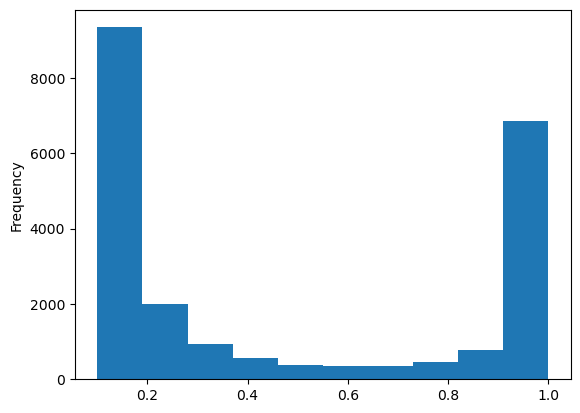

In [27]:
df['spliceai'].plot.hist()


In [56]:
df.tail()


chrom    pos ref_base alt_base  alphamissense.am_pathogenicity   
4219865  chrM  12007        G        A                             NaN  \
4219866  chrM  12007        G        A                             NaN   
4219902  chrM  15215        G        A                             NaN   
4219903  chrM  15215        G        A                             NaN   
4219904  chrM  15215        G        A                             NaN   

        alphamissense.am_class alphamissense.transcript_id   
4219865                    NaN                         NaN  \
4219866                    NaN                         NaN   
4219902                    NaN                         NaN   
4219903                    NaN                         NaN   
4219904                    NaN                         NaN   

        alphamissense.uniprot_id alphamissense.protein_variant   
4219865                      NaN                           NaN  \
4219866                      NaN                           NaN   
4219902                      NaN                           NaN   
4219903                      NaN                           NaN   
4219904                      NaN                           NaN   

                   extra_vcf_info.CLNREVSTAT  ... sift.score spliceai.dp_ag   
4219865       no_assertion_criteria_provided  ...        NaN            NaN  \
4219866       no_assertion_criteria_provided  ...        NaN            NaN   
4219902  criteria_provided,_single_submitter  ...        NaN            NaN   
4219903  criteria_provided,_single_submitter  ...        NaN            NaN   
4219904  criteria_provided,_single_submitter  ...        NaN            NaN   

        spliceai.dp_al spliceai.dp_dg spliceai.dp_dl varity_r.varity_r_loo   
4219865            NaN            NaN            NaN                   NaN  \
4219866            NaN            NaN            NaN                   NaN   
4219902            NaN            NaN            NaN                   NaN   
4219903            NaN            NaN            NaN                   NaN   
4219904            NaN            NaN            NaN                   NaN   

        vest.score        class test_class  spliceai  
4219865        NaN   low_impact          0       NaN  
4219866        NaN   low_impact          0       NaN  
4219902        NaN  high_impact          1       NaN  
4219903        NaN  high_impact          1       NaN  
4219904        NaN  high_impact          1       NaN  

[5 rows x 48 columns]

In [12]:
df[['chrom', 'pos', 'ref_base', 'alt_base','class','DITTO']].to_csv("../../data/new_testing_variants.csv", index=False)

In [13]:
df.to_csv("../../data/new_testing_variants_with_annots.csv", index=False)

## Load up cleaned data

In [3]:
df = pd.read_csv("../../data/new_testing_variants_with_annots.csv")
print(df.shape)
df.head()

(360467, 48)


chrom       pos ref_base alt_base  alphamissense.am_pathogenicity   
0   chr6  32847960        T        A                             NaN  \
1   chr2   1889311        C        T                             NaN   
2  chr11  57600137        C        T                             NaN   
3  chr11  57600149        C        T                             NaN   
4  chr17   7907959        C        T                             NaN   

  alphamissense.am_class alphamissense.transcript_id alphamissense.uniprot_id   
0                    NaN                         NaN                      NaN  \
1                    NaN                         NaN                      NaN   
2                    NaN                         NaN                      NaN   
3                    NaN                         NaN                      NaN   
4                    NaN                         NaN                      NaN   

  alphamissense.protein_variant            extra_vcf_info.CLNREVSTAT  ...   
0                           NaN  criteria_provided,_single_submitter  ...  \
1                           NaN  criteria_provided,_single_submitter  ...   
2                           NaN  criteria_provided,_single_submitter  ...   
3                           NaN  criteria_provided,_single_submitter  ...   
4                           NaN  criteria_provided,_single_submitter  ...   

  sift.score  spliceai.dp_ag spliceai.dp_al spliceai.dp_dg spliceai.dp_dl   
0        NaN             NaN            NaN            NaN            NaN  \
1        NaN             NaN            NaN            NaN            NaN   
2        NaN             NaN            NaN            NaN            NaN   
3        NaN             NaN            NaN            NaN            NaN   
4        NaN             NaN            NaN            NaN            NaN   

  varity_r.varity_r_loo vest.score        class test_class  spliceai  
0                   NaN        NaN  high_impact          1       NaN  
1                   NaN      0.971  high_impact          1       NaN  
2                   NaN      0.620  high_impact          1       NaN  
3                   NaN      0.725  high_impact          1       NaN  
4                   NaN      0.617  high_impact          1       NaN  

[5 rows x 48 columns]

In [65]:
# df = pd.read_csv("/Users/tarunmamidi/Documents/Development/DITTO-1/data/DITTO_scores_test_1_transcript_variants.csv")
# print(df.shape)
# df.head()

In [4]:
# vcfprep = df[['chrom','pos', 'transcript', 'ref_base', 'alt_base']]
# vcfprep.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT']
# vcfprep['QUAL'] = 1000
# vcfprep['FILTER'] = 'PASS'
# vcfprep['INFO'] = 'AC=2;DP=30'
# vcfprep['FORMAT'] = 'GT:AD:DP'
# vcfprep['testing_variants'] = '0/1:15,15:30'
# vcfprep.head()

In [40]:
# vcfprep.to_csv("../../data/old_testing_variants.vcf", index=False, sep='\t')

<Axes: ylabel='Frequency'>

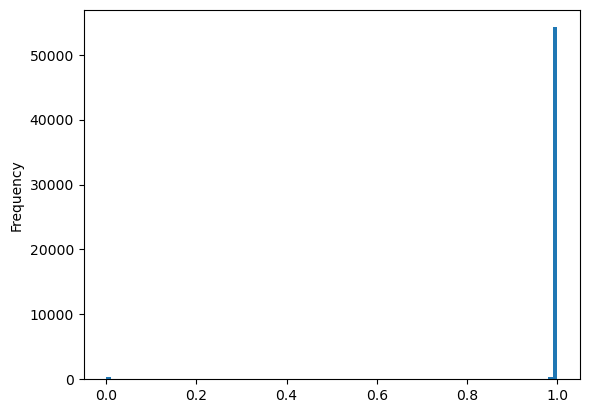

In [28]:
df[df['test_class'] == 1]['DITTO'].plot.hist(bins=100)

In [29]:
df['class'].unique()

array(['high_impact', 'low_impact'], dtype=object)

In [5]:
default_colors = {
    "high_impact": "#b2182b",
    "low_impact": "#3182bd",
    "VUS": "#5ab4ac",
    "Conflicts": "#d8b365",
    "Unknown": "#969696",
}

In [5]:
import seaborn as sns

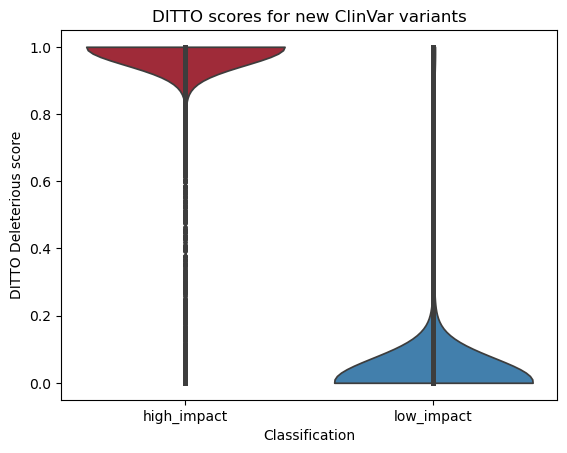

In [6]:
fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis,
# 'LMP' is y axis, data is your dataframe. ax - is axes instance
sns.violinplot(
    x="class",
    y="DITTO",
    data=df[["class", "DITTO"]],
    ax=axes,
    scale="width",
    inner="point",
    palette=default_colors,
    cut=0,
    bw=0.5,
)  # , hue="consequence_x")
axes.set_title("DITTO scores for new ClinVar variants")

# axes.yaxis.grid(True)
axes.set_xlabel("Classification")
axes.set_ylabel("DITTO Deleterious score")

plt.show()

In [33]:
df[df['test_class'] == 1]['DITTO'].mean()

0.9859410728241439

In [34]:
df[df['test_class'] == 1]['DITTO'].std()

0.10724998476662079

In [7]:
df[df['test_class'] == 1]['DITTO'].mean() - df[df['test_class'] == 1]['DITTO'].std()

0.8786910880575232

In [6]:
bench = df[['DITTO','cadd.phred','clinpred.score','metasvm.score', 'gerp.gerp_rs','spliceai','revel.score','alphamissense.am_pathogenicity']]#,'sift.score','dann.score']]
# bench.fillna(bench.median(), inplace=True)
bench.columns = ['DITTO','CADD','ClinPred','MetaSVM','GERP','spliceai','Revel','Alphamissense']#,'SIFT','DANN']
print(bench.shape)
bench.head()


(360467, 8)


DITTO  CADD  ClinPred  MetaSVM  GERP  spliceai  Revel  Alphamissense
0    1.0  33.0       NaN      NaN -7.70       NaN    NaN            NaN
1    1.0  41.0       NaN      NaN  4.77       NaN    NaN            NaN
2    1.0  23.3       NaN      NaN  1.02       NaN    NaN            NaN
3    1.0  27.6       NaN      NaN  2.75       NaN    NaN            NaN
4    1.0  38.0       NaN      NaN  4.83       NaN    NaN            NaN

In [34]:
default_colors = {
        "DANN": "#de77ae",
        "Alphamissense": "#e6308a",
        "Revel": "#542788",
        "VEST": "#5ab4ac",
        "GERP": "#d8b365",
        "MetaSVM": "#3182bd",
        "ClinPred": "#969696",
        "CADD": "#D55E00",
        "DITTO": "#b2182b",
        "spliceai": "#5ab4ac",
    }


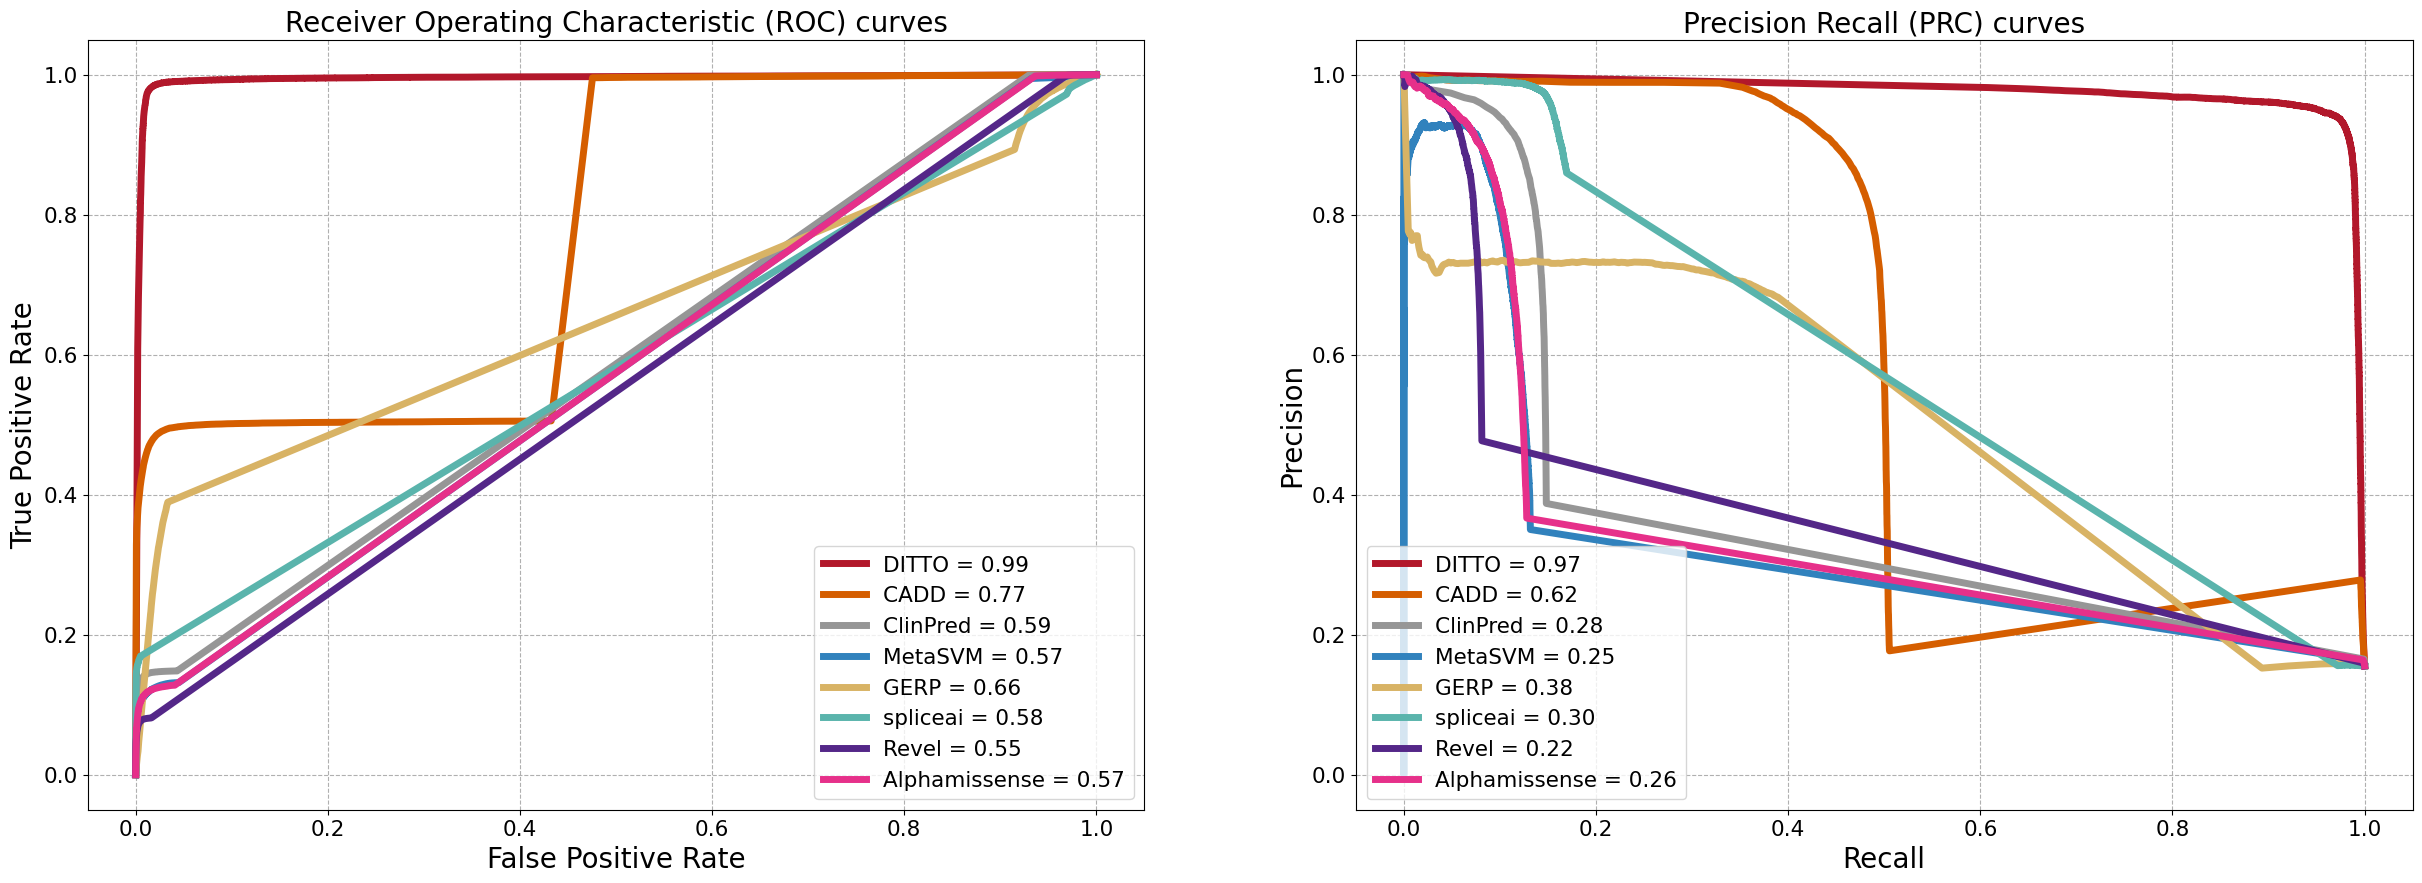

In [35]:
#bench = var[['cadd.phred','clinpred.score', 'chasmplus.score','dann.score','revel.score','metalr.score','metasvm.score','mutation_assessor.score','mutationtaster.score','sift.score','provean.score','vest.score','gerp.gerp_rs','DITTO']]
#bench.columns = ['CADD','ClinPred','chasmplus','DANN','Revel','MetaLR','MetaSVM','mutation_assessor','mutationtaster','SIFT','provean','VEST','GERP','DITTO']
Y_test = df['test_class']

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(30, 10))

# fig.suptitle(f"DITTO Benchmarking", fontsize=40)
fsize = 20
ax_roc.tick_params(axis='both', which='major', labelsize=fsize-4.5)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize-4.5)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        x = bench[name]
        x = x.fillna(x.median())
        if np.unique(x).size == 1 and name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = np.zeros_like(x)
        elif name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=5, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))
        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=5, c= default_colors[name])

# ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
# ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_prc.legend(fontsize=fsize-4.5, loc='lower left')
ax_roc.legend(fontsize=fsize-4.5)
# fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )




In [10]:
df['chrom'].value_counts()


chrom
chr2     35618
chr1     31084
chr17    21904
chr11    21535
chr19    19188
chr16    18842
chr3     18714
chr7     17961
chr5     17099
chrX     16427
chr6     16017
chr9     15885
chr12    14347
chr15    14108
chr8     12784
chr10    12666
chr4     12214
chr14    10906
chr22     7785
chr20     7278
chr13     6889
chr18     6442
chr21     4745
chrY        24
chrM         5
Name: count, dtype: int64

In [18]:
bench['consequence'].value_counts()


consequence
intron_variant                                                                                    100852
synonymous_variant                                                                                 69546
processed_transcript                                                                               31016
missense_variant                                                                                   24145
frameshift_truncation                                                                              14872
NMD_transcript_variant,3_prime_UTR_variant                                                         11809
2kb_downstream_variant                                                                              9640
stop_gained                                                                                         9403
intron_variant,NMD_transcript_variant                                                               8365
intron_variant,processed_transcript        

In [11]:
Y_test = df['test_class']
y_score = df['DITTO']

Precision: 0.9805618926801383
Recall: 0.978691530708775
ROC_AUC: 0.9940942870065363
PRC_AUC: 0.970574665647921
Accuracy: 0.978691530708775
F1_score: 0.9791397626274769
Confusion matrix:
[[297518   6934]
 [   747  55268]]


Text(0.5, 1.0, 'Confusion matrix for test variants')

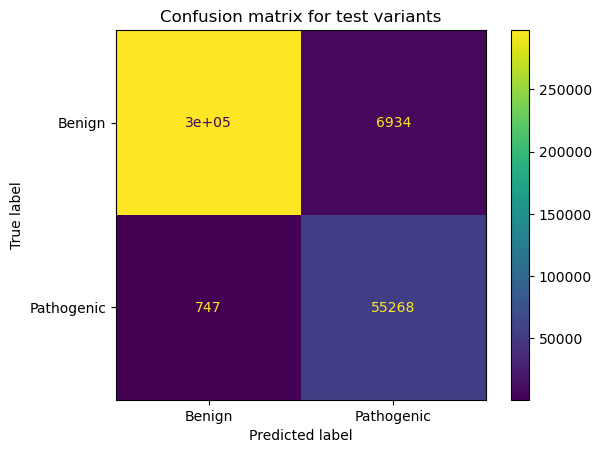

In [12]:
prc = precision_score(Y_test, y_score.round(), average="weighted")
recall = recall_score(Y_test, y_score.round(), average="weighted")
roc_auc = roc_auc_score(Y_test, y_score)
prc_auc = average_precision_score(Y_test, y_score, average="weighted")
# roc_auc = roc_auc_score(Y_test, np.argmax(y_score, axis=1))
accuracy = accuracy_score(Y_test, y_score.round())
f1 = f1_score(Y_test, y_score.round(), average="weighted")
# score = clf.score(X_train, Y_train)
matrix = confusion_matrix(Y_test, y_score.round())
cm = confusion_matrix(Y_test, y_score.round())
print(f"Precision: {prc}\nRecall: {recall}\nROC_AUC: {roc_auc}\nPRC_AUC: {prc_auc}\nAccuracy: {accuracy}\nF1_score: {f1}\nConfusion matrix:\n{matrix}")
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ 'Benign', 'Pathogenic'])
cm.plot()
plt.title(f"Confusion matrix for test variants", fontsize=12)


In [36]:
# acc_scores_chr = {}
# prc_scores_chr = {}
f1_scores_chr = {}
for name in df.chrom.unique():
    # acc_scores_chr[name] = {}
    # prc_scores_chr[name] = {}
    f1_scores_chr[name] = {}
    for clf in bench.columns:
        index_list = df[df.chrom == name].index
        x = bench[bench.index.isin(index_list)][clf]
        x = x.fillna(x.median())
        # print(clf, x.isna().sum())
        if (np.unique(x).size == 1 and clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']) or x.isna().sum() == x.size:
            x_norm = np.zeros_like(x)
        elif clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            x_norm = x

        # acc = accuracy_score(Y_test[index_list],  x_norm.round())
        # acc = "{:.2f}".format(acc)
        # acc_scores_chr[name][clf] = acc

        # prc = precision_score(Y_test[index_list],  x_norm.round())
        # prc = "{:.2f}".format(prc)
        # prc_scores_chr[name][clf] = prc

        f1 = f1_score(Y_test[index_list],  x_norm.round(), zero_division=1.0)
        f1_scores_chr[name][clf] = "{:.2f}".format(f1)

# pd.DataFrame(f1_scores_chr).to_csv("/Users/tarunmamidi/Documents/Development/DITTO-1/data/f1_scores_overall_1_transcript_chr.csv")


In [17]:
f1_scores_chr


{'chr6': {'DITTO': '0.94',
  'CADD': '0.57',
  'ClinPred': '0.18',
  'MetaSVM': '0.12',
  'GERP': '0.30',
  'spliceai': '0.28',
  'Revel': '0.11',
  'Alphamissense': '0.13'},
 'chr2': {'DITTO': '0.95',
  'CADD': '0.15',
  'ClinPred': '0.21',
  'MetaSVM': '0.18',
  'GERP': '0.29',
  'spliceai': '0.25',
  'Revel': '0.12',
  'Alphamissense': '0.18'},
 'chr11': {'DITTO': '0.94',
  'CADD': '0.54',
  'ClinPred': '0.24',
  'MetaSVM': '0.18',
  'GERP': '0.30',
  'spliceai': '0.26',
  'Revel': '0.14',
  'Alphamissense': '0.18'},
 'chr17': {'DITTO': '0.94',
  'CADD': '0.47',
  'ClinPred': '0.21',
  'MetaSVM': '0.18',
  'GERP': '0.32',
  'spliceai': '0.22',
  'Revel': '0.10',
  'Alphamissense': '0.16'},
 'chr5': {'DITTO': '0.93',
  'CADD': '0.51',
  'ClinPred': '0.16',
  'MetaSVM': '0.12',
  'GERP': '0.30',
  'spliceai': '0.23',
  'Revel': '0.08',
  'Alphamissense': '0.13'},
 'chr7': {'DITTO': '0.89',
  'CADD': '0.55',
  'ClinPred': '0.24',
  'MetaSVM': '0.23',
  'GERP': '0.25',
  'spliceai': '0.

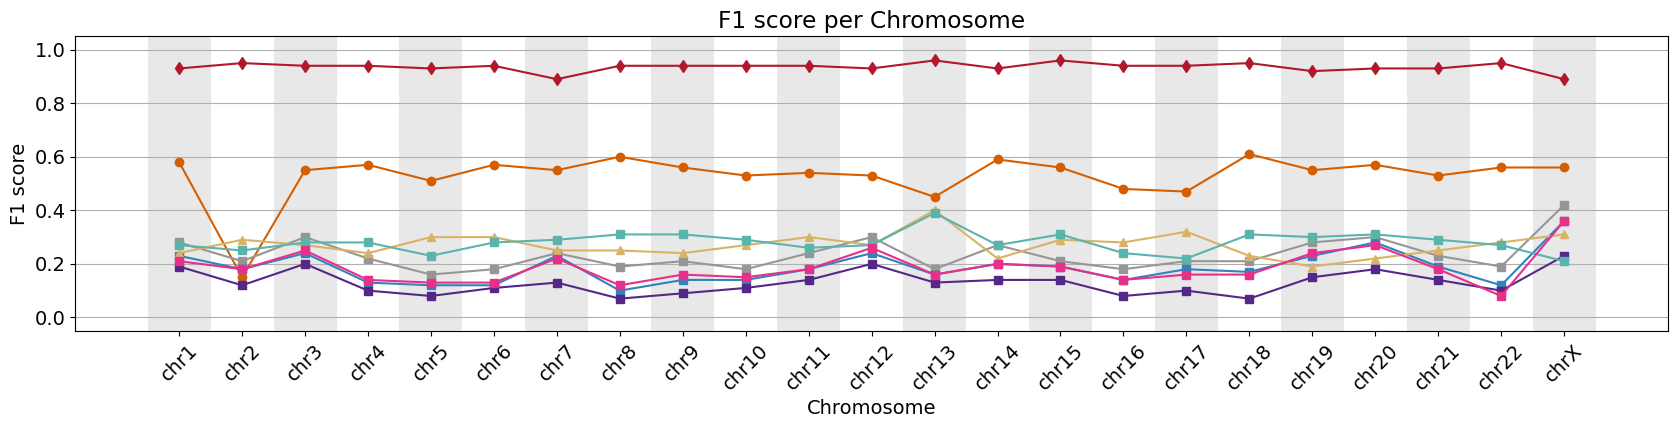

In [37]:
# Extract the chromosome names and values in the specified order
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
 'chr20', 'chr21', 'chr22', 'chrX']
CADD_values = [float(f1_scores_chr[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(f1_scores_chr[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(f1_scores_chr[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(f1_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(f1_scores_chr[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(f1_scores_chr[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(f1_scores_chr[chr]['spliceai']) for chr in chromosomes]
Alphamissense_values = [float(f1_scores_chr[chr]['Alphamissense']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 4.5))
plt.rcParams.update({'font.size': 14})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceai', linestyle='-', c= default_colors['spliceai'])
plt.plot(chromosomes, Alphamissense_values, marker='s', label='Alphamissense', linestyle='-', c= default_colors['Alphamissense'])

plt.xlabel('Chromosome')
plt.ylabel('F1 score')
plt.title('F1 score per Chromosome')
# plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()


In [19]:
df['so'] = df['consequence'].map(var_dict)
df['so1'] = df['so']

In [20]:
df['so'].unique()

array(['other RNA', 'stop gained', 'frameshift truncation', nan,
       'frameshift elongation', 'splice site', 'intron', '5 prime UTR',
       'missense', 'synonymous', 'start lost', '3 prime UTR',
       'intergenic', 'inframe deletion', 'complex substitution', 'other',
       'stop lost', 'exon loss variant', 'inframe insertion',
       'stop retained', 'start retained'], dtype=object)

In [49]:
def f1plot(var_type):
    print(f"Accuracy: {accuracy_score(df[df['so'] == var_type]['test_class'],  df[df['so'] == var_type]['DITTO'].round())}")
    chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
    # acc_scores_chr = {}
    # prc_scores_chr = {}
    f1_scores_chr = {}
    for name in df['chrom'].unique():
        # acc_scores_chr[name] = {}
        # prc_scores_chr[name] = {}
        f1_scores_chr[name] = {}
        for clf in bench.columns:
            index_list = df[(df['chrom'] == name) & (df['so'] == var_type)].index
            x = bench[bench.index.isin(index_list)][clf]
            x = x.fillna(x.median())
            if np.unique(x).size != 0:
                if (np.unique(x).size == 1 and clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']) or x.isna().sum() == x.size:
                    x_norm = np.zeros_like(x)
                elif clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
                    x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
                else:
                    x_norm = x
                # acc = accuracy_score(df[df.index.isin(index_list)]['test_class'],  x_norm.round())
                # acc = "{:.2f}".format(acc)
                # acc_scores_chr[name][clf] = acc
                # prc = precision_score(df[df.index.isin(index_list)]['test_class'],  x_norm.round())
                # prc = "{:.2f}".format(prc)
                # prc_scores_chr[name][clf] = prc
                f1 = f1_score(df[df.index.isin(index_list)]['test_class'], x_norm.round(), zero_division=0.0)
                f1_scores_chr[name][clf] = "{:.2f}".format(f1)
            else:
                f1_scores_chr[name][clf] = 0

    # pd.DataFrame(f1_scores_chr)[chromosomes].to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO-1/data/f1_scores_{var_type}_chr.csv")
    #pd.DataFrame(acc_scores_chr).to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO/data/processed/accuracy_scores_{var_type}_chr_1_transcript.csv")
    #pd.DataFrame(prc_scores_chr).to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO/data/processed/precision_scores_{var_type}_chr_1_transcript.csv")

    var_num = df[df['so'] == var_type].shape[0]

    # Extract the chromosome names and values in the specified order
    # chromosomes = f1_scores_chr.keys()

    CADD_values = [float(f1_scores_chr[chr]['CADD']) for chr in chromosomes]
    ClinPred_values = [float(f1_scores_chr[chr]['ClinPred']) for chr in chromosomes]
    Revel_values = [float(f1_scores_chr[chr]['Revel']) for chr in chromosomes]
    MetaSVM_values = [float(f1_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
    GERP_values = [float(f1_scores_chr[chr]['GERP']) for chr in chromosomes]
    DITTO_values = [float(f1_scores_chr[chr]['DITTO']) for chr in chromosomes]
    spliceai_values = [float(f1_scores_chr[chr]['spliceai']) for chr in chromosomes]
    alphamissense_values = [float(f1_scores_chr[chr]['Alphamissense']) for chr in chromosomes]

    # Create a Manhattan-style bar plot
    plt.figure(figsize=(17, 4.5))
    plt.rcParams.update({'font.size': 12})
    plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
    plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
    plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
    plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
    plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
    plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
    plt.plot(chromosomes, spliceai_values, marker='s', label='spliceAI', linestyle='-', c= default_colors['spliceai'])
    plt.plot(chromosomes, alphamissense_values, marker='s', label='Alphamissense', linestyle='-', c= default_colors['Alphamissense'])

    plt.xlabel('Chromosome')
    plt.ylabel('F1 score')
    plt.title(f"F1 score per Chromosome for {var_type} variants ({var_num} variants)")
    plt.legend( bbox_to_anchor=(1,0.5), loc="center left")
    plt.grid(axis='y')

    # Add shaded rectangles instead of grid lines
    ax = plt.gca()
    for i in range(len(chromosomes)):
        if i % 2 == 0:  # Shade every other chromosome
            ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

    plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()


Accuracy: 0.9794595129677292


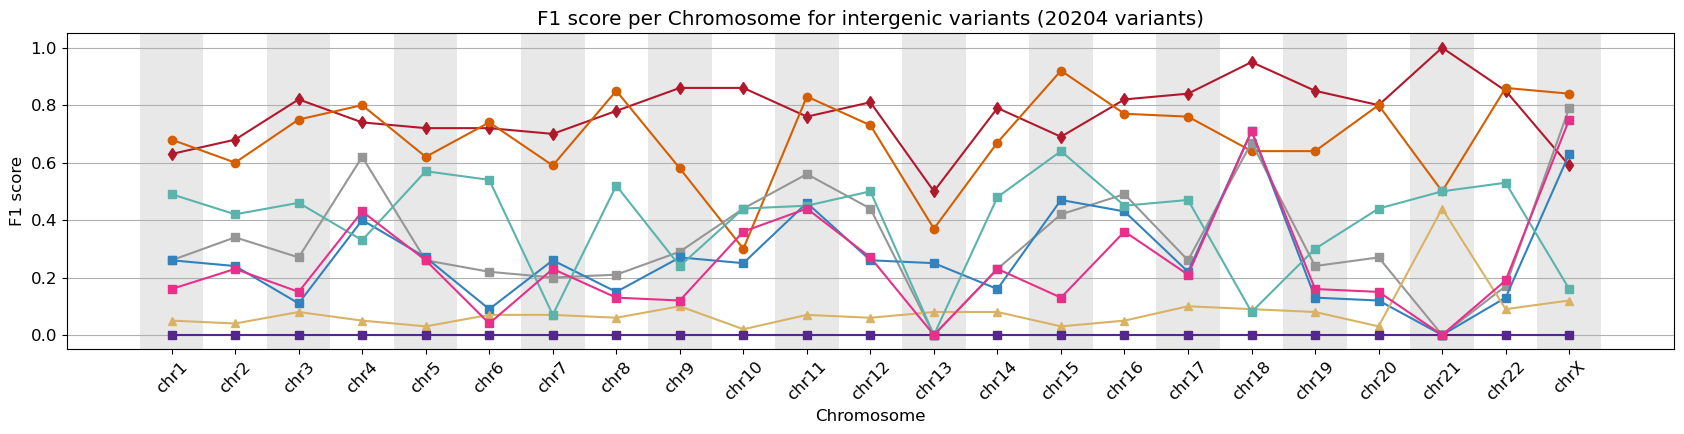

In [38]:
f1plot('intergenic')

Accuracy: 0.9047189424547916


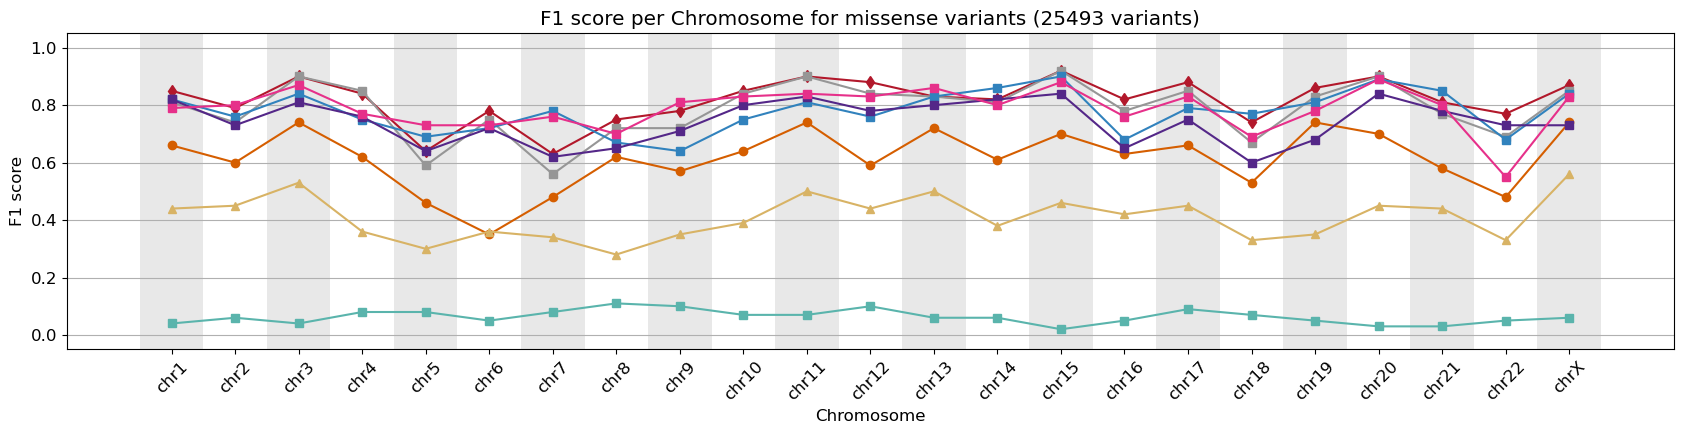

In [39]:
f1plot('missense')

Accuracy: 0.9813295615275813


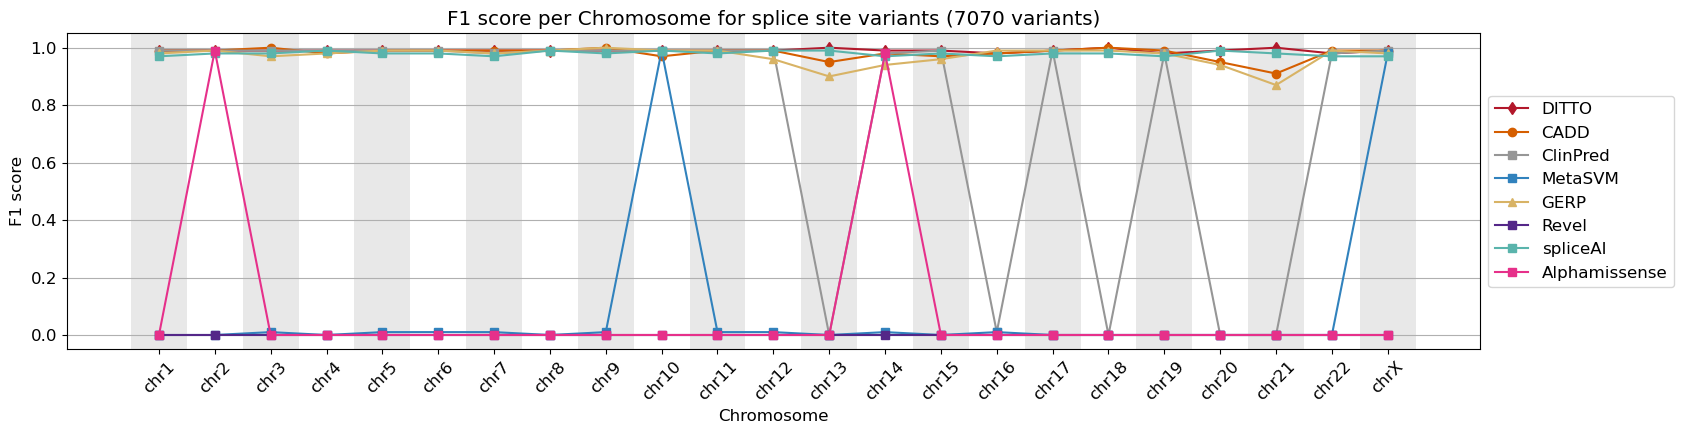

In [50]:
f1plot('splice site')

Accuracy: 0.9824561403508771


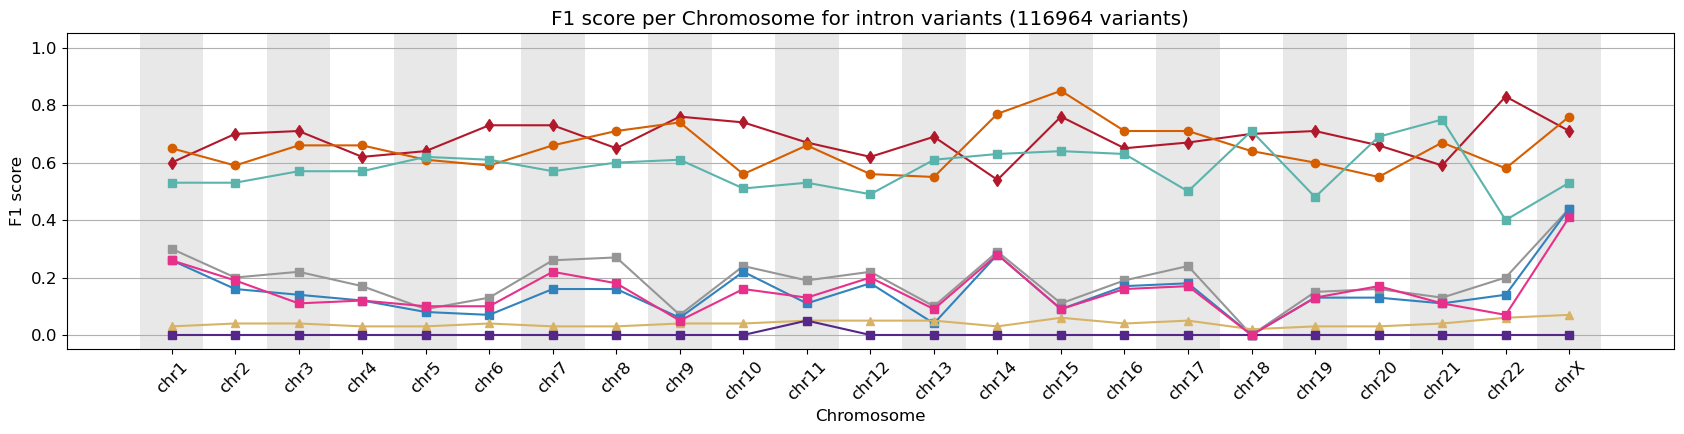

In [41]:
f1plot('intron')

In [41]:
df[df.chrom == 'chr2'].shape

(3648, 257)

<Axes: ylabel='Frequency'>

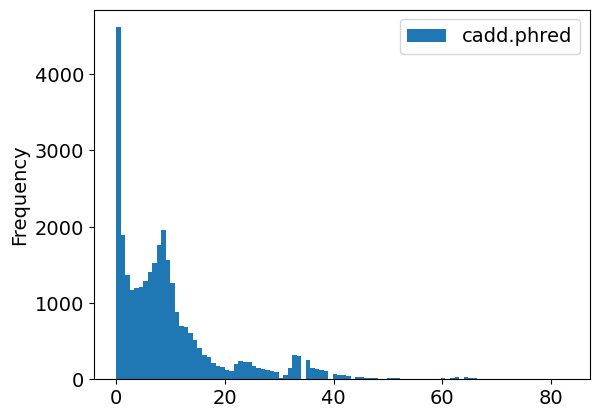

In [24]:
df[df.chrom == 'chr2'][['cadd.phred']].plot.hist(bins=100)

In [25]:
df[df.chrom == 'chr2']['class'].value_counts()

class
low_impact     29640
high_impact     5978
Name: count, dtype: int64

In [26]:
df[df.chrom == 'chr13']['class'].value_counts()

class
low_impact     5201
high_impact    1688
Name: count, dtype: int64

In [27]:
df[df.chrom == 'chr2']['consequence'].value_counts()

consequence
intron_variant                                                                  10771
synonymous_variant                                                               6646
intron_variant,lnc_RNA                                                           2551
processed_transcript                                                             2470
missense_variant                                                                 1969
frameshift_truncation                                                            1609
stop_gained                                                                       969
NMD_transcript_variant,3_prime_UTR_variant                                        845
frameshift_elongation                                                             748
lnc_RNA                                                                           745
intron_variant,splice_site_variant                                                631
2kb_upstream_variant,processed_transcript 

In [28]:
df[df.chrom == 'chr13']['consequence'].value_counts()

consequence
intron_variant                                               1840
synonymous_variant                                           1393
processed_transcript                                          683
frameshift_truncation                                         592
missense_variant                                              480
frameshift_elongation                                         292
stop_gained                                                   258
NMD_transcript_variant,3_prime_UTR_variant                    154
2kb_downstream_variant,processed_transcript                   135
intron_variant,splice_site_variant                            126
5_prime_UTR_variant                                           117
intron_variant,NMD_transcript_variant                         112
intron_variant,processed_transcript                           102
2kb_upstream_variant,processed_transcript                      72
lnc_RNA                                                        6

In [29]:
# Assuming you have a DataFrame called df with a column called 'column1'
# and a dictionary called my_dict

df['so'] = df['consequence'].map(var_dict)
df['so1'] = df['so']


In [30]:
pd.pivot_table(df,  index='so', columns='chrom', values='so1',
                          aggfunc='count').T.to_csv("/Users/tarunmamidi/Documents/Development/DITTO-1/data/new_test_var_number_type_chr.csv") #.sort_values(by=['low_impact','high_impact'], ascending=False)
#var1['chromo'] = var1['chrom']
#pd.pivot_table(var1,  index='chromo', columns='so', values='chrom',
#                          aggfunc='count')#.sort_values(by=['low_impact','high_impact'], ascending=False)


<Axes: xlabel='so'>

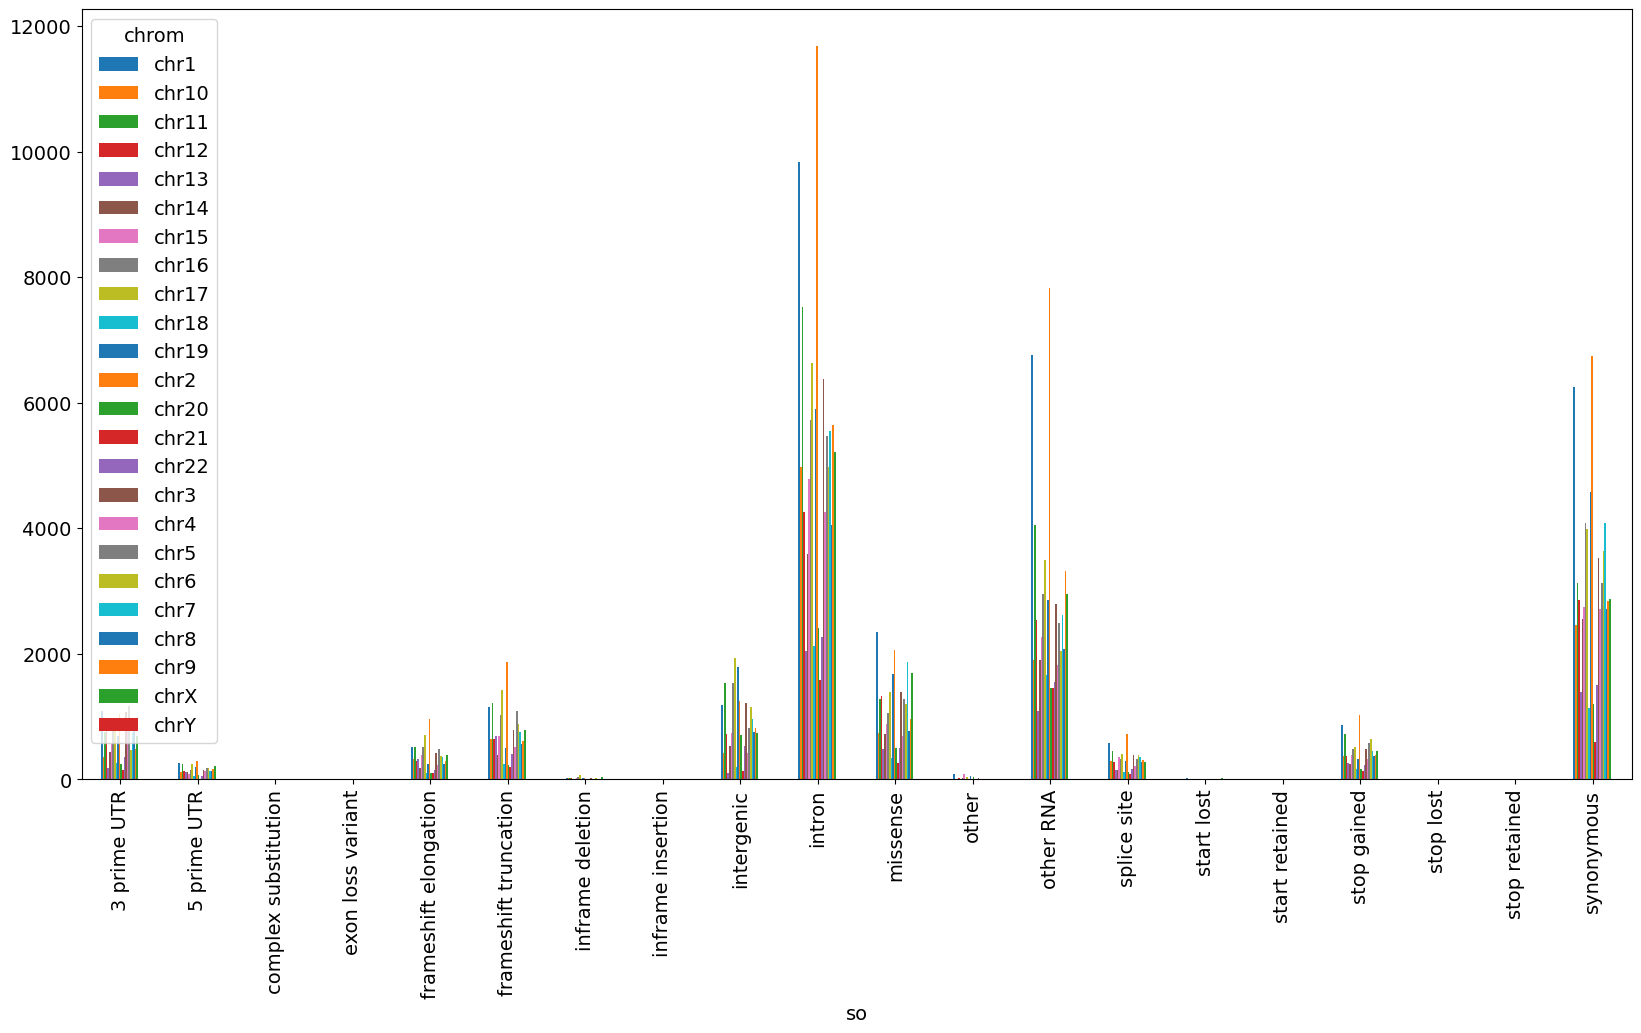

In [32]:
pd.pivot_table(var1,  index='so', columns='chrom', values='so1',
                          aggfunc='count').plot(kind='bar', figsize=(20,10), linewidth=3)


In [36]:
var1[var1['chrom']=='chr13']['clingen.disease'].value_counts()


breast-ovarian cancer, familial, susceptibility to, 2;Fanconi anemia complementation group D1    1137
Wilson disease                                                                                     70
autosomal recessive nonsyndromic deafness;syndromic genetic deafness                               26
xeroderma pigmentosum group G                                                                       9
auditory neuropathy                                                                                 8
Waardenburg syndrome type 4A;Waardenburg syndrome type 4A                                           4
nonsyndromic genetic deafness;Clouston syndrome                                                     4
Leigh syndrome                                                                                      2
factor VII deficiency                                                                               2
high myopia-sensorineural deafness syndrome                                       

Text(0.5, 1.0, 'Confusion matrix of DITTO for chr13 variants')

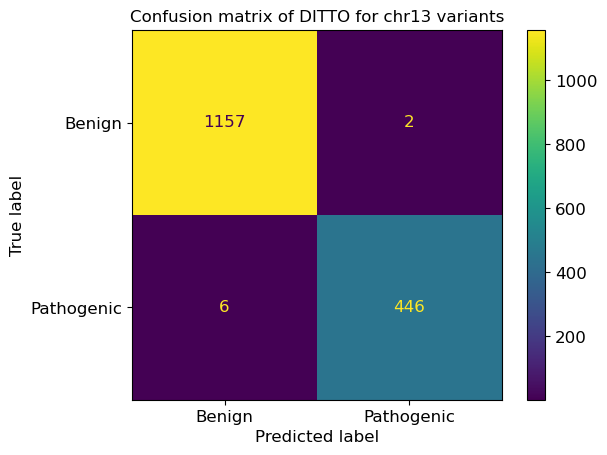

In [71]:
name = 'chr13'
clf = 'DITTO'
index_list = var1[var1.chrom == name].index
x = bench[bench.index.isin(index_list)][clf].values

cm = confusion_matrix(Y_test[index_list],x.round())
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ 'Benign', 'Pathogenic'])
cm.plot()
plt.title(f"Confusion matrix of DITTO for chr13 variants", fontsize=12)


In [77]:
var1.consequence.value_counts()


synonymous_variant                                                                  8683
intron_variant                                                                      6928
missense_variant                                                                    4066
processed_transcript                                                                2703
stop_gained                                                                         1944
frameshift_truncation                                                               1907
NMD_transcript_variant,3_prime_UTR_variant                                          1405
intron_variant,splice_site_variant                                                   919
frameshift_elongation                                                                900
intron_variant,NMD_transcript_variant                                                647
2kb_downstream_variant                                                               624
2kb_upstream_variant 

In [44]:
var_type_order = ['missense', 'stop lost','stop gained', 'start lost','synonymous', 'splice site','frameshift truncation','frameshift elongation', 'complex substitution', 'exon loss variant', 'inframe insertion','inframe deletion','intron', '3 prime UTR',  '5 prime UTR', 'other RNA','intergenic','other']


Text(0.5, 1.0, 'Confusion matrix of DITTO for intergenic variants')

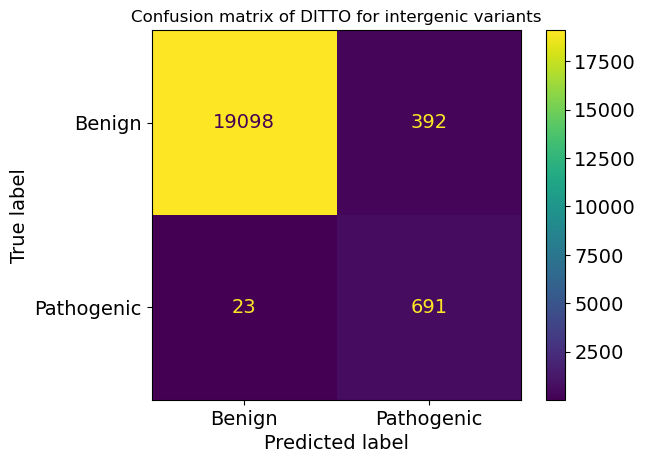

In [33]:
name = 'intergenic'
clf = 'DITTO'
index_list = df[df.so == name].index
x = bench[bench.index.isin(index_list)][clf].values

cm = confusion_matrix(Y_test[index_list],x.round())
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[ 'Benign', 'Pathogenic'])
cm.plot()
plt.title(f"Confusion matrix of DITTO for intergenic variants", fontsize=12)

In [23]:
1106+115

1221

In [25]:
1221/1240

0.9846774193548387

In [26]:
df.reset_index(drop=True, inplace=True)
bench.reset_index(drop=True, inplace=True)

In [45]:

# roc_scores = {}
# prc_scores = {}
f1_scores = {}

for consq in var_type_order:
        # roc_scores[consq] = {}
        # prc_scores[consq] = {}
        f1_scores[consq] = {}

        index_list = df[df.so == consq].index
        missense = bench[bench.index.isin(index_list)]
        missense = missense.fillna(missense.median())

        missense_y = df[df.index.isin(index_list)]['test_class'].values

        for name in list(missense.columns):
                if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
                    x_norm = (missense-np.min(missense))/(np.max(missense)-np.min(missense))
                else:
                    x_norm = missense
                # try:
                #         auc = accuracy_score(missense_y, x_norm[name].fillna(0).values)
                # except:
                #         auc=0
                # roc_scores[consq][name] = round(auc,2)
                # try:
                #         prc = precision_score(missense_y, x_norm[name].fillna(0).values)
                # except:
                #         prc=0
                # prc_scores[consq][name] = round(prc,2)
                try:
                        f1 = f1_score(missense_y, x_norm[name].fillna(0).values.round(), zero_division=1.0)
                except:
                        f1=0
                f1_scores[consq][name] = round(f1,2)

#pd.DataFrame(roc_scores).to_csv("/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO4NF/data/processed/tuning/NN_roc_scores.csv")
#pd.DataFrame(prc_scores).to_csv("/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO4NF/data/processed/tuning/NN_prc_scores.csv")
# pd.DataFrame(f1_scores).to_csv("/Users/tarunmamidi/Documents/Development/DITTO-1/data/f1_scores_type_overall_1_transcript.csv")


In [30]:
f1_scores


{'missense': {'DITTO': 0.82,
  'CADD': 0.71,
  'ClinPred': 0.79,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.06,
  'Revel': 0.75,
  'Alphamissense': 0.8},
 'stop lost': {'DITTO': 0.85,
  'CADD': 0.53,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.67,
  'Revel': 0.0,
  'Alphamissense': 0.0},
 'stop gained': {'DITTO': 0.99,
  'CADD': 0.94,
  'ClinPred': 0.99,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.06,
  'Revel': 0.0,
  'Alphamissense': 0.0},
 'start lost': {'DITTO': 0.98,
  'CADD': 0.97,
  'ClinPred': 0.97,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.01,
  'Revel': 0.86,
  'Alphamissense': 0.02},
 'synonymous': {'DITTO': 0.52,
  'CADD': 0.31,
  'ClinPred': 0.15,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.39,
  'Revel': 0.0,
  'Alphamissense': 0.16},
 'splice site': {'DITTO': 0.99,
  'CADD': 0.99,
  'ClinPred': 0.99,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.98,
  'Revel': 0.0,
  'Alphamissense': 0.0},
 'frameshift truncation': {'DITT

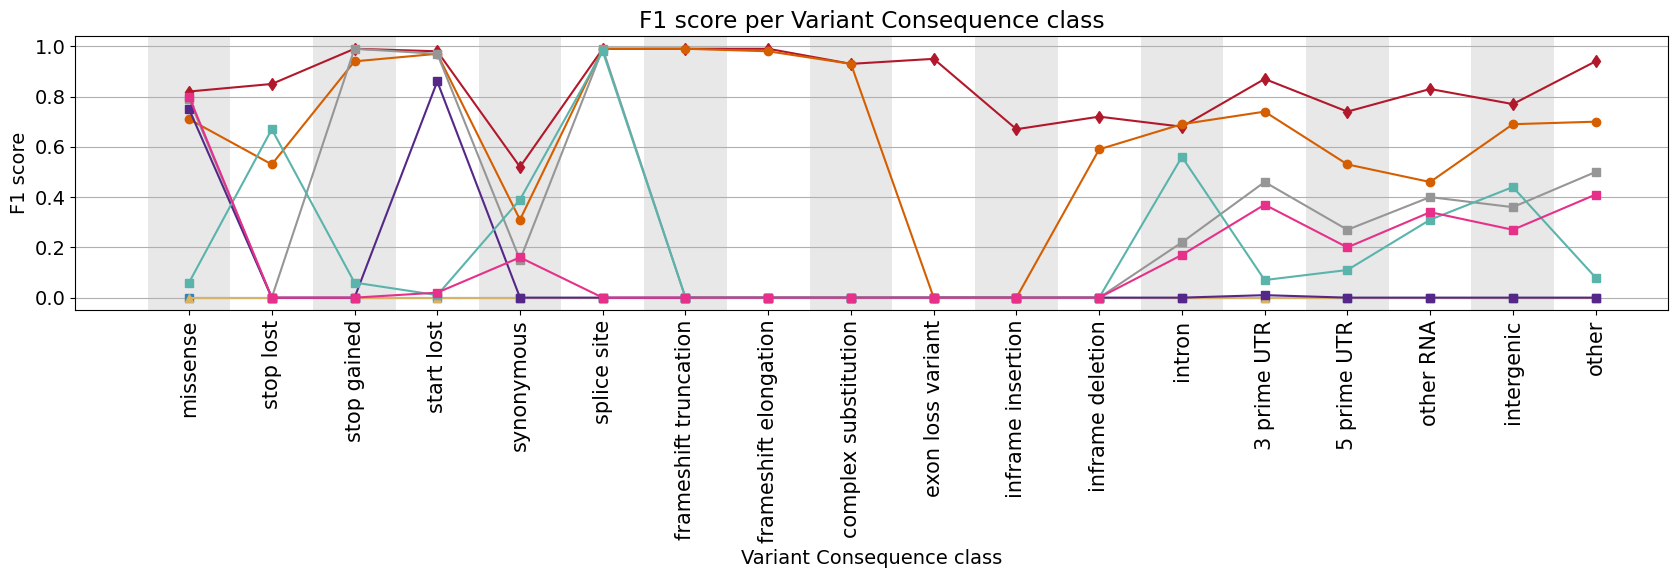

In [46]:
# Extract the chromosome names and values in the specified order
chromosomes = f1_scores.keys()
CADD_values = [float(f1_scores[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(f1_scores[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(f1_scores[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(f1_scores[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(f1_scores[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(f1_scores[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(f1_scores[chr]['spliceai']) for chr in chromosomes]
Alphamissense_values = [float(f1_scores[chr]['Alphamissense']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 6))
plt.rcParams.update({'font.size': 14})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceAi', linestyle='-', c= default_colors['spliceai'])
plt.plot(chromosomes, Alphamissense_values, marker='s', label='Alphamissense', linestyle='-', c= default_colors['Alphamissense'])

plt.xlabel('Variant Consequence class')
plt.ylabel('F1 score')
plt.title('F1 score per Variant Consequence class')
#plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=90, fontsize = 15)  # Set x-axis labels
#plt.gca().set_xticklabels(var_type_order)
plt.tight_layout()
plt.show()


In [76]:
var1[var1['so'].isin(['start retained', 'stop retained'])][['consequence','so','DITTO','cadd.phred','spliceai','gene','protein_hgvs','cdna_hgvs','chrom','pos','ref_base','alt_base','transcript','clingen.classification','class']]


consequence              so         DITTO  cadd.phred   
11729  start_retained_variant  start retained  2.516013e-02       9.129  \
25154   stop_retained_variant   stop retained  5.960464e-08       6.865   
30215   stop_retained_variant   stop retained  0.000000e+00       4.401   
31259   stop_retained_variant   stop retained  0.000000e+00       6.762   
35592   stop_retained_variant   stop retained  0.000000e+00       7.377   
35803   stop_retained_variant   stop retained  0.000000e+00       8.260   

       spliceai      gene protein_hgvs  cdna_hgvs  chrom        pos ref_base   
11729    0.0004      DOLK      p.Met1=     c.1dup   chr9  128947303        -  \
25154    0.0004      REST    p.Ter315=   c.944A>G   chr4   56932151        A   
30215    0.0004   SLC26A2    p.Ter740=  c.2220A>G   chr5  149981813        A   
31259    0.0004      GM2A    p.Ter194=   c.582A>G   chr5  151267451        A   
35592    0.0004  CEACAM16    p.Ter426=  c.1278A>G  chr19   44710506        A   
35803    0.0004   BLOC1S3    p.Ter203=   c.609G>A  chr19   45179905        G   

      alt_base       transcript clingen.classification  class  
11729        T  ENST00000372586                    NaN      0  
25154        G  ENST00000622863                    NaN      0  
30215        G  ENST00000286298                    NaN      0  
31259        G  ENST00000357164                    NaN      0  
35592        G  ENST00000587331               Moderate      0  
35803        A  ENST00000587722                    NaN      0

In [42]:
print(var1[var1['consequence'].str.contains("missense_variant")].shape)
var1[var1['consequence'].str.contains("missense_variant")].chrom.value_counts()


(4376, 256)


chr1     405
chr2     329
chr17    320
chrX     298
chr12    296
chr3     252
chr19    249
chr11    249
chr16    188
chr15    186
chr7     185
chr6     176
chr5     173
chr9     169
chr10    144
chr4     143
chr14    123
chr8     119
chr13     99
chr22     85
chr20     75
chr18     64
chr21     49
Name: chrom, dtype: int64

In [47]:
bench = var1[['DITTO','clinpred.score','metasvm.score','vest.score','revel.score','cadd.phred','gerp.gerp_rs','dann.score','spliceai','alphamissense.am_pathogenicity']]
bench.fillna(bench.mean(), inplace=True)
bench.columns = ['DITTO','ClinPred','MetaSVM','VEST','Revel','CADD','GERP','DANN','spliceai','Alphamissense']
bench.reset_index(drop=True, inplace=True)


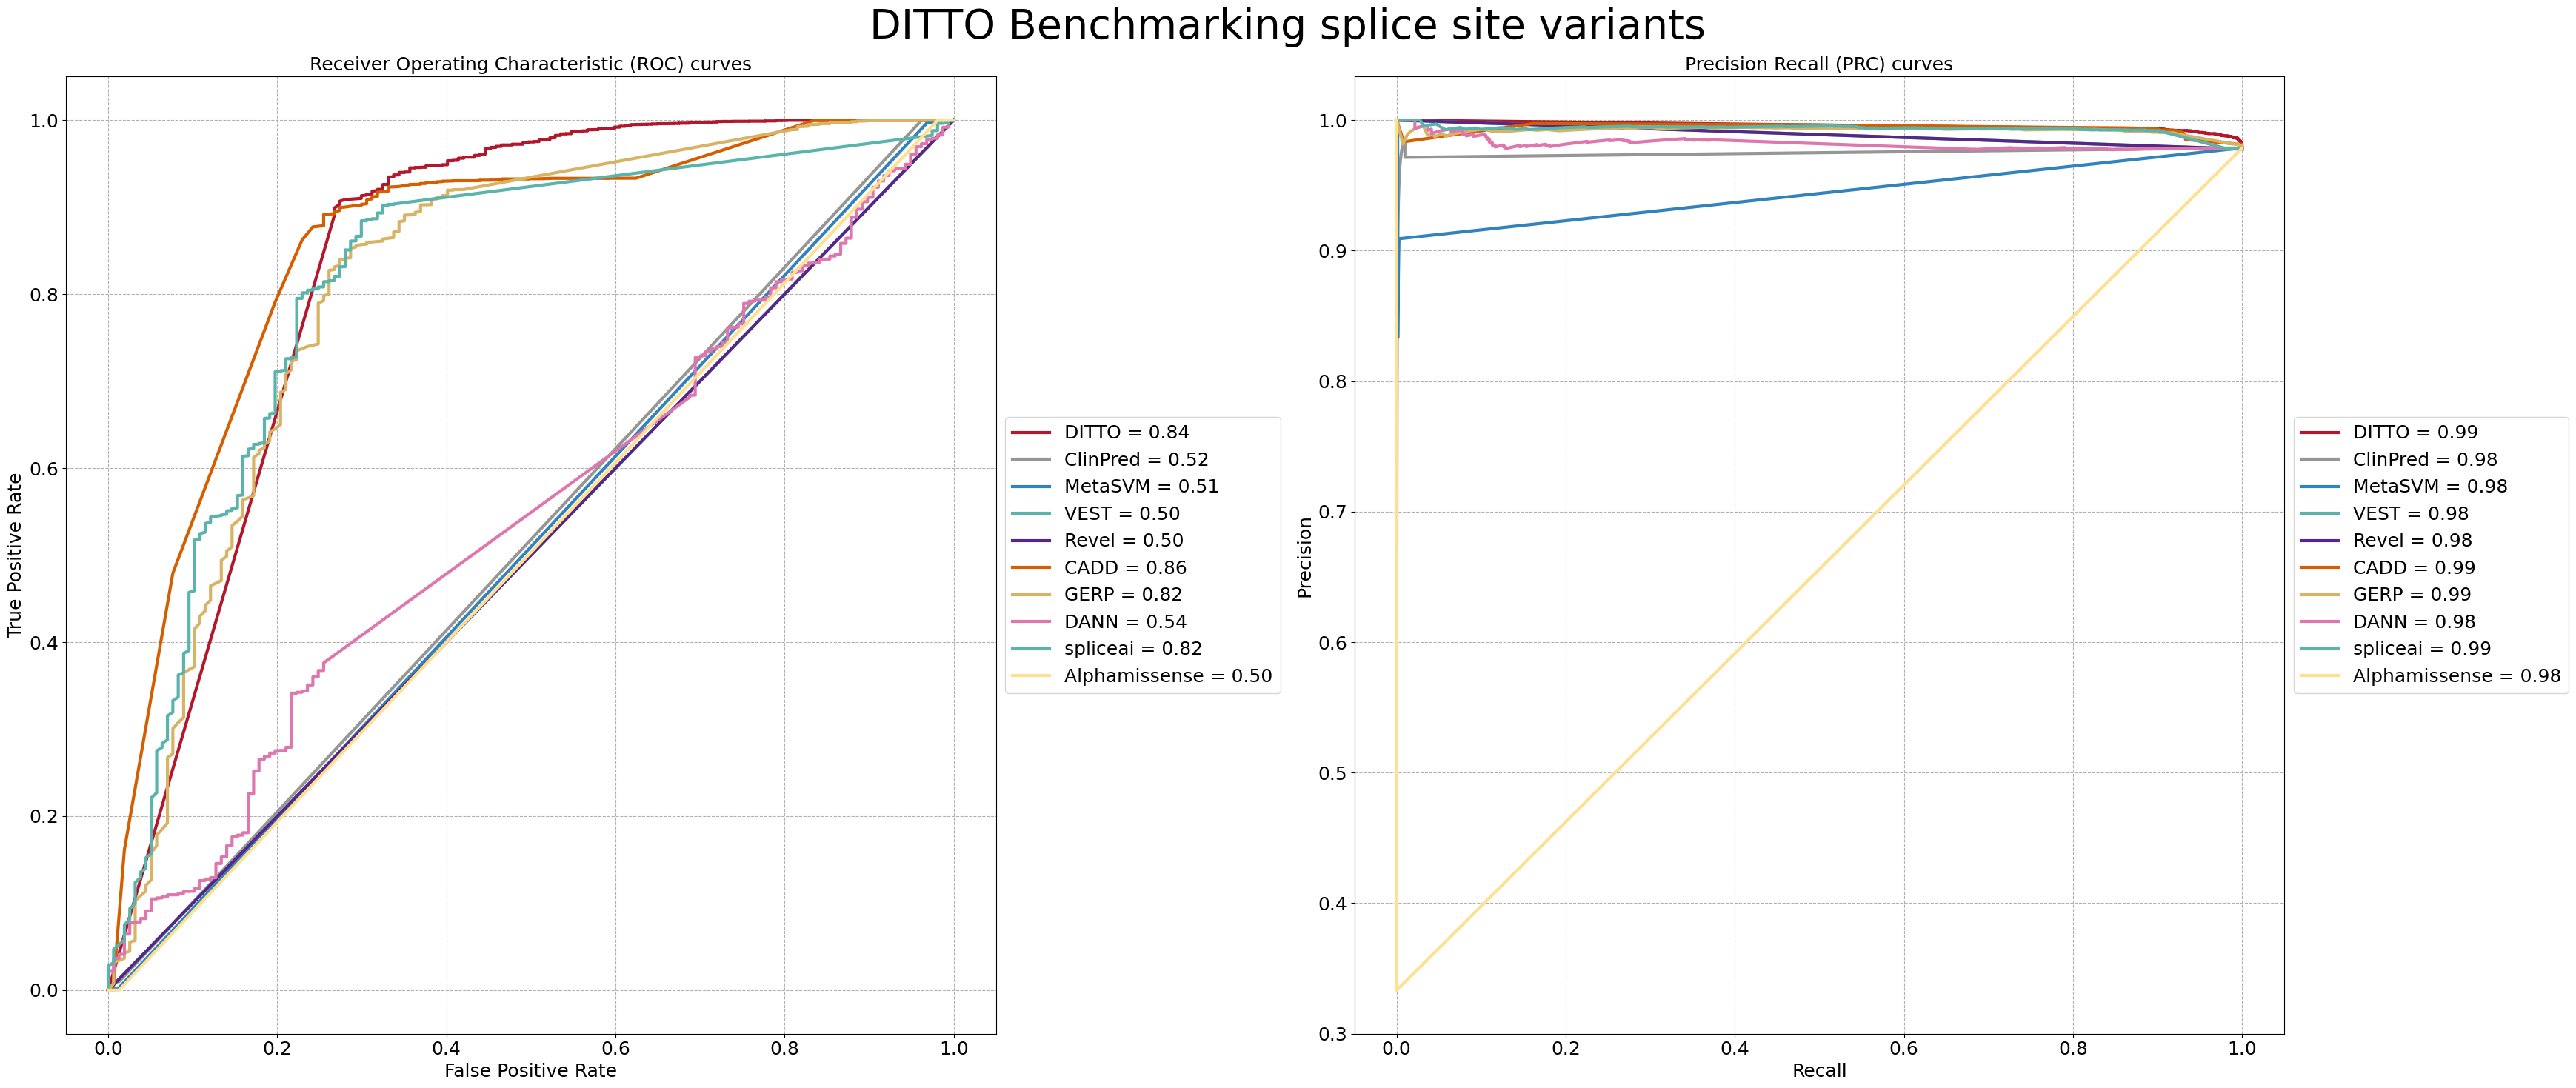

In [51]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(35, 15))

fig.suptitle(f"DITTO Benchmarking splice site variants", fontsize=40)
fsize = 18
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        index_list = var1[var1.so == 'splice site'].index
        x = bench[bench.index.isin(index_list)][name].values
        Y_test1 = var1[var1.index.isin(index_list)]['test_class'].values
        if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test1, y_true)
        auc = roc_auc_score(Y_test1, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=3, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test1, y_true)
        prc = average_precision_score(Y_test1, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=3, c= default_colors[name])
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


In [43]:
var1['class1'] = var1['class']


In [44]:
var1[var1['so'] == 'missense'].shape[0]

4082

In [62]:
def f1plot(var_type):
    print(f"Accuracy: {accuracy_score(var1[var1['so'] == var_type]['test_class'],  var1[var1['so'] == var_type]['DITTO'].round())}")
    chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
    acc_scores_chr = {}
    prc_scores_chr = {}
    f1_scores_chr = {}
    for name in var1.chrom.unique():
        acc_scores_chr[name] = {}
        prc_scores_chr[name] = {}
        f1_scores_chr[name] = {}
        for clf in bench.columns:
            index_list = var1[(var1.chrom == name) & (var1['so'] == var_type)].index
            x = bench[bench.index.isin(index_list)][clf].values
            # if np.unique(x).size == 1 and clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            #     x_norm = np.zeros_like(x)
            # elif clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            #     x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
            # else:
            x_norm = x

            acc = accuracy_score(var1[var1.index.isin(index_list)]['test_class'],  x_norm.round())
            acc = "{:.2f}".format(acc)
            acc_scores_chr[name][clf] = acc

            prc = precision_score(var1[var1.index.isin(index_list)]['test_class'],  x_norm.round(), average='weighted')
            prc = "{:.2f}".format(prc)
            prc_scores_chr[name][clf] = prc

            f1 = f1_score(var1[var1.index.isin(index_list)]['test_class'], x_norm.round(), zero_division=1.0, average='weighted')
            f1_scores_chr[name][clf] = "{:.2f}".format(f1)

    # pd.DataFrame(f1_scores_chr)[chromosomes].to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO-1/data/f1_scores_{var_type}_chr.csv")
    #pd.DataFrame(acc_scores_chr).to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO/data/processed/accuracy_scores_{var_type}_chr_1_transcript.csv")
    #pd.DataFrame(prc_scores_chr).to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO/data/processed/precision_scores_{var_type}_chr_1_transcript.csv")

    var_num = var1[var1['so'] == var_type].shape[0]

    # Extract the chromosome names and values in the specified order

    CADD_values = [float(f1_scores_chr[chr]['CADD']) for chr in chromosomes]
    ClinPred_values = [float(f1_scores_chr[chr]['ClinPred']) for chr in chromosomes]
    Revel_values = [float(f1_scores_chr[chr]['Revel']) for chr in chromosomes]
    MetaSVM_values = [float(f1_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
    GERP_values = [float(f1_scores_chr[chr]['GERP']) for chr in chromosomes]
    DITTO_values = [float(f1_scores_chr[chr]['DITTO']) for chr in chromosomes]
    spliceai_values = [float(f1_scores_chr[chr]['spliceai']) for chr in chromosomes]
    Alphamissense_values = [float(f1_scores_chr[chr]['Alphamissense']) for chr in chromosomes]

    # Create a Manhattan-style bar plot
    plt.figure(figsize=(17, 4.5))
    plt.rcParams.update({'font.size': 12})
    plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
    plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
    plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
    plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
    plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
    plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
    plt.plot(chromosomes, spliceai_values, marker='s', label='spliceAI', linestyle='-', c= default_colors['spliceai'])
    plt.plot(chromosomes, Alphamissense_values, marker='s', label='Alphamissense', linestyle='-', c= default_colors['Alphamissense'])

    plt.xlabel('Chromosome')
    plt.ylabel('F1 score')
    plt.title(f"F1 score per Chromosome for {var_type} variants ({var_num} variants)")
    #plt.legend()
    plt.grid(axis='y')

    # Add shaded rectangles instead of grid lines
    ax = plt.gca()
    for i in range(len(chromosomes)):
        if i % 2 == 0:  # Shade every other chromosome
            ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

    plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()


In [66]:
bench['Alphamissense'].describe()

count    360467.000000
mean          0.275925
std           0.106507
min           0.014600
25%           0.275925
50%           0.275925
75%           0.275925
max           1.000000
Name: Alphamissense, dtype: float64

In [53]:
for consq in var1.so.unique():
    print(consq)

other RNA
stop gained
frameshift truncation
nan
frameshift elongation
splice site
intron
5 prime UTR
missense
synonymous
start lost
3 prime UTR
intergenic
inframe deletion
complex substitution
other
stop lost
exon loss variant
inframe insertion
stop retained
start retained


In [44]:
for consq in var1.so.unique():
    pd.pivot_table(var1[var1['so'] == consq],  index='class', columns='chrom', values='class1',
                          aggfunc='count').to_csv(f"/Users/tarunmamidi/Documents/Development/DITTO-1/data/var_number_class_{consq}_chr.csv") #.sort_values(by=['low_impact','high_impact'], ascending=False)


In [57]:
var1[(var1['so'] == "intergenic") ]['consequence'].value_counts()

consequence
2kb_downstream_variant                           9640
2kb_upstream_variant                             6727
2kb_downstream_variant,NMD_transcript_variant    3406
2kb_upstream_variant,NMD_transcript_variant       355
2kb_upstream_variant,NSD_transcript                59
2kb_downstream_variant,NSD_transcript              17
Name: count, dtype: int64

In [167]:
var1[(var1['so'] == "intergenic") & (var1['chrom']=='chr21')][['consequence','so','DITTO','clingen.classification','class','cadd.phred','spliceai','gene','protein_hgvs','cdna_hgvs','chrom','pos','ref_base','alt_base','transcript']]

consequence          so     DITTO clingen.classification   
11255  2kb_downstream_variant  intergenic  0.051278             Definitive  \
11532  2kb_downstream_variant  intergenic  0.032473                    NaN   
13660  2kb_downstream_variant  intergenic  0.002689                    NaN   
13910  2kb_downstream_variant  intergenic  0.002124                    NaN   
15131  2kb_downstream_variant  intergenic  0.000795                    NaN   
15214  2kb_downstream_variant  intergenic  0.000741               Moderate   
15494    2kb_upstream_variant  intergenic  0.000593                    NaN   
19224  2kb_downstream_variant  intergenic  0.000025                    NaN   
33581    2kb_upstream_variant  intergenic  0.000000                    NaN   

       class  cadd.phred  spliceai     gene protein_hgvs   cdna_hgvs  chrom   
11255      0       4.872    0.0004  TMPRSS3          NaN  c.*1810C>T  chr21  \
11532      0      17.230    0.0004    ITGB2          NaN   c.*989G>A  chr21   
13660      0       9.200    0.0004   DYRK1A          NaN   c.*394C>T  chr21   
13910      0       9.559    0.0004   DYRK1A          NaN   c.*253A>G  chr21   
15131      0      17.750    0.0004   DYRK1A          NaN   c.*500A>G  chr21   
15214      0       2.017    0.0004    KCNE1          NaN  c.*1815A>G  chr21   
15494      0       5.690    0.0004     SOD1          NaN   c.-156G>C  chr21   
19224      0      21.000    0.0004  SLC19A1          NaN  c.*3457C>A  chr21   
33581      0      10.440    0.0004    CRYAA          NaN   c.-620C>T  chr21   

            pos ref_base alt_base       transcript  
11255  42380172        G        A  ENST00000398397  
11532  44907014        C        T  ENST00000397846  
13660  37512348        C        T  ENST00000398956  
13910  37512207        A        G  ENST00000398956  
15131  37512454        A        G  ENST00000398956  
15214  34447430        T        C  ENST00000399284  
15494  31659614        G        C  ENST00000389995  
19224  45512201        G        T  ENST00000311124  
33581  43169105        C        T  ENST00000398133

In [171]:
index_list = var1[(var1['consequence'] == '2kb_upstream_variant')].index
x = bench[bench.index.isin(index_list)][clf].values
f1_score(var1[var1.index.isin(index_list)]['class'], x.round())

0.912

Accuracy: 0.9794595129677292


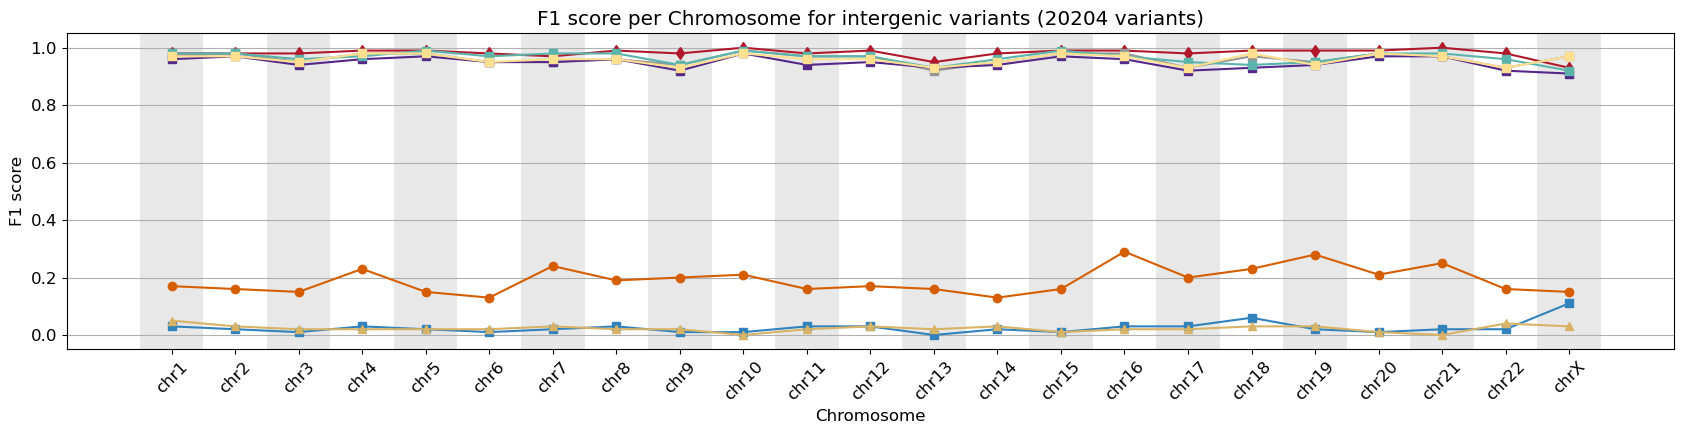

In [63]:
f1plot('intergenic')


Accuracy: 0.9047189424547916


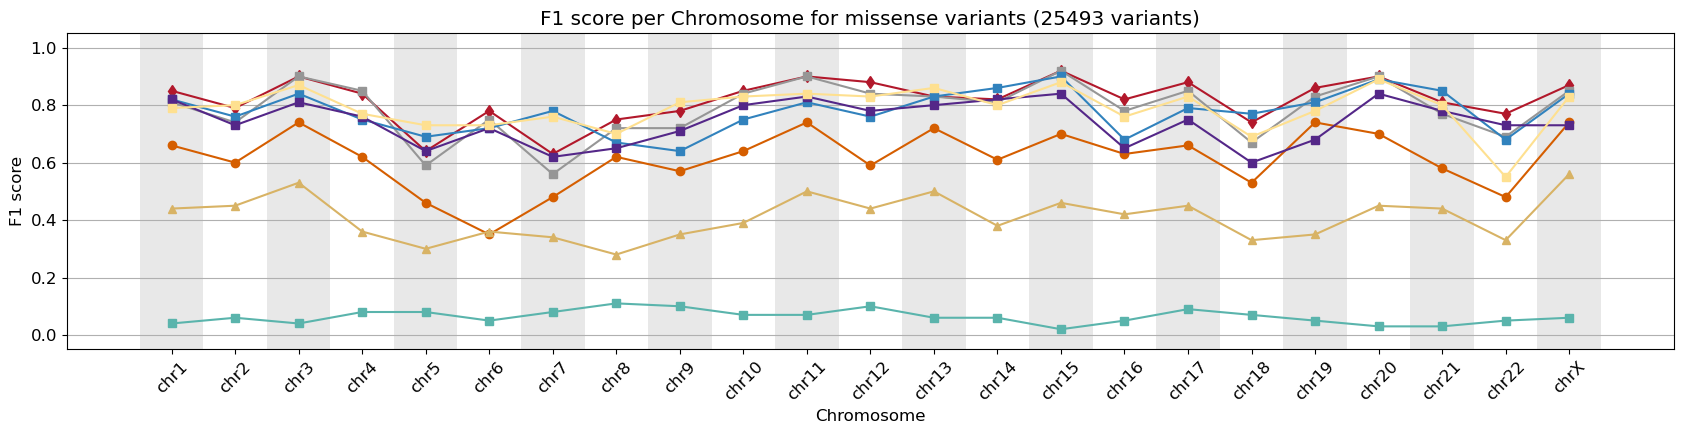

In [88]:
f1plot('missense')


Accuracy: 0.9813295615275813


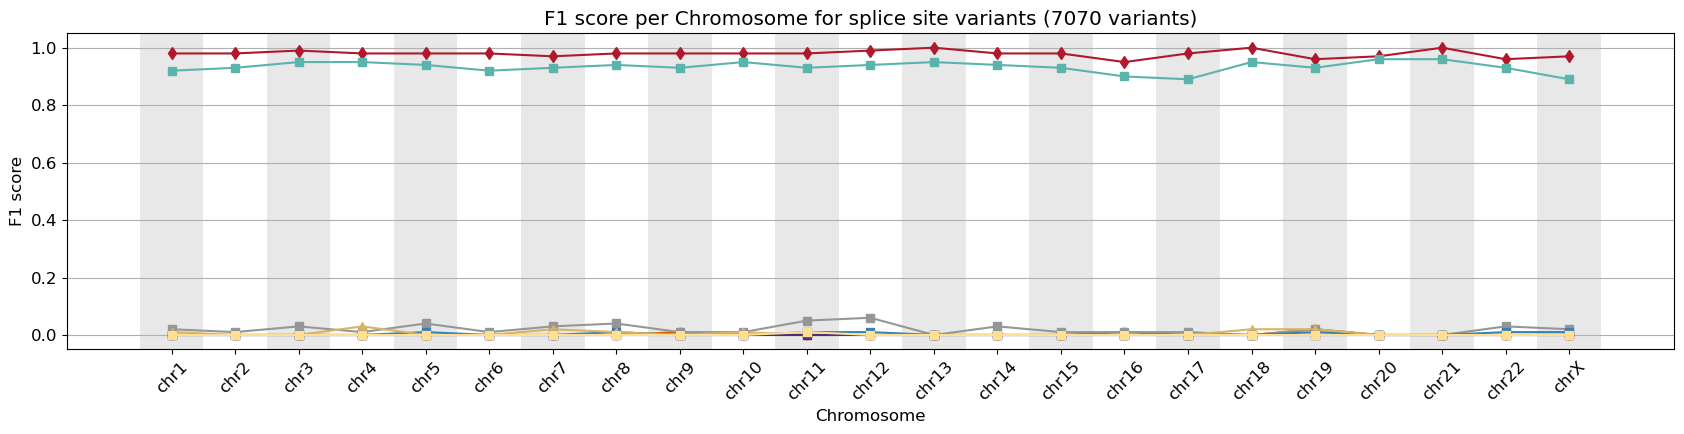

In [67]:
f1plot('splice site')


Accuracy: 0.9824561403508771


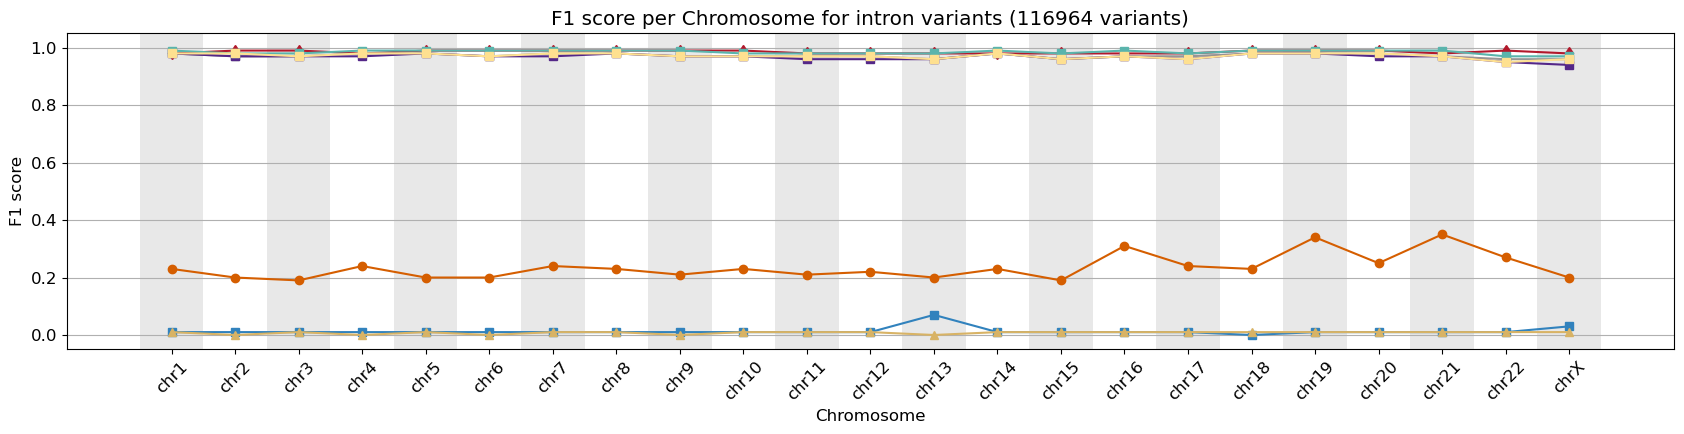

In [68]:
f1plot('intron')


Accuracy: 0.9797059019229489


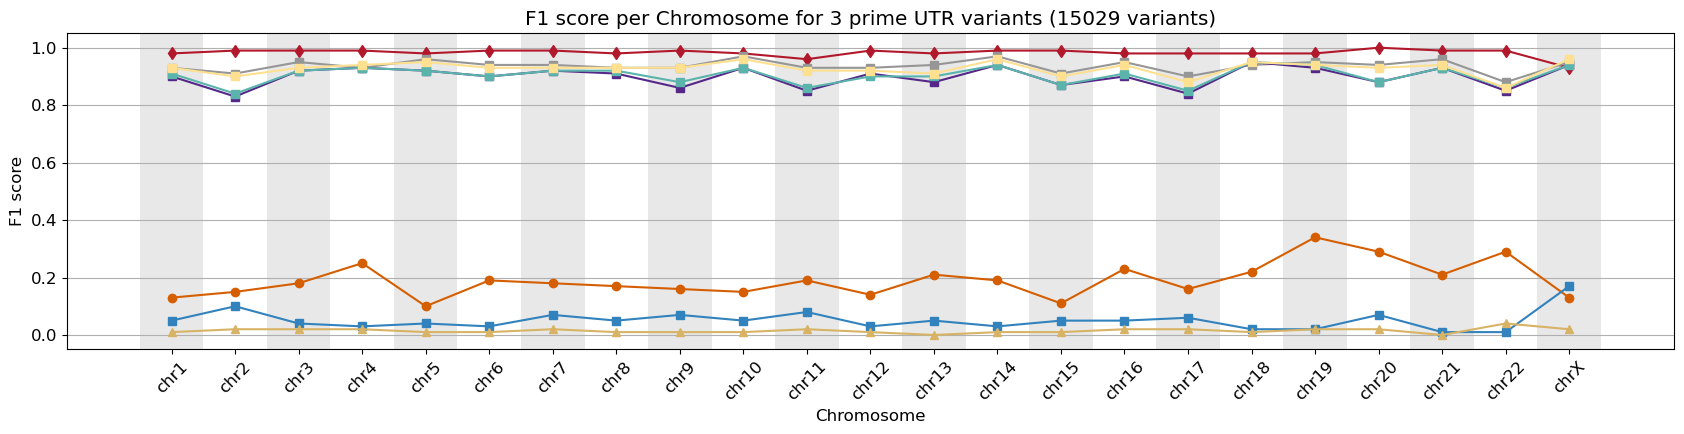

In [69]:
f1plot('3 prime UTR')

Accuracy: 0.9532871972318339


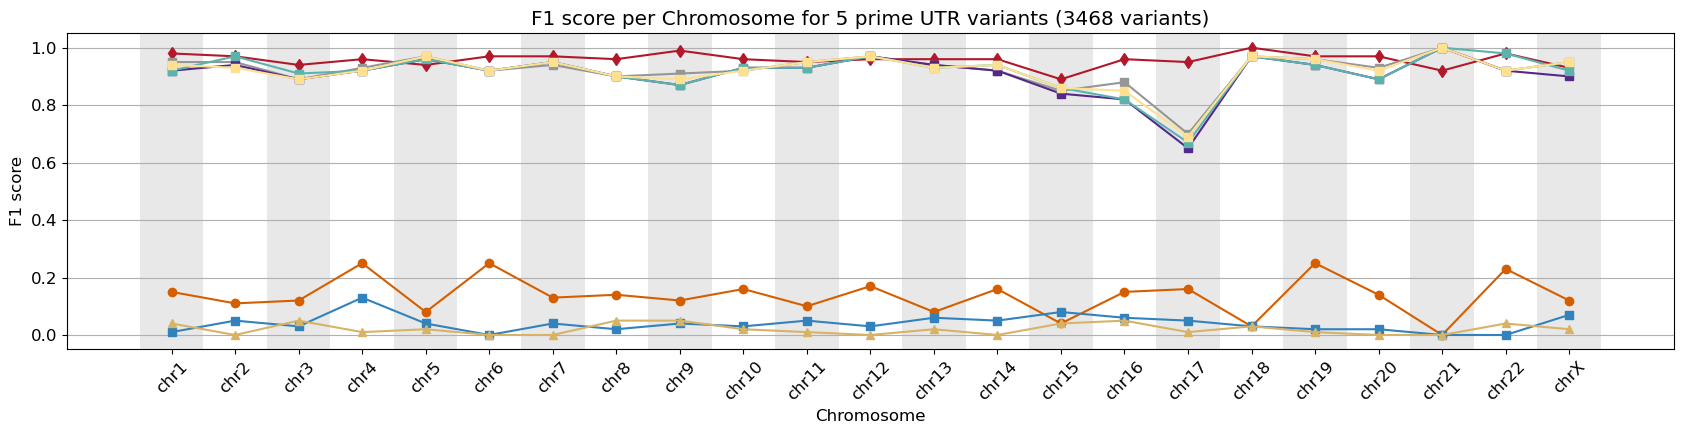

In [70]:
f1plot('5 prime UTR')

Accuracy: 0.9798687089715536


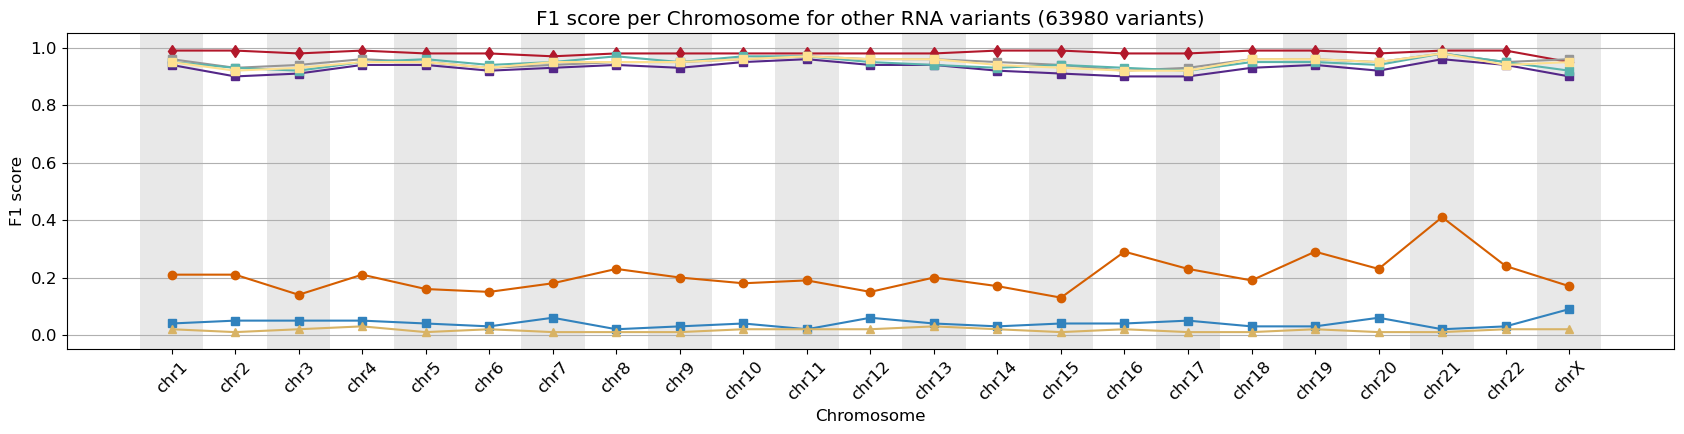

In [71]:
f1plot('other RNA')

Accuracy: 0.9802316293929713


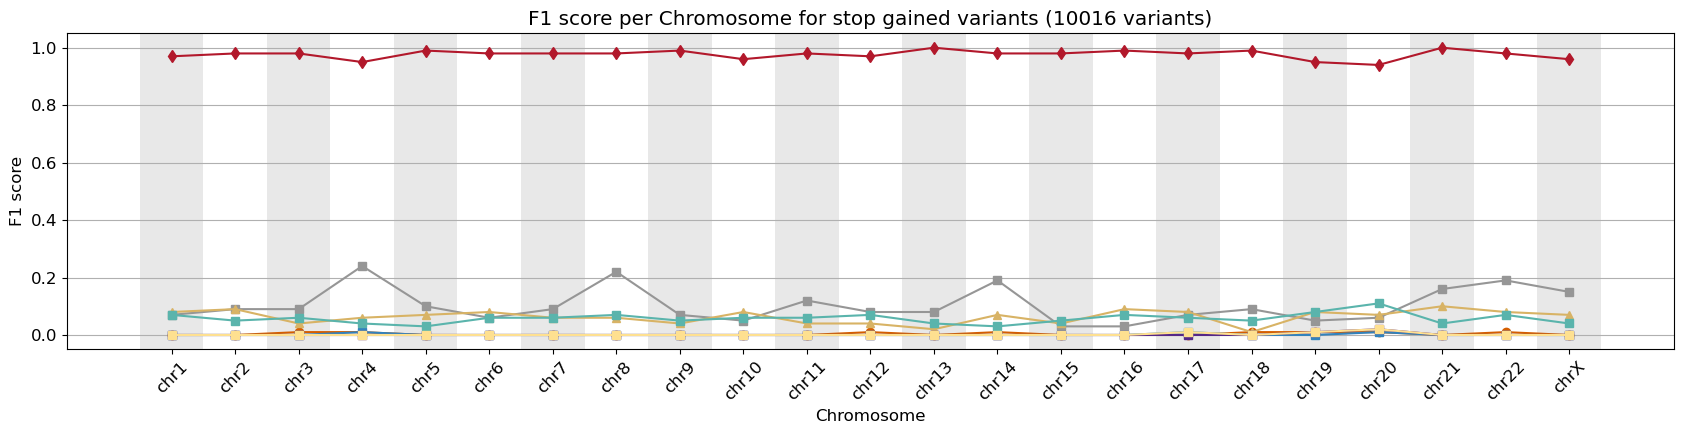

In [72]:
f1plot('stop gained')

Accuracy: 0.9985593423821697


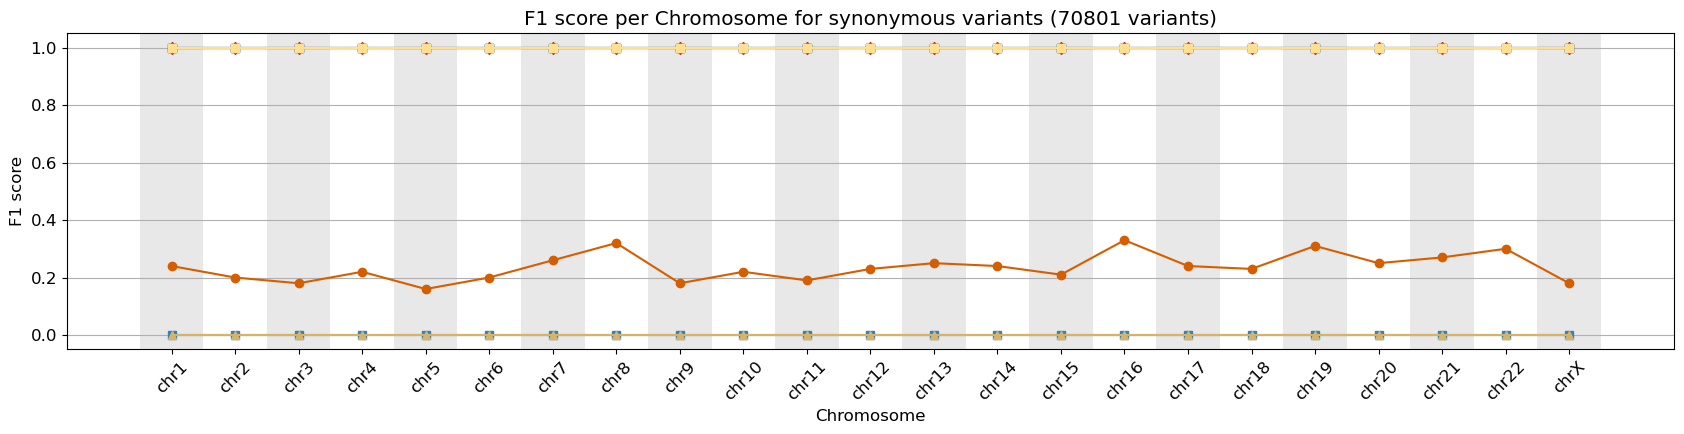

In [73]:
f1plot('synonymous')

Accuracy: 0.9864157025269096


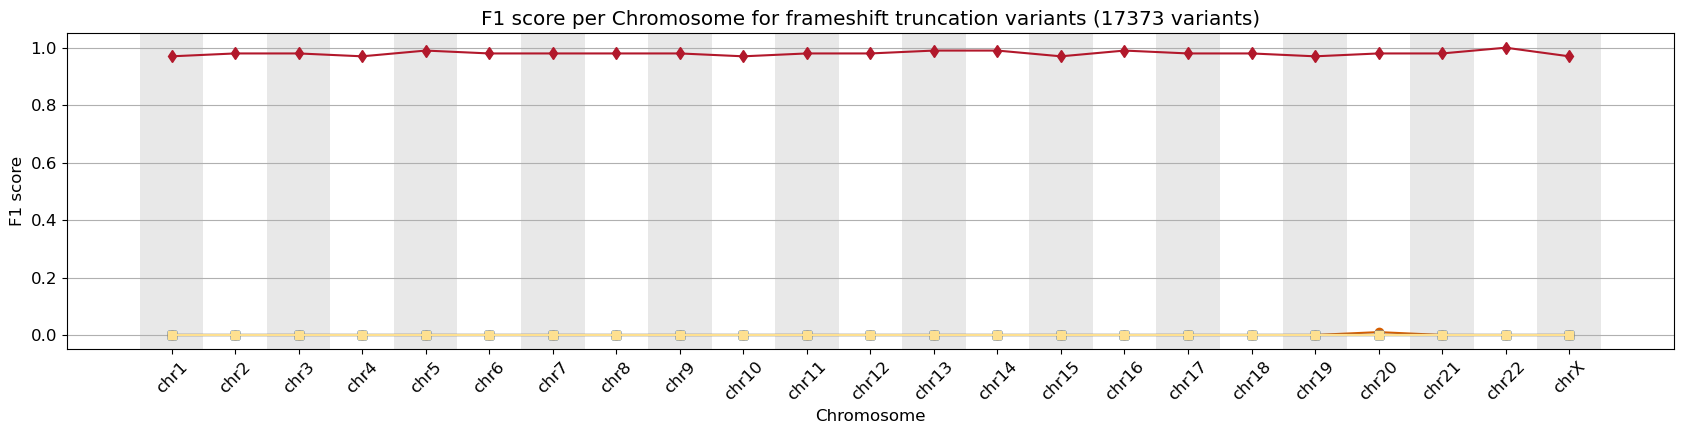

In [74]:
f1plot('frameshift truncation')

In [75]:
var1.head()

chrom       pos ref_base alt_base  alphamissense.am_pathogenicity   
0   chr6  32847960        T        A                             NaN  \
1   chr2   1889311        C        T                             NaN   
2  chr11  57600137        C        T                             NaN   
3  chr11  57600149        C        T                             NaN   
4  chr17   7907959        C        T                             NaN   

  alphamissense.am_class alphamissense.transcript_id alphamissense.uniprot_id   
0                    NaN                         NaN                      NaN  \
1                    NaN                         NaN                      NaN   
2                    NaN                         NaN                      NaN   
3                    NaN                         NaN                      NaN   
4                    NaN                         NaN                      NaN   

  alphamissense.protein_variant            extra_vcf_info.CLNREVSTAT  ...   
0                           NaN  criteria_provided,_single_submitter  ...  \
1                           NaN  criteria_provided,_single_submitter  ...   
2                           NaN  criteria_provided,_single_submitter  ...   
3                           NaN  criteria_provided,_single_submitter  ...   
4                           NaN  criteria_provided,_single_submitter  ...   

  spliceai.dp_al spliceai.dp_dg spliceai.dp_dl varity_r.varity_r_loo   
0            NaN            NaN            NaN                   NaN  \
1            NaN            NaN            NaN                   NaN   
2            NaN            NaN            NaN                   NaN   
3            NaN            NaN            NaN                   NaN   
4            NaN            NaN            NaN                   NaN   

  vest.score        class test_class spliceai           so          so1  
0        NaN  high_impact          1      NaN    other RNA    other RNA  
1      0.971  high_impact          1      NaN  stop gained  stop gained  
2      0.620  high_impact          1      NaN  stop gained  stop gained  
3      0.725  high_impact          1      NaN  stop gained  stop gained  
4      0.617  high_impact          1      NaN  stop gained  stop gained  

[5 rows x 50 columns]

In [77]:
var1['alphamissense.am_pathogenicity'].describe()

count    39112.000000
mean         0.275925
std          0.323340
min          0.014600
25%          0.069300
50%          0.099900
75%          0.333000
max          1.000000
Name: alphamissense.am_pathogenicity, dtype: float64

In [78]:
var1['alphamissense.am_pathogenicity'].median()

0.0999

In [106]:
bench = var1[['DITTO','clinpred.score','metasvm.score','vest.score','revel.score','cadd.phred','gerp.gerp_rs','dann.score','spliceai','alphamissense.am_pathogenicity','gnomad3.af']]
bench.fillna(bench.median(), inplace=True)
bench.columns = ['DITTO','ClinPred','MetaSVM','VEST','Revel','CADD','GERP','DANN','spliceai','Alphamissense','gnomad3']
bench.reset_index(drop=True, inplace=True)

In [80]:
bench['gnomad3'].describe()

count    360467.000000
mean          0.008730
std           0.038271
min           0.000007
25%           0.000070
50%           0.008730
75%           0.008730
max           1.000000
Name: gnomad3, dtype: float64

In [82]:
def f1_score_col(y_test, y_pred):
    return f1_score(y_test, y_pred, average='weighted')

In [116]:
data = {}
for af in [0.00001, 0.0005, 0.0001, 0.001, 0.1]:
    data[af] = {}
    # print(f"AF: {af}")
    # print(bench[bench['gnomad3'] < af].shape[0])
    for clf in bench.columns:
        index_list = bench[bench['gnomad3'] < af].index
        x = bench[bench.index.isin(index_list)][clf].values
        y = var1[var1.index.isin(index_list)]['test_class'].values
        data[af][clf] = f1_score_col(y, x.round())
        # print(f"{clf}: {f1_score_col(y, x.round())}")

In [84]:
data

{1e-05: {'DITTO': 0.9778732170257589,
  'ClinPred': 0.9116452811226523,
  'MetaSVM': 0.034374179335928484,
  'VEST': 0.9260754141726885,
  'Revel': 0.9097526200294402,
  'CADD': 0.22278573400512428,
  'GERP': 0.01518290486320406,
  'DANN': 0.29591855255644,
  'spliceai': 0.9282222447742702,
  'Alphamissense': 0.9120088347085973,
  'gnomad3': 0.8993379736929831},
 0.0005: {'DITTO': 0.9768501843090425,
  'ClinPred': 0.9450626779379754,
  'MetaSVM': 0.04240606752389372,
  'VEST': 0.9516746392953827,
  'Revel': 0.9464083637410984,
  'CADD': 0.2926424478668165,
  'GERP': 0.026223802247648788,
  'DANN': 0.2996808361362238,
  'spliceai': 0.957325587008881,
  'Alphamissense': 0.946449876721644,
  'gnomad3': 0.9417188173761138},
 0.0001: {'DITTO': 0.977216677228956,
  'ClinPred': 0.9387708241427997,
  'MetaSVM': 0.04039683600269539,
  'VEST': 0.9475884678531574,
  'Revel': 0.9404286579734393,
  'CADD': 0.28406890678369107,
  'GERP': 0.02382780647545591,
  'DANN': 0.2988548022932186,
  'spliceai

In [101]:
def hbar_plot(cutoff, figsize=(7, 5)):
    df1 = pd.DataFrame(data[cutoff], index=[0]).T.reset_index()
    df1.columns = ['predictors','scores']
    df1 = df1.sort_values(by='scores', ascending=True)
    plt.figure(figsize=figsize)
    bars = plt.barh(df1['predictors'], df1['scores'], color='skyblue')
    plt.xlabel('F1 score')
    plt.ylabel('Predictors')
    plt.title('F1 score for AF < ' + str(cutoff))
    plt.grid(axis='x')
    plt.xlim(0, 1)
    plt.tight_layout()
    # Adding the values on the bars
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.2f}',
                 va='center')
    plt.show()

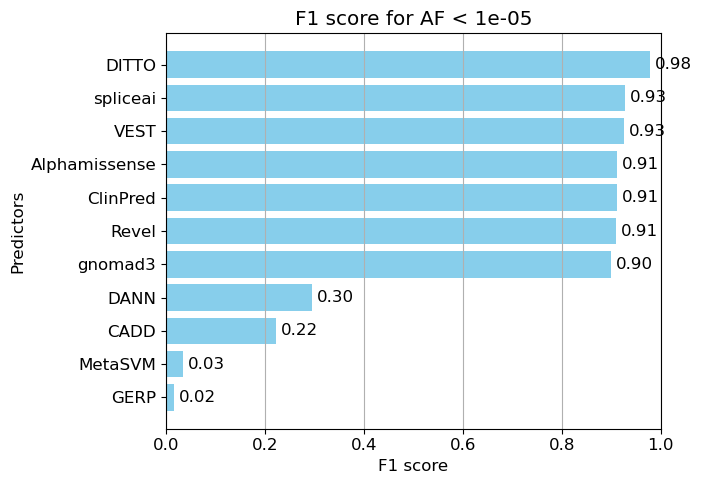

In [108]:
hbar_plot(0.00001)

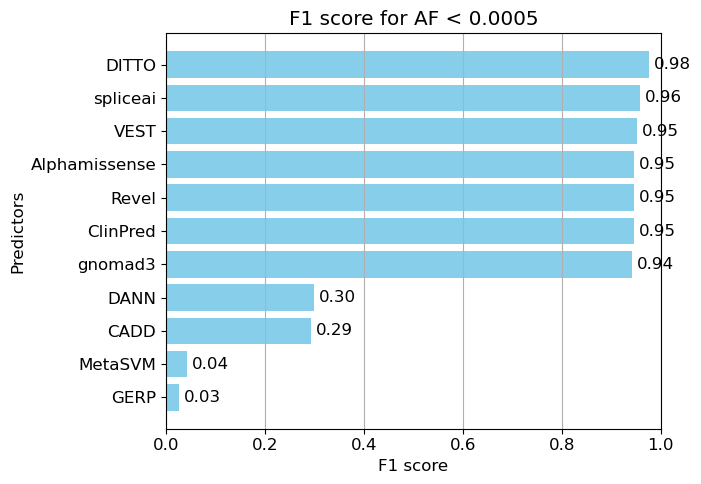

In [103]:
hbar_plot(0.0005)

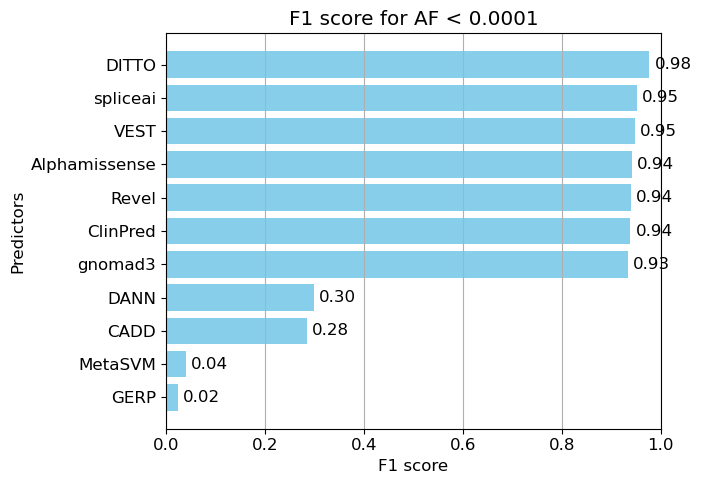

In [104]:
hbar_plot(0.0001)

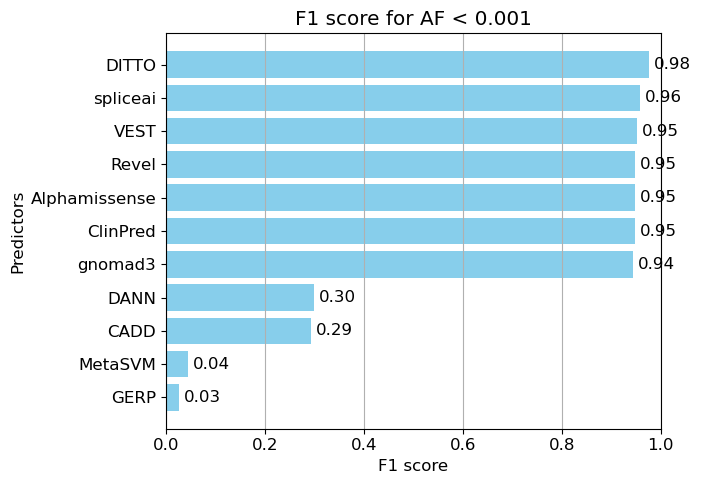

In [105]:
hbar_plot(0.001)

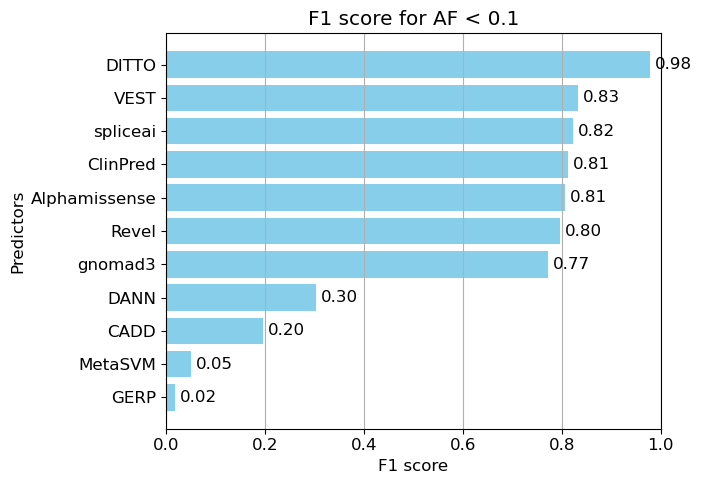

In [117]:
hbar_plot(0.1)

In [114]:
assay = var1[['DITTO','mavedb.score']]
assay.dropna(inplace=True)
print(assay.shape)
assay.head()

(58, 2)


DITTO  mavedb.score
10019    1.0      0.525551
10023    1.0      0.005760
10034    1.0      0.031064
10053    1.0     -0.051025
31671    1.0     -0.265041

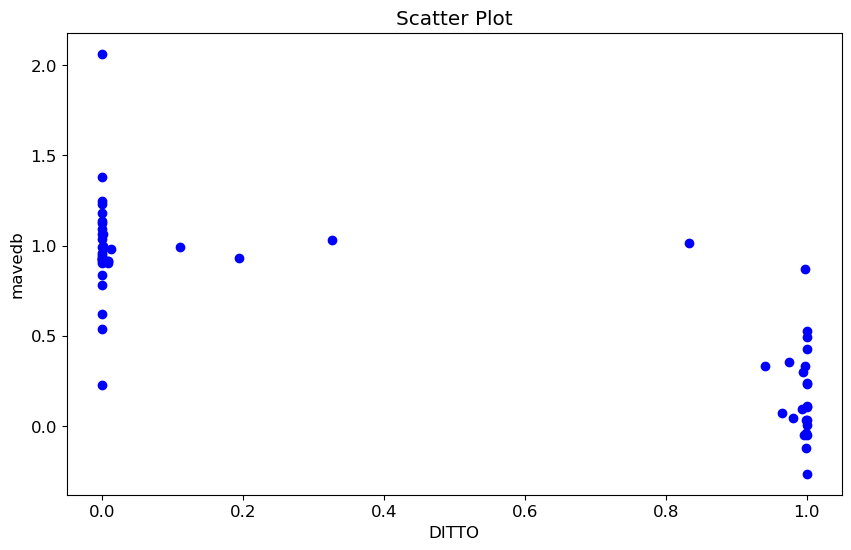

In [115]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(assay['DITTO'], assay['mavedb.score'], color='blue')
plt.xlabel('DITTO')
plt.ylabel('mavedb')
plt.title('Scatter Plot')
plt.show()

In [45]:
var1['consequence1'] = var1['consequence']
pd.pivot_table(var1[var1['so'] == "synonymous"],  index='class', columns='consequence', values='class1',
                          aggfunc='count').T


class                                         0   1
consequence                                        
NMD_transcript_variant,synonymous_variant   349   5
synonymous_variant                         8663  20

In [46]:
extra_cols = ['DITTO','class','spliceai','so','so1','class1','consequence1']


In [54]:
np.int = int

In [78]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)

missense = var1[(var1['so'] =="missense")].drop(config_dict["train_cols"]+extra_cols, axis=1).reset_index(drop=True)
print(missense.shape)
background_x = missense.loc[np.random.choice(missense.shape[0], 10, replace=False)]
shap_values = explainer.shap_values(background_x.values)
shap_values


(4311, 239)


  0%|          | 0/10 [00:00<?, ?it/s]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 1/10 [00:01<00:14,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 2/10 [00:03<00:13,  1.66s/it]

701/701 [==============================] - 1s 1ms/step


 30%|███       | 3/10 [00:04<00:11,  1.64s/it]

701/701 [==============================] - 1s 1ms/step


 40%|████      | 4/10 [00:06<00:09,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 5/10 [00:08<00:08,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 6/10 [00:09<00:06,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 70%|███████   | 7/10 [00:11<00:04,  1.61s/it]

711/711 [==============================] - 1s 1ms/step


 80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 9/10 [00:14<00:01,  1.68s/it]

699/699 [==============================] - 1s 1ms/step


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


[array([[-0.00421142, -0.00822112, -0.00901912, ...,  0.00752289,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.00909286],
        [ 0.02674645,  0.        , -0.008229  , ...,  0.        ,
         -0.00925717,  0.        ],
        ...,
        [ 0.00062232,  0.        ,  0.00086626, ..., -0.00151261,
          0.        ,  0.        ],
        [ 0.        ,  0.00092191, -0.00158519, ...,  0.00074997,
          0.        ,  0.00484408],
        [-0.01425975,  0.        , -0.01085505, ...,  0.01282208,
          0.        ,  0.        ]])]

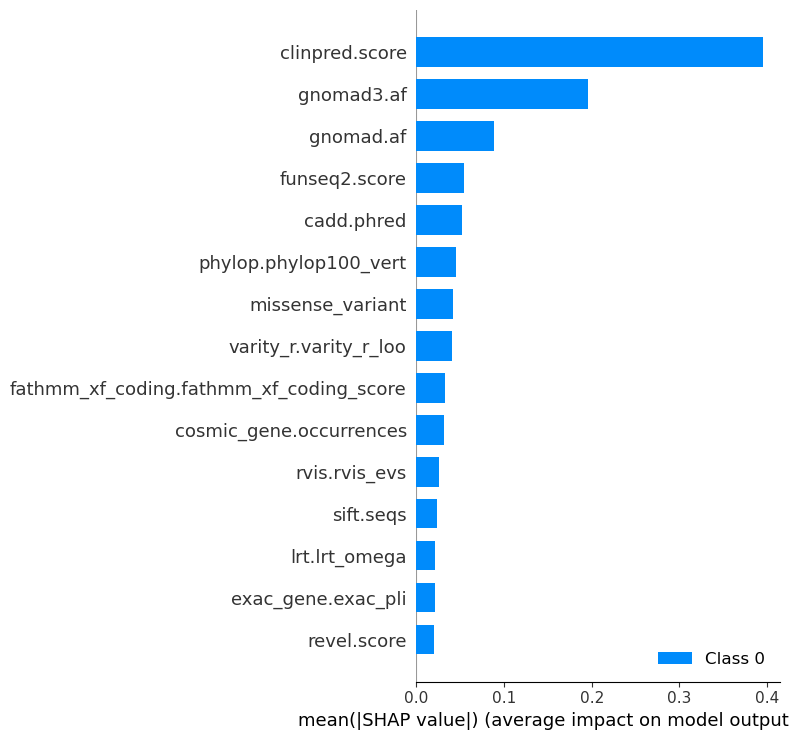

In [94]:
shap.summary_plot(shap_values, background_x, background_x.columns, max_display=15)
#plt.title("Missense variants", x=.2)
#plt.show()

In [49]:
conqs = ['missense', 'intergenic', 'splice site', 'intron', 'synonymous']


missense variant shape: (4311, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

700/700 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<13:23,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:03<13:15,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<13:17,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<13:47,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:08<14:01,  1.70s/it]

702/702 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:10<13:55,  1.69s/it]

700/700 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:11<13:50,  1.69s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:13<13:48,  1.68s/it]

702/702 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:15<13:58,  1.71s/it]

700/700 [==============================] - 1s 2ms/step


  2%|▏         | 10/500 [00:17<14:34,  1.79s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:18<13:50,  1.70s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:20<13:22,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:21<13:08,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:23<12:44,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:24<12:55,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:26<13:28,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:28<13:04,  1.62s/it]

702/702 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:29<12:53,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:31<12:39,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:32<12:45,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:34<13:03,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:36<12:41,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:37<13:00,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:39<12:47,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:40<12:35,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:42<12:27,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:44<12:21,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:45<12:20,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:47<12:07,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:48<11:59,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:50<11:57,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:51<11:52,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:53<11:52,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:54<11:52,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:56<11:53,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:57<11:53,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:59<11:50,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [01:00<11:40,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [01:02<11:35,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:03<11:35,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:05<11:37,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:06<11:29,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:08<11:34,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:09<11:42,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:11<11:39,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:13<11:44,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:14<11:33,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:16<11:27,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:17<11:21,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:19<11:25,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:20<11:18,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:22<11:18,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:23<11:13,  1.51s/it]

712/712 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:25<11:12,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:26<11:07,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:28<11:11,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:29<11:16,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:31<11:09,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:32<11:08,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:34<11:05,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:35<11:00,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:37<11:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:38<11:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:40<11:06,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:41<11:08,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:43<11:00,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:44<10:53,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:46<10:48,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:47<10:43,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:49<10:41,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:50<10:52,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:52<10:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:53<10:41,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:55<10:46,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:56<10:46,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:58<10:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [02:00<10:52,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [02:01<10:52,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [02:03<10:49,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:04<10:41,  1.53s/it]

709/709 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:06<10:37,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:07<10:39,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:09<10:33,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:10<10:27,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:12<10:22,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:13<10:58,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:15<10:43,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:16<10:32,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:18<10:45,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:20<10:35,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:21<10:28,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:23<10:30,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:24<10:35,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:26<10:23,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:27<10:16,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:29<10:10,  1.51s/it]

703/703 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:30<10:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:32<10:01,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:33<10:18,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:35<10:23,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:36<10:19,  1.55s/it]

709/709 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:38<10:12,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:39<10:06,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:41<10:01,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:42<10:02,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:44<09:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:45<09:57,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:47<09:59,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:49<10:06,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:50<10:05,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:52<10:09,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:53<10:00,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:55<09:54,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:56<09:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:58<09:51,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:59<09:46,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [03:01<09:48,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [03:02<09:43,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [03:04<09:46,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:05<09:38,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:07<09:41,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:09<09:35,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:10<09:47,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:12<09:37,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:13<09:37,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:15<09:31,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:16<09:27,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:18<09:21,  1.51s/it]

712/712 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:19<09:31,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:21<09:29,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:22<09:23,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:24<09:24,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:25<09:17,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:27<09:12,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:28<09:20,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:30<09:19,  1.54s/it]

704/704 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:31<09:13,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:33<09:07,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:35<09:11,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:36<09:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:38<09:05,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:39<08:59,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:41<08:57,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:42<08:53,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:44<08:53,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:45<08:55,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:47<08:53,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:48<08:50,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:50<08:54,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:51<08:48,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:53<08:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:54<08:42,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:56<08:49,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:57<08:50,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:59<08:50,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [04:00<08:43,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [04:02<08:39,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [04:03<08:35,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [04:05<08:49,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:06<08:47,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:08<08:39,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:09<08:32,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:11<08:28,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:12<08:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:14<08:31,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:15<08:25,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:17<08:22,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:18<08:18,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:20<08:22,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:21<08:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:23<08:22,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:25<08:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:26<08:12,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:28<08:09,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:29<08:18,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:31<08:11,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:32<08:15,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:34<08:20,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:35<08:17,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:37<08:16,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:38<08:15,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:40<08:07,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:41<08:05,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:43<08:09,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:45<08:03,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:46<07:58,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:48<07:59,  1.53s/it]

704/704 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:49<07:59,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:51<07:54,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:52<07:48,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:54<07:49,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:55<07:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:57<07:46,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:58<07:41,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [05:00<07:48,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [05:01<07:41,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [05:03<07:37,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [05:04<07:38,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [05:06<07:34,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:07<07:31,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:09<07:31,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:10<07:33,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:12<07:30,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:13<07:26,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:15<07:35,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:16<07:31,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:18<07:26,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:20<07:31,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:21<07:27,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:23<07:20,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:24<07:26,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:26<07:23,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:27<07:17,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:29<07:18,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:30<07:14,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:32<07:08,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:33<07:06,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:35<07:11,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:36<07:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:38<07:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:39<07:08,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:41<07:02,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:42<06:57,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:44<07:04,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:45<06:59,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:47<06:59,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:48<06:54,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:50<06:51,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:52<06:52,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:53<06:52,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:55<06:52,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:56<06:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [05:58<06:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [05:59<06:45,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [06:01<06:46,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [06:02<06:40,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [06:04<06:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [06:05<06:34,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:07<06:31,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:08<06:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:10<06:33,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:11<06:27,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:13<06:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:14<06:36,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:16<06:34,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:18<06:35,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:19<06:30,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:21<06:24,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:22<06:25,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:24<06:24,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:25<06:24,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:27<06:19,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:28<06:14,  1.52s/it]

725/725 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:30<06:33,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:31<06:22,  1.56s/it]

703/703 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:33<06:15,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:34<06:09,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:36<06:09,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:37<06:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:39<06:10,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:41<06:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:42<06:03,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:44<05:59,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:45<05:57,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:47<05:57,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:48<05:57,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:50<05:53,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [06:51<05:49,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [06:53<05:46,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [06:54<05:51,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [06:56<05:50,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [06:57<05:46,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [06:59<05:42,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [07:00<05:46,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [07:02<05:45,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [07:03<05:40,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [07:05<05:36,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [07:06<05:40,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:08<05:34,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:09<05:35,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:11<05:31,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:12<05:28,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:14<05:25,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:15<05:23,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:17<05:26,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:18<05:26,  1.53s/it]

713/713 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:20<05:32,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:22<05:25,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:23<05:20,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:25<05:20,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:26<05:16,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:28<05:16,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:29<05:19,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:31<05:17,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:32<05:16,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:34<05:14,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:35<05:13,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:37<05:08,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:38<05:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:40<05:04,  1.52s/it]

704/704 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:41<05:02,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:43<04:58,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:44<04:57,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:46<04:53,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:47<04:54,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:49<04:53,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [07:50<04:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [07:52<04:47,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [07:53<04:48,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [07:55<04:45,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [07:56<04:42,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [07:58<04:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [08:00<04:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [08:01<04:44,  1.53s/it]

728/728 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [08:03<04:55,  1.60s/it]

704/704 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [08:04<04:51,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [08:06<04:48,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [08:07<04:41,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:09<04:36,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:10<04:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:12<04:36,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:14<04:35,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:15<04:34,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:17<04:29,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:18<04:25,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:20<04:25,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:21<04:25,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:23<04:20,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:24<04:20,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:26<04:19,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:27<04:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:29<04:12,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:30<04:12,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:32<04:09,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:33<04:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:35<04:07,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:36<04:04,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:38<04:05,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:40<04:41,  1.75s/it]

701/701 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:42<04:27,  1.67s/it]

702/702 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:43<04:17,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:45<04:13,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:46<04:08,  1.59s/it]

701/701 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:48<04:03,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [08:49<04:07,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [08:51<04:03,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [08:52<03:57,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [08:54<03:55,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [08:55<03:51,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [08:57<03:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [08:58<03:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [09:00<03:46,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [09:01<03:42,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [09:03<03:39,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [09:04<03:39,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [09:06<03:40,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [09:08<03:36,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [09:09<03:36,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:11<03:35,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:12<03:35,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:14<03:31,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:15<03:28,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:17<03:28,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:18<03:27,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:20<03:26,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:21<03:23,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:23<03:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:24<03:22,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:26<03:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:27<03:16,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:29<03:14,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:30<03:14,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:32<03:11,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:33<03:09,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:35<03:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:36<03:09,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:38<03:07,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:39<03:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:41<03:02,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:43<03:02,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:44<03:04,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:46<03:00,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:47<02:57,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:49<02:56,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:50<02:57,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [09:52<02:54,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [09:53<02:51,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [09:55<02:49,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [09:56<02:46,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [09:58<02:46,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [09:59<02:46,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [10:01<02:43,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [10:02<02:41,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [10:04<02:40,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [10:05<02:37,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [10:07<02:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [10:08<02:36,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:10<02:34,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:11<02:34,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:13<02:32,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:15<02:34,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:16<02:30,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:18<02:29,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:19<02:26,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:21<02:27,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:22<02:25,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:24<02:22,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:25<02:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:27<02:17,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:28<02:16,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:30<02:17,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:31<02:14,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:33<02:11,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:34<02:09,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:36<02:07,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:37<02:07,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:39<02:07,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:40<02:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:42<02:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:43<02:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:45<01:59,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:46<01:58,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:48<01:56,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:49<01:53,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [10:51<01:52,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [10:52<01:50,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [10:54<01:51,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [10:56<01:50,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [10:57<01:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [10:59<01:46,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [11:00<01:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [11:02<01:42,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [11:03<01:40,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [11:05<01:39,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [11:06<01:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [11:08<01:36,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [11:09<01:34,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:11<01:33,  1.51s/it]

712/712 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:12<01:32,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:14<01:31,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:15<01:30,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:17<01:28,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:18<01:26,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:20<01:24,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:21<01:22,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:23<01:20,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:24<01:21,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:26<01:18,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:27<01:16,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:29<01:14,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:30<01:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:32<01:12,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:33<01:11,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:35<01:10,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:36<01:08,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:38<01:06,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:39<01:04,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:41<01:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:42<01:02,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:44<01:00,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:45<00:58,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:47<00:58,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:49<00:56,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:50<00:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [11:52<00:53,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [11:53<00:51,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [11:55<00:49,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [11:56<00:48,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [11:58<00:46,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [11:59<00:45,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [12:01<00:43,  1.49s/it]

705/705 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [12:02<00:42,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [12:04<00:41,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [12:05<00:39,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [12:07<00:37,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [12:08<00:36,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:10<00:34,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:11<00:33,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:13<00:32,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:14<00:30,  1.51s/it]

703/703 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:16<00:28,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:17<00:27,  1.51s/it]

728/728 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:19<00:26,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:20<00:24,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:22<00:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:23<00:21,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:25<00:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:27<00:18,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:28<00:16,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:30<00:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:31<00:13,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:33<00:12,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:34<00:10,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:36<00:09,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:37<00:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:39<00:06,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:40<00:04,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:42<00:03,  1.50s/it]

703/703 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:43<00:01,  1.50s/it]

704/704 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:45<00:00,  1.53s/it]


intergenic variant shape: (1643, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

699/699 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<12:18,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:03<12:31,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<12:21,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<12:30,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:22,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:09<12:40,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:29,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:19,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:13<12:13,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:16<12:11,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:07,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:19<12:22,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:21<12:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:22<12:06,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:24<12:10,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:25<12:13,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:27<12:15,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:28<12:15,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:30<12:06,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:31<11:58,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:33<12:01,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:34<12:05,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:36<11:57,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:37<11:55,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:39<11:51,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:40<11:46,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:42<11:48,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:43<11:49,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:45<11:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:46<11:40,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:48<11:35,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:49<11:31,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:51<11:35,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:52<11:30,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:54<11:44,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:55<11:37,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:57<11:32,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [00:58<11:25,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:00<11:30,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:01<11:24,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:03<11:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:04<11:22,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:06<11:19,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:07<11:15,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:09<11:21,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:10<11:24,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:12<11:19,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:13<11:20,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:15<11:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:16<11:07,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:18<11:10,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:19<11:14,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:21<11:09,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:22<11:03,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:24<11:02,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:25<10:57,  1.48s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:27<10:58,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:28<11:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:30<11:11,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:31<11:02,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:33<10:59,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:34<11:01,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:36<10:58,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:37<10:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:39<10:54,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:40<10:49,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:42<10:45,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:43<10:45,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:45<10:41,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:46<10:38,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:48<10:41,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:49<10:47,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:51<10:41,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:52<10:43,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:54<10:37,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [01:55<10:31,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [01:57<10:28,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [01:58<10:29,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:00<10:24,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:01<10:27,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:03<10:24,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:04<10:21,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:06<10:17,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:07<10:14,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:09<10:20,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:10<10:17,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:12<10:20,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:13<10:23,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:15<10:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:16<10:12,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:18<10:09,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:19<10:09,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:21<10:04,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:22<10:01,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:24<10:00,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:25<10:02,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:27<09:58,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:28<10:04,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:30<10:08,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:31<10:01,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:33<09:55,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:34<09:58,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:36<09:59,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:37<09:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:39<09:56,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:40<09:50,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:42<09:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:43<09:45,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:45<09:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:46<09:39,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:48<09:37,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:49<09:41,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:51<09:36,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:52<09:32,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:54<09:32,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [02:55<09:27,  1.48s/it]

702/702 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [02:57<09:25,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [02:58<09:28,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:00<09:25,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:01<09:27,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:03<09:24,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:04<09:22,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:06<09:27,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:07<09:21,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:09<09:24,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:10<09:22,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:12<09:22,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:13<09:16,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:15<09:12,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:16<09:08,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:18<09:07,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:19<09:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:21<09:09,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:22<09:04,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:24<09:08,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:25<09:03,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:27<09:00,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:28<09:01,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:30<08:55,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:31<08:52,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:32<08:51,  1.48s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:34<09:02,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:36<09:02,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:37<08:55,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:39<08:51,  1.50s/it]

710/710 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:40<08:56,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:42<08:49,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:43<08:58,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:45<08:51,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:46<08:46,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:48<08:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:49<08:39,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:51<08:41,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:52<08:36,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [03:54<08:39,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [03:55<08:34,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [03:57<08:31,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [03:58<08:31,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:00<08:28,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:01<08:23,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:03<08:23,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:04<08:27,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:06<08:25,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:07<08:23,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:09<08:20,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:10<08:15,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:12<08:12,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:13<08:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:15<08:12,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:16<08:11,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:18<08:08,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:19<08:11,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:21<08:07,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:22<08:03,  1.49s/it]

703/703 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:24<08:01,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:25<08:02,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:27<07:59,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:28<08:01,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:30<07:57,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:31<07:53,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:32<07:52,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:34<07:52,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:35<07:50,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:37<07:48,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:38<07:52,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:40<07:51,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:41<07:48,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:43<07:50,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:45<07:52,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:46<07:51,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:48<07:50,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:49<07:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:51<08:00,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [04:52<07:58,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [04:54<07:50,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [04:55<07:47,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [04:57<07:40,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [04:58<07:39,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:00<07:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:01<07:29,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:03<07:32,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:04<07:29,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:06<07:24,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:07<07:20,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:09<07:24,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:11<07:24,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:12<07:20,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:13<07:16,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:15<07:13,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:16<07:10,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:18<07:18,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:20<07:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:21<07:10,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:23<07:10,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:24<07:06,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:26<07:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:27<07:08,  1.52s/it]

704/704 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:29<07:05,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:30<07:00,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:32<06:57,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:33<06:59,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:35<07:00,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:36<06:56,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:38<06:52,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:39<06:50,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:41<06:50,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:42<06:52,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:44<06:48,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:45<06:45,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:47<06:42,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:48<06:47,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [05:50<06:50,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [05:51<06:45,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [05:53<06:46,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [05:54<06:46,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [05:56<06:44,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [05:57<06:40,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [05:59<06:36,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:00<06:32,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:02<06:29,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:03<06:35,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:05<06:37,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:07<06:31,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:08<06:25,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:10<06:22,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:11<06:18,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:13<06:20,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:14<06:20,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:16<06:16,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:17<06:13,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:19<06:11,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:20<06:09,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:22<06:11,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:23<06:11,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:25<06:08,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:26<06:04,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:28<06:08,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:29<06:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:31<06:03,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:32<05:59,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:34<05:57,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:35<05:57,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:37<05:55,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:38<05:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:40<05:52,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:41<05:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [06:43<05:50,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [06:44<05:47,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [06:46<05:44,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [06:47<05:41,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [06:49<05:44,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [06:50<05:42,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [06:52<05:39,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [06:53<05:36,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [06:55<05:35,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [06:56<05:32,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [06:58<05:33,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [06:59<05:38,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:01<05:37,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:02<05:31,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:04<05:27,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:05<05:31,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:07<05:27,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:08<05:23,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:10<05:23,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:11<05:19,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:13<05:19,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:14<05:15,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:16<05:13,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:17<05:10,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:19<05:13,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:20<05:10,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:22<05:07,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:23<05:04,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:25<05:03,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:26<05:01,  1.49s/it]

703/703 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:28<05:05,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:29<05:01,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:31<05:07,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:32<05:02,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:34<04:58,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:35<04:57,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:37<04:54,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:38<04:51,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:40<04:49,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [07:41<04:47,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [07:43<04:46,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [07:44<04:43,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [07:46<04:46,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [07:47<04:42,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [07:49<04:44,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [07:50<04:40,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [07:52<04:38,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [07:53<04:39,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [07:55<04:36,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [07:56<04:35,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [07:58<04:33,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [07:59<04:30,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:01<04:31,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:02<04:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:04<04:28,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:05<04:25,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:07<04:22,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:08<04:20,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:10<04:18,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:11<04:17,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:13<04:16,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:14<04:13,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:16<04:12,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:17<04:13,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:19<04:17,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:20<04:12,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:22<04:09,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:23<04:06,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:25<04:09,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:26<04:08,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:28<04:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:29<04:01,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:31<03:59,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:32<04:00,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:34<03:59,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:35<03:58,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:37<03:55,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [08:38<03:54,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [08:40<03:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [08:41<03:50,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [08:43<03:49,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [08:44<03:46,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [08:46<03:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [08:47<03:42,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [08:49<03:42,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [08:50<03:39,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [08:52<03:37,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [08:53<03:38,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [08:55<03:37,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [08:56<03:36,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [08:58<03:37,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:00<03:33,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:01<03:30,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:02<03:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:05<04:06,  1.79s/it]

701/701 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:06<03:53,  1.70s/it]

702/702 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:08<03:45,  1.66s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:10<03:37,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:11<03:30,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:13<03:27,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:14<03:25,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:16<03:22,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:17<03:18,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:19<03:16,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:20<03:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:22<03:12,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:23<03:10,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:25<03:08,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:26<03:06,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:28<03:05,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:29<03:06,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:31<03:03,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:32<03:01,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:34<02:59,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:35<02:58,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:37<02:56,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:38<02:53,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:40<02:54,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [09:41<02:52,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [09:43<02:50,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [09:44<02:50,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [09:46<02:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [09:47<02:45,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [09:49<02:45,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [09:50<02:43,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [09:52<02:41,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [09:53<02:39,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [09:55<02:37,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [09:56<02:35,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [09:58<02:36,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [09:59<02:33,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:01<02:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:02<02:29,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:04<02:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:05<02:26,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:07<02:24,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:08<02:24,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:10<02:22,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:11<02:21,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:13<02:21,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:14<02:20,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:16<02:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:17<02:15,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:19<02:16,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:20<02:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:22<02:10,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:23<02:09,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:25<02:07,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:26<02:06,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:28<02:07,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:30<02:04,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:31<02:02,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:33<02:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:34<01:59,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:36<01:57,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:37<01:57,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:39<01:55,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [10:40<01:53,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [10:42<01:51,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [10:43<01:52,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [10:45<01:49,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [10:46<01:47,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [10:48<01:45,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [10:49<01:45,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [10:51<01:42,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [10:52<01:40,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [10:54<01:40,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [10:55<01:37,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [10:57<01:36,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [10:58<01:35,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:00<01:33,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:01<01:31,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:03<01:30,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:04<01:28,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:06<01:26,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:07<01:25,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:09<01:23,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:10<01:22,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:12<01:20,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:13<01:19,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:15<01:18,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:16<01:16,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:18<01:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:19<01:15,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:21<01:12,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:22<01:12,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:24<01:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:26<01:09,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:27<01:07,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:29<01:06,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:30<01:04,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:32<01:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:33<01:00,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:35<00:58,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:36<00:57,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:38<00:56,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:39<00:55,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [11:41<00:53,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [11:42<00:51,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [11:44<00:50,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [11:45<00:48,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [11:47<00:47,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [11:48<00:46,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [11:50<00:44,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [11:51<00:42,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [11:53<00:40,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [11:54<00:39,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [11:56<00:37,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [11:57<00:36,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [11:59<00:34,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:00<00:33,  1.51s/it]

703/703 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:02<00:31,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:03<00:30,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:05<00:28,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:06<00:27,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:08<00:25,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:10<00:24,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:11<00:23,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:13<00:21,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:14<00:19,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:16<00:18,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:17<00:16,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:19<00:15,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:20<00:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:22<00:12,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:23<00:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:25<00:09,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:26<00:07,  1.53s/it]

713/713 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:28<00:06,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:29<00:04,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:31<00:03,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:32<00:01,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:34<00:00,  1.51s/it]


splice site variant shape: (1064, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

700/700 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<12:52,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:03<12:47,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<12:46,  1.54s/it]

703/703 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:06<12:36,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:28,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:09<12:23,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:31,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:31,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:13<12:24,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:26,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:16<12:22,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:24,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:19<12:28,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:21<12:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:22<12:18,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:24<12:13,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:26<12:28,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:27<12:19,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:28<12:12,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:30<12:05,  1.51s/it]

704/704 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:31<12:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:33<12:11,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:35<12:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:36<12:06,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:38<12:01,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:39<11:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:41<11:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:42<11:49,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:44<12:06,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:45<12:06,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:47<12:03,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:48<11:52,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:50<11:45,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:51<11:56,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:53<11:48,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:54<11:47,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:56<11:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:57<11:41,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [00:59<11:44,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:00<11:38,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:02<11:35,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:04<11:38,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:05<11:32,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:07<11:27,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:08<11:32,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:10<11:29,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:11<11:26,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:13<11:35,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:14<11:27,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:16<11:19,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:17<11:29,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:19<11:30,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:20<11:22,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:22<11:23,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:23<11:15,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:25<11:15,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:26<11:18,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:28<11:11,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:29<11:07,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:31<11:02,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:32<11:04,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:34<11:16,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:36<11:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:37<11:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:39<10:55,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:40<10:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:42<10:51,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:43<10:55,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:45<10:59,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:46<11:07,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:48<11:07,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:49<10:59,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:51<10:51,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:52<10:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:54<10:56,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:55<10:48,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [01:57<10:49,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [01:58<10:40,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [02:00<10:43,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:01<10:39,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:03<10:40,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:05<10:34,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:06<10:29,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:08<10:37,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:09<10:48,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:11<10:38,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:12<10:37,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:14<10:42,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:15<10:31,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:17<10:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:18<10:25,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:20<10:19,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:21<10:25,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:23<10:17,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:24<10:20,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:26<10:13,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:27<10:08,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:29<10:14,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:31<10:09,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:32<10:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:34<10:00,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:35<09:56,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:37<09:56,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:38<10:05,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:40<10:00,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:41<09:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:43<09:52,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:44<10:00,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:46<10:01,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:47<10:00,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:49<10:03,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:50<10:08,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:52<09:58,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:54<11:05,  1.72s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:56<10:45,  1.68s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:57<10:21,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [02:59<10:15,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [03:00<10:08,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [03:02<10:01,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:03<09:57,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:05<09:59,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:06<09:47,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:08<09:40,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:09<09:36,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:11<09:32,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:13<09:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:14<09:33,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:16<09:40,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:17<09:32,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:19<09:32,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:20<09:24,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:22<09:18,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:23<09:15,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:25<09:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:26<09:10,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:28<09:09,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:29<09:13,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:31<09:09,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:32<09:14,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:34<09:13,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:35<09:07,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:37<09:03,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:39<09:04,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:40<08:59,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:41<08:56,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:43<08:57,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:45<08:59,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:46<08:59,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [03:48<08:59,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:49<09:00,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:51<08:57,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:52<08:56,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:54<08:55,  1.54s/it]

703/703 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:55<08:48,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:57<08:49,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [03:58<08:46,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [04:00<08:41,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [04:01<08:36,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [04:03<08:44,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:05<08:48,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:06<08:42,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:08<08:48,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:09<08:39,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:11<08:37,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:12<08:29,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:14<08:22,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:15<08:20,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:17<08:26,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:18<08:28,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:20<08:23,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:21<08:18,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:23<08:19,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:24<08:19,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:26<08:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:27<08:09,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:29<08:06,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:30<08:06,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:32<08:03,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:33<08:00,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:35<08:02,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:36<08:05,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:38<08:16,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:40<08:08,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:41<08:00,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:43<07:58,  1.52s/it]

703/703 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:44<08:04,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:46<07:58,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:47<07:52,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:49<07:49,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:50<07:50,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:52<07:47,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:53<07:48,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:55<07:43,  1.51s/it]

703/703 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:56<07:46,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [04:58<07:41,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [04:59<07:42,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [05:01<07:39,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [05:02<07:35,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [05:04<07:40,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:05<07:34,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:07<07:31,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:08<07:32,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:10<07:32,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:11<07:33,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:13<07:29,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:14<07:24,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:16<07:27,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:18<07:22,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:19<07:24,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:21<07:19,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:22<07:22,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:24<07:17,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:25<07:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:27<07:14,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:28<07:16,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:30<07:13,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:31<07:08,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:33<07:05,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:34<07:07,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:36<07:09,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:37<07:08,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:39<07:05,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:40<07:05,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:42<07:05,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:43<06:59,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:45<06:56,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:46<06:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:48<06:52,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:49<06:48,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:51<06:45,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:52<06:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:54<06:47,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [05:56<06:47,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [05:57<06:43,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [05:59<06:49,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [06:00<06:46,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [06:02<06:45,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [06:03<06:38,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:05<06:38,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 240/500 [06:06<06:37,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:08<06:34,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:09<06:32,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:11<06:32,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:12<06:26,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:14<06:24,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:15<06:20,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:17<06:18,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:18<06:19,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:20<06:19,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:21<06:15,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:23<06:15,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:24<06:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:26<06:16,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:27<06:12,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:29<06:15,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:31<06:15,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:32<06:18,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:34<06:11,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [06:35<06:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [06:37<06:01,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:38<06:03,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:40<05:59,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:41<05:56,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:43<05:53,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:44<05:59,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:46<05:55,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:47<05:51,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [06:49<05:51,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [06:50<05:50,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [06:52<05:51,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [06:53<05:47,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [06:55<05:44,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [06:56<05:47,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [06:58<05:47,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [06:59<05:42,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [07:01<05:42,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [07:03<05:44,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [07:04<05:43,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:06<05:38,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:07<05:37,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:09<05:37,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:10<05:31,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:12<05:27,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:13<05:34,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:15<05:28,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:16<05:24,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:18<05:20,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:19<05:18,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:21<05:17,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:22<05:14,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:24<05:15,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:25<05:15,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:27<05:12,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [07:28<05:11,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:30<05:08,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:31<05:05,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [07:33<05:04,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:34<05:01,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:36<05:01,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:37<04:59,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:39<05:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:40<05:00,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:42<05:00,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [07:43<04:58,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [07:45<04:55,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [07:46<04:51,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [07:48<04:50,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [07:49<04:53,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [07:51<04:50,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [07:52<04:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [07:54<04:46,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [07:55<04:43,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [07:57<04:40,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [07:58<04:42,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [08:00<04:39,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [08:01<04:36,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [08:03<04:34,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [08:04<04:31,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:06<04:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:07<04:30,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:09<04:29,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:10<04:26,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:12<04:24,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:14<04:26,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:15<04:24,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:17<04:21,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:18<04:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:20<04:20,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:21<04:24,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:23<04:20,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:24<04:16,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:26<04:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:27<04:10,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:29<04:14,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:30<04:11,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:32<04:09,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:33<04:07,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:35<04:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:36<04:12,  1.57s/it]

700/700 [==============================] - 1s 2ms/step


 68%|██████▊   | 340/500 [08:38<04:24,  1.66s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:40<04:21,  1.64s/it]

702/702 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [08:42<04:16,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [08:43<04:12,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [08:45<04:08,  1.59s/it]

701/701 [==============================] - 1s 2ms/step


 69%|██████▉   | 345/500 [08:47<04:21,  1.69s/it]

700/700 [==============================] - 1s 2ms/step


 69%|██████▉   | 346/500 [08:49<04:37,  1.80s/it]

698/698 [==============================] - 1s 2ms/step


 69%|██████▉   | 347/500 [08:51<04:54,  1.92s/it]

700/700 [==============================] - 1s 2ms/step


 70%|██████▉   | 348/500 [08:53<04:58,  1.96s/it]

698/698 [==============================] - 1s 2ms/step


 70%|██████▉   | 349/500 [08:55<04:55,  1.96s/it]

702/702 [==============================] - 1s 2ms/step


 70%|███████   | 350/500 [08:57<04:56,  1.98s/it]

701/701 [==============================] - 1s 2ms/step


 70%|███████   | 351/500 [08:59<04:53,  1.97s/it]

700/700 [==============================] - 1s 2ms/step


 70%|███████   | 352/500 [09:01<04:53,  1.99s/it]

701/701 [==============================] - 1s 2ms/step


 71%|███████   | 353/500 [09:03<04:52,  1.99s/it]

700/700 [==============================] - 1s 2ms/step


 71%|███████   | 354/500 [09:05<04:48,  1.98s/it]

703/703 [==============================] - 1s 2ms/step


 71%|███████   | 355/500 [09:07<04:45,  1.97s/it]

702/702 [==============================] - 1s 2ms/step


 71%|███████   | 356/500 [09:09<04:44,  1.98s/it]

700/700 [==============================] - 1s 2ms/step


 71%|███████▏  | 357/500 [09:11<04:47,  2.01s/it]

701/701 [==============================] - 1s 2ms/step


 72%|███████▏  | 358/500 [09:13<04:42,  1.99s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:15<04:31,  1.93s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:16<04:12,  1.80s/it]

704/704 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:18<03:59,  1.72s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:19<03:50,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:21<03:48,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:22<03:43,  1.64s/it]

701/701 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:24<03:40,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:26<03:37,  1.62s/it]

698/698 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:27<03:30,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:29<03:24,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:30<03:20,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:32<03:18,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:33<03:14,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:35<03:12,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:36<03:10,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:38<03:10,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:39<03:10,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:41<03:09,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:42<03:06,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:44<03:06,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [09:45<03:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [09:47<03:00,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [09:48<02:58,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [09:50<02:56,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [09:51<02:55,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [09:53<02:53,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [09:54<02:51,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [09:56<02:52,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [09:57<02:51,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [09:59<02:48,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [10:00<02:46,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [10:02<02:44,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [10:03<02:44,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [10:05<02:42,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [10:06<02:42,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [10:08<02:40,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [10:09<02:37,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [10:11<02:35,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [10:12<02:33,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:14<02:34,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:15<02:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:17<02:29,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:18<02:28,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:20<02:26,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:21<02:27,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:23<02:24,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:24<02:22,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:26<02:20,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:27<02:18,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:29<02:17,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:30<02:15,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:32<02:16,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:33<02:16,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:35<02:17,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:36<02:14,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:38<02:13,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:40<02:10,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [10:41<02:07,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [10:43<02:06,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [10:44<02:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [10:46<02:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [10:47<01:59,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [10:48<01:58,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [10:50<02:00,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [10:52<01:58,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [10:53<01:56,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [10:55<01:53,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [10:56<01:51,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [10:58<01:49,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [10:59<01:47,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [11:01<01:45,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [11:02<01:46,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [11:04<01:47,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [11:05<01:45,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [11:07<01:44,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [11:09<01:42,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [11:10<01:39,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [11:11<01:37,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [11:13<01:35,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:14<01:33,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:16<01:31,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:18<01:31,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:19<01:32,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:21<01:30,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:22<01:28,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:24<01:26,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:25<01:24,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:27<01:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:28<01:20,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:30<01:17,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:31<01:17,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:33<01:15,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:34<01:13,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:36<01:11,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [11:37<01:10,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [11:39<01:09,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [11:40<01:07,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [11:42<01:06,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [11:43<01:04,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [11:45<01:05,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [11:47<01:04,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [11:48<01:02,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [11:50<01:01,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [11:51<01:01,  1.62s/it]

701/701 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [11:53<00:59,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [11:55<00:57,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [11:56<00:56,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [11:58<00:53,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [11:59<00:52,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [12:01<00:52,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [12:03<00:50,  1.63s/it]

701/701 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [12:04<00:49,  1.65s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [12:06<00:46,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [12:07<00:44,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [12:09<00:42,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [12:11<00:40,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [12:12<00:39,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [12:14<00:37,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:15<00:36,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:17<00:34,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:18<00:32,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:20<00:30,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:21<00:28,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:23<00:27,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:25<00:26,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:26<00:24,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:28<00:22,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:29<00:21,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:31<00:20,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:32<00:18,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:34<00:17,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:35<00:15,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [12:37<00:13,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [12:39<00:12,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [12:40<00:11,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [12:42<00:09,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [12:43<00:07,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [12:45<00:06,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [12:46<00:04,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [12:48<00:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [12:49<00:01,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [12:51<00:00,  1.54s/it]


intron variant shape: (8067, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

701/701 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<12:21,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  0%|          | 2/500 [00:02<12:20,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  1%|          | 3/500 [00:04<12:21,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:05<12:14,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:07<12:18,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  1%|          | 6/500 [00:08<12:21,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:10<12:31,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:12<12:27,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:13<12:19,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:15<12:36,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:16<12:29,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:18<12:23,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:19<12:30,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 14/500 [00:21<12:20,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 15/500 [00:22<12:17,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:24<12:07,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:25<12:02,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:27<11:59,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:28<12:03,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:30<11:55,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 21/500 [00:31<12:15,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:33<12:04,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  5%|▍         | 23/500 [00:34<12:04,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:36<11:56,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:37<11:51,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:39<11:46,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:40<11:44,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:42<11:39,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:43<11:37,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:45<11:34,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:46<11:34,  1.48s/it]

697/697 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:48<11:33,  1.48s/it]

697/697 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:49<11:49,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:51<11:51,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [00:52<11:46,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [00:54<11:39,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [00:55<11:33,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [00:57<11:34,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [00:58<11:27,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:00<11:32,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:01<11:44,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:03<11:50,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▊         | 43/500 [01:04<11:44,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:06<11:53,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:08<11:52,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 46/500 [01:09<11:52,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:11<11:42,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:12<11:39,  1.55s/it]

697/697 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:14<11:33,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:15<11:35,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:17<11:27,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:18<11:29,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:20<11:36,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:21<11:29,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:23<11:18,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:25<11:19,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:26<11:12,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 12%|█▏        | 58/500 [01:28<11:09,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:29<11:07,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:31<11:02,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:32<11:11,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:34<11:21,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:35<11:21,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:37<11:08,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:38<11:09,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:40<11:05,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:41<10:57,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:43<10:49,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:44<10:45,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:46<11:03,  1.54s/it]

697/697 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:47<11:05,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 72/500 [01:49<10:58,  1.54s/it]

697/697 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [01:50<10:53,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [01:52<10:55,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [01:54<11:02,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [01:55<11:01,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [01:57<10:48,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [01:58<10:49,  1.54s/it]

697/697 [==============================] - 1s 1ms/step


 16%|█▌        | 79/500 [02:00<10:42,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:01<10:38,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:03<10:40,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▋        | 82/500 [02:04<10:41,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:06<10:41,  1.54s/it]

697/697 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:07<10:38,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:09<10:35,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:11<10:47,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:12<10:51,  1.58s/it]

697/697 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:14<10:46,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 18%|█▊        | 89/500 [02:15<10:50,  1.58s/it]

701/701 [==============================] - 1s 1ms/step


 18%|█▊        | 90/500 [02:17<10:43,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:19<10:47,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:20<10:40,  1.57s/it]

697/697 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:22<10:32,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:23<10:22,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:25<10:19,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:26<10:14,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:28<10:20,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 20%|█▉        | 98/500 [02:29<10:18,  1.54s/it]

697/697 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:31<10:19,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:32<10:09,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:34<10:29,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:35<10:15,  1.55s/it]

697/697 [==============================] - 1s 1ms/step


 21%|██        | 103/500 [02:37<10:07,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:38<09:59,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:40<09:59,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:41<09:52,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [02:43<09:47,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [02:44<09:43,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [02:46<09:46,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [02:47<09:42,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [02:49<09:59,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [02:50<09:51,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [02:52<09:50,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [02:54<10:06,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [02:55<10:05,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [02:57<09:53,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [02:58<10:09,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [03:00<10:13,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [03:02<09:58,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:03<09:59,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:05<09:52,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:06<09:54,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:08<09:45,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:10<10:05,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:11<09:55,  1.59s/it]

698/698 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:13<09:40,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:14<09:31,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:15<09:24,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:17<09:22,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:18<09:16,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:20<09:18,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:22<09:19,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:23<09:22,  1.53s/it]

697/697 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:25<09:15,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:26<09:15,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:28<09:08,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:29<09:10,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:31<09:05,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:32<09:00,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:34<08:57,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:35<09:12,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:37<09:09,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:38<09:03,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:40<09:01,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [03:41<09:01,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [03:43<08:55,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [03:44<08:58,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [03:46<09:03,  1.55s/it]

700/700 [==============================] - 1s 2ms/step


 30%|██▉       | 149/500 [03:48<09:59,  1.71s/it]

697/697 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [03:49<09:32,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [03:51<09:16,  1.59s/it]

698/698 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [03:53<09:06,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [03:54<09:02,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 154/500 [03:56<08:58,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 155/500 [03:57<08:54,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [03:59<08:53,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [04:00<08:44,  1.53s/it]

697/697 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [04:02<08:36,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [04:03<08:37,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:05<08:38,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:06<08:34,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:08<08:29,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:09<08:28,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:11<08:36,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:12<08:40,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:14<08:45,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:16<08:46,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:17<08:48,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:19<08:40,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:20<08:29,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:22<08:28,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:23<08:26,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:25<08:19,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:26<08:15,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:28<08:14,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:29<08:26,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:31<08:20,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:33<08:19,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:34<08:15,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:36<08:25,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:37<08:14,  1.55s/it]

697/697 [==============================] - 1s 1ms/step


 36%|███▋      | 182/500 [04:39<08:09,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:40<08:13,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [04:42<08:12,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [04:43<08:12,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [04:45<08:11,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [04:47<08:05,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [04:48<08:01,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [04:50<07:57,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [04:51<07:52,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [04:53<07:55,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [04:54<07:50,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [04:56<07:47,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 194/500 [04:57<07:45,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 195/500 [04:59<07:46,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [05:00<07:49,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [05:02<07:45,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [05:03<07:39,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [05:05<07:35,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:06<07:32,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:08<07:51,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:10<08:06,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:11<08:06,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:13<07:53,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:15<07:52,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:16<07:39,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:18<07:35,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:19<07:33,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:21<07:27,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:22<07:21,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 211/500 [05:24<07:17,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:25<07:16,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:27<07:25,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:29<07:39,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 43%|████▎     | 215/500 [05:30<07:38,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:32<07:26,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:33<07:22,  1.56s/it]

699/699 [==============================] - 1s 2ms/step


 44%|████▎     | 218/500 [05:35<08:01,  1.71s/it]

702/702 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:37<07:56,  1.70s/it]

698/698 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:38<07:37,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [05:40<07:24,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [05:41<07:18,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [05:43<07:09,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [05:44<07:02,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [05:46<07:06,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [05:48<07:07,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [05:49<06:59,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [05:51<06:53,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [05:52<07:03,  1.56s/it]

697/697 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [05:54<06:57,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [05:55<06:53,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [05:57<06:50,  1.53s/it]

699/699 [==============================] - 1s 2ms/step


 47%|████▋     | 233/500 [05:59<07:18,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [06:00<07:10,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [06:02<07:16,  1.65s/it]

698/698 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [06:04<07:12,  1.64s/it]

697/697 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [06:05<06:59,  1.59s/it]

697/697 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [06:06<06:47,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:08<06:39,  1.53s/it]

698/698 [==============================] - 1s 2ms/step


 48%|████▊     | 240/500 [06:10<07:12,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:12<07:16,  1.69s/it]

698/698 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:13<07:22,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:15<07:22,  1.72s/it]

698/698 [==============================] - 1s 2ms/step


 49%|████▉     | 244/500 [06:17<07:32,  1.77s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:19<07:19,  1.72s/it]

699/699 [==============================] - 1s 2ms/step


 49%|████▉     | 246/500 [06:21<07:35,  1.79s/it]

700/700 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:23<07:41,  1.83s/it]

698/698 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:24<07:38,  1.82s/it]

699/699 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:26<07:26,  1.78s/it]

698/698 [==============================] - 1s 1ms/step


 50%|█████     | 250/500 [06:28<07:26,  1.79s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:30<07:24,  1.79s/it]

699/699 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:31<07:18,  1.77s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:33<06:58,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:34<06:40,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:36<06:38,  1.62s/it]

699/699 [==============================] - 1s 2ms/step


 51%|█████     | 256/500 [06:38<06:59,  1.72s/it]

697/697 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:40<07:04,  1.75s/it]

697/697 [==============================] - 1s 1ms/step


 52%|█████▏    | 258/500 [06:42<07:06,  1.76s/it]

700/700 [==============================] - 1s 2ms/step


 52%|█████▏    | 259/500 [06:43<07:14,  1.80s/it]

699/699 [==============================] - 1s 2ms/step


 52%|█████▏    | 260/500 [06:45<07:20,  1.83s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 261/500 [06:47<07:00,  1.76s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [06:49<07:10,  1.81s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [06:50<06:51,  1.74s/it]

701/701 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [06:52<06:51,  1.74s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [06:54<06:56,  1.77s/it]

698/698 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [06:56<06:38,  1.70s/it]

697/697 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [06:57<06:23,  1.65s/it]

698/698 [==============================] - 1s 2ms/step


 54%|█████▎    | 268/500 [06:59<06:42,  1.74s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [07:01<06:38,  1.73s/it]

698/698 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [07:03<06:45,  1.76s/it]

697/697 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [07:04<06:37,  1.73s/it]

697/697 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [07:06<06:34,  1.73s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [07:08<06:43,  1.78s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▍    | 274/500 [07:09<06:29,  1.72s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 275/500 [07:11<06:13,  1.66s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [07:12<05:58,  1.60s/it]

698/698 [==============================] - 1s 1ms/step


 55%|█████▌    | 277/500 [07:14<05:57,  1.60s/it]

699/699 [==============================] - 1s 2ms/step


 56%|█████▌    | 278/500 [07:16<06:23,  1.73s/it]

698/698 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:18<06:26,  1.75s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:19<06:18,  1.72s/it]

698/698 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:21<06:16,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:23<06:02,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:24<05:49,  1.61s/it]

697/697 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:26<05:38,  1.57s/it]

697/697 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:27<05:32,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:29<05:26,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:30<05:24,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:32<05:44,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:34<05:40,  1.61s/it]

698/698 [==============================] - 1s 2ms/step


 58%|█████▊    | 290/500 [07:36<06:01,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:37<06:02,  1.73s/it]

698/698 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:39<06:04,  1.75s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:41<06:08,  1.78s/it]

697/697 [==============================] - 1s 2ms/step


 59%|█████▉    | 294/500 [07:43<06:18,  1.84s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [07:45<06:18,  1.85s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [07:47<06:15,  1.84s/it]

698/698 [==============================] - 1s 2ms/step


 59%|█████▉    | 297/500 [07:49<06:21,  1.88s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [07:50<06:11,  1.84s/it]

698/698 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [07:52<06:01,  1.80s/it]

698/698 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [07:54<05:53,  1.77s/it]

697/697 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [07:55<05:46,  1.74s/it]

698/698 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [07:57<05:32,  1.68s/it]

698/698 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [07:59<05:25,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [08:00<05:31,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [08:02<05:42,  1.76s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [08:04<05:42,  1.77s/it]

697/697 [==============================] - 1s 2ms/step


 61%|██████▏   | 307/500 [08:06<05:49,  1.81s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [08:08<05:40,  1.77s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [08:09<05:25,  1.71s/it]

698/698 [==============================] - 1s 2ms/step


 62%|██████▏   | 310/500 [08:11<05:40,  1.79s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [08:13<05:26,  1.73s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [08:14<05:10,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [08:16<04:59,  1.60s/it]

699/699 [==============================] - 1s 2ms/step


 63%|██████▎   | 314/500 [08:18<05:16,  1.70s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [08:19<05:07,  1.66s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [08:21<04:55,  1.60s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [08:23<05:05,  1.67s/it]

697/697 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [08:24<05:01,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:26<04:50,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:27<04:41,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 321/500 [08:29<04:36,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:30<04:30,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 65%|██████▍   | 323/500 [08:32<04:26,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▍   | 324/500 [08:33<04:26,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:35<04:23,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:36<04:20,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:38<04:18,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:39<04:16,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:41<04:14,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:42<04:12,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [08:44<04:12,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [08:45<04:10,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [08:46<04:08,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [08:48<04:05,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [08:49<04:05,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [08:51<04:03,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [08:52<04:01,  1.48s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [08:54<04:02,  1.49s/it]

697/697 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [08:55<03:59,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [08:57<03:57,  1.48s/it]

701/701 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [08:58<03:55,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [09:00<03:59,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [09:01<03:56,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [09:03<04:08,  1.59s/it]

697/697 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [09:05<04:09,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [09:07<04:09,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [09:08<04:02,  1.59s/it]

698/698 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [09:10<03:57,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [09:11<03:51,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [09:12<03:47,  1.52s/it]

698/698 [==============================] - 1s 2ms/step


 70%|███████   | 351/500 [09:14<04:01,  1.62s/it]

697/697 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [09:16<04:01,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [09:18<04:00,  1.64s/it]

697/697 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [09:20<04:09,  1.71s/it]

698/698 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [09:21<03:58,  1.65s/it]

698/698 [==============================] - 1s 2ms/step


 71%|███████   | 356/500 [09:23<04:08,  1.73s/it]

698/698 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [09:25<04:15,  1.79s/it]

698/698 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [09:27<04:13,  1.79s/it]

699/699 [==============================] - 1s 2ms/step


 72%|███████▏  | 359/500 [09:29<04:21,  1.86s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:30<04:13,  1.81s/it]

698/698 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:32<04:06,  1.77s/it]

697/697 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:34<04:09,  1.81s/it]

700/700 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:36<03:57,  1.73s/it]

697/697 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:37<03:45,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:38<03:36,  1.60s/it]

698/698 [==============================] - 1s 1ms/step


 73%|███████▎  | 366/500 [09:40<03:30,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:41<03:26,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:43<03:28,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:45<03:34,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [09:46<03:25,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [09:48<03:20,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [09:49<03:17,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [09:51<03:14,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [09:52<03:13,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [09:54<03:09,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [09:56<03:26,  1.67s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [09:58<03:31,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [09:59<03:24,  1.68s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [10:01<03:27,  1.72s/it]

699/699 [==============================] - 1s 2ms/step


 76%|███████▌  | 380/500 [10:03<03:36,  1.80s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▌  | 381/500 [10:05<03:25,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▋  | 382/500 [10:06<03:16,  1.66s/it]

698/698 [==============================] - 1s 2ms/step


 77%|███████▋  | 383/500 [10:08<03:27,  1.77s/it]

697/697 [==============================] - 1s 1ms/step


 77%|███████▋  | 384/500 [10:10<03:25,  1.78s/it]

697/697 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [10:12<03:25,  1.79s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [10:13<03:16,  1.72s/it]

698/698 [==============================] - 1s 2ms/step


 77%|███████▋  | 387/500 [10:15<03:21,  1.79s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [10:17<03:16,  1.75s/it]

697/697 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [10:18<03:05,  1.67s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [10:20<02:59,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [10:22<03:07,  1.72s/it]

697/697 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [10:23<02:59,  1.66s/it]

698/698 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [10:25<02:52,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [10:26<02:48,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [10:28<02:45,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [10:30<02:44,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [10:31<02:48,  1.64s/it]

698/698 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:33<02:42,  1.59s/it]

698/698 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:34<02:37,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:36<02:34,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:37<02:31,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:39<02:28,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:40<02:27,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:42<02:24,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:43<02:22,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:45<02:20,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [10:46<02:19,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [10:48<02:19,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [10:49<02:19,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [10:51<02:16,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [10:53<02:24,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [10:55<02:30,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [10:56<02:26,  1.68s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [10:58<02:18,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [10:59<02:14,  1.59s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [11:01<02:10,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [11:02<02:07,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [11:04<02:07,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [11:06<02:12,  1.64s/it]

697/697 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [11:08<02:16,  1.71s/it]

698/698 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [11:09<02:13,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [11:11<02:06,  1.62s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [11:12<02:02,  1.59s/it]

701/701 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [11:14<01:58,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [11:15<01:54,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [11:17<01:53,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [11:18<01:55,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [11:20<01:55,  1.61s/it]

698/698 [==============================] - 1s 2ms/step


 86%|████████▌ | 429/500 [11:22<02:03,  1.74s/it]

698/698 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [11:24<01:57,  1.68s/it]

697/697 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [11:25<01:51,  1.62s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [11:27<01:49,  1.60s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [11:29<01:52,  1.68s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [11:30<01:51,  1.69s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [11:32<01:47,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [11:33<01:42,  1.60s/it]

698/698 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [11:35<01:41,  1.61s/it]

697/697 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:37<01:41,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:38<01:37,  1.60s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:40<01:34,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:41<01:30,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:43<01:30,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:44<01:31,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:46<01:28,  1.59s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:48<01:29,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [11:49<01:30,  1.68s/it]

698/698 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [11:51<01:26,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [11:52<01:22,  1.59s/it]

698/698 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [11:54<01:19,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [11:55<01:16,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [11:57<01:14,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [11:58<01:12,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [12:00<01:10,  1.51s/it]

697/697 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [12:01<01:08,  1.50s/it]

697/697 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [12:03<01:11,  1.59s/it]

697/697 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [12:05<01:11,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [12:07<01:10,  1.64s/it]

698/698 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [12:08<01:07,  1.60s/it]

697/697 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [12:10<01:04,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [12:11<01:01,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [12:13<00:59,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [12:14<00:58,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [12:16<01:00,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [12:17<00:57,  1.60s/it]

697/697 [==============================] - 1s 2ms/step


 93%|█████████▎| 465/500 [12:19<00:58,  1.68s/it]

698/698 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [12:21<00:56,  1.65s/it]

698/698 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [12:22<00:52,  1.60s/it]

697/697 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [12:24<00:49,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [12:25<00:48,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [12:27<00:49,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [12:29<00:47,  1.65s/it]

698/698 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [12:30<00:45,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [12:32<00:42,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [12:34<00:41,  1.60s/it]

697/697 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [12:35<00:39,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [12:37<00:38,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:39<00:37,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:40<00:35,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:42<00:33,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:44<00:33,  1.67s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:45<00:30,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:47<00:28,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:48<00:26,  1.55s/it]

697/697 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:49<00:24,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [12:51<00:22,  1.52s/it]

697/697 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [12:52<00:21,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [12:54<00:19,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [12:55<00:17,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [12:57<00:16,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [12:58<00:14,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [13:00<00:13,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 492/500 [13:01<00:12,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 99%|█████████▊| 493/500 [13:03<00:10,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 494/500 [13:04<00:08,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 495/500 [13:06<00:07,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 99%|█████████▉| 496/500 [13:07<00:05,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 99%|█████████▉| 497/500 [13:09<00:04,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


100%|█████████▉| 498/500 [13:10<00:02,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


100%|█████████▉| 499/500 [13:12<00:01,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [13:14<00:00,  1.59s/it]


synonymous variant shape: (9037, 239)


  0%|          | 0/500 [00:00<?, ?it/s]

699/699 [==============================] - 1s 1ms/step


  0%|          | 1/500 [00:01<14:49,  1.78s/it]

700/700 [==============================] - 1s 2ms/step


  0%|          | 2/500 [00:03<15:23,  1.86s/it]

699/699 [==============================] - 1s 2ms/step


  1%|          | 3/500 [00:05<15:47,  1.91s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 4/500 [00:07<14:50,  1.80s/it]

699/699 [==============================] - 1s 1ms/step


  1%|          | 5/500 [00:08<13:57,  1.69s/it]

700/700 [==============================] - 1s 2ms/step


  1%|          | 6/500 [00:10<14:40,  1.78s/it]

700/700 [==============================] - 1s 1ms/step


  1%|▏         | 7/500 [00:12<14:09,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 8/500 [00:13<13:35,  1.66s/it]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 9/500 [00:15<13:19,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


  2%|▏         | 10/500 [00:17<13:58,  1.71s/it]

698/698 [==============================] - 1s 1ms/step


  2%|▏         | 11/500 [00:19<14:15,  1.75s/it]

699/699 [==============================] - 1s 1ms/step


  2%|▏         | 12/500 [00:21<14:43,  1.81s/it]

700/700 [==============================] - 1s 1ms/step


  3%|▎         | 13/500 [00:22<14:24,  1.77s/it]

699/699 [==============================] - 1s 2ms/step


  3%|▎         | 14/500 [00:24<14:55,  1.84s/it]

699/699 [==============================] - 1s 2ms/step


  3%|▎         | 15/500 [00:26<15:43,  1.95s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 16/500 [00:28<14:33,  1.80s/it]

699/699 [==============================] - 1s 1ms/step


  3%|▎         | 17/500 [00:29<13:51,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▎         | 18/500 [00:31<13:15,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 19/500 [00:32<12:48,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 20/500 [00:34<12:36,  1.58s/it]

703/703 [==============================] - 1s 2ms/step


  4%|▍         | 21/500 [00:36<13:39,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 22/500 [00:38<14:01,  1.76s/it]

700/700 [==============================] - 1s 2ms/step


  5%|▍         | 23/500 [00:40<14:44,  1.85s/it]

698/698 [==============================] - 1s 1ms/step


  5%|▍         | 24/500 [00:42<14:52,  1.88s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 25/500 [00:44<14:26,  1.82s/it]

699/699 [==============================] - 1s 1ms/step


  5%|▌         | 26/500 [00:45<13:41,  1.73s/it]

700/700 [==============================] - 1s 1ms/step


  5%|▌         | 27/500 [00:47<13:21,  1.70s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 28/500 [00:48<13:04,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 29/500 [00:50<12:45,  1.62s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 30/500 [00:52<13:14,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


  6%|▌         | 31/500 [00:53<13:12,  1.69s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▋         | 32/500 [00:55<13:03,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 33/500 [00:56<12:35,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 34/500 [00:58<12:15,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 35/500 [01:00<12:07,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


  7%|▋         | 36/500 [01:01<11:54,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


  7%|▋         | 37/500 [01:02<11:43,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 38/500 [01:04<11:43,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 39/500 [01:05<11:36,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 40/500 [01:07<11:35,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 41/500 [01:09<11:55,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 42/500 [01:10<12:09,  1.59s/it]

699/699 [==============================] - 1s 2ms/step


  9%|▊         | 43/500 [01:12<13:00,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


  9%|▉         | 44/500 [01:14<13:19,  1.75s/it]

702/702 [==============================] - 1s 1ms/step


  9%|▉         | 45/500 [01:16<13:05,  1.73s/it]

699/699 [==============================] - 1s 2ms/step


  9%|▉         | 46/500 [01:18<13:28,  1.78s/it]

701/701 [==============================] - 1s 1ms/step


  9%|▉         | 47/500 [01:19<12:47,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 48/500 [01:21<12:17,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 10%|▉         | 49/500 [01:22<12:02,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 50/500 [01:24<11:46,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 51/500 [01:25<11:32,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 52/500 [01:27<11:26,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 53/500 [01:28<11:17,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 54/500 [01:30<11:11,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 11%|█         | 55/500 [01:31<11:13,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 11%|█         | 56/500 [01:33<11:08,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 11%|█▏        | 57/500 [01:34<11:04,  1.50s/it]

699/699 [==============================] - 1s 2ms/step


 12%|█▏        | 58/500 [01:36<11:51,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 59/500 [01:38<12:21,  1.68s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 60/500 [01:40<12:22,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 61/500 [01:41<12:10,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 62/500 [01:43<12:30,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 63/500 [01:45<12:32,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 64/500 [01:47<12:30,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 65/500 [01:48<12:08,  1.67s/it]

701/701 [==============================] - 1s 1ms/step


 13%|█▎        | 66/500 [01:50<11:41,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 13%|█▎        | 67/500 [01:51<11:30,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▎        | 68/500 [01:53<11:16,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 69/500 [01:54<11:05,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 70/500 [01:56<11:03,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 71/500 [01:57<10:56,  1.53s/it]

699/699 [==============================] - 1s 2ms/step


 14%|█▍        | 72/500 [01:59<12:03,  1.69s/it]

700/700 [==============================] - 1s 1ms/step


 15%|█▍        | 73/500 [02:01<12:23,  1.74s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▍        | 74/500 [02:03<12:10,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 75/500 [02:05<12:28,  1.76s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 76/500 [02:06<12:17,  1.74s/it]

699/699 [==============================] - 1s 1ms/step


 15%|█▌        | 77/500 [02:08<12:01,  1.70s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 78/500 [02:10<12:11,  1.73s/it]

700/700 [==============================] - 1s 2ms/step


 16%|█▌        | 79/500 [02:12<12:44,  1.82s/it]

699/699 [==============================] - 1s 1ms/step


 16%|█▌        | 80/500 [02:13<12:31,  1.79s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 81/500 [02:15<12:41,  1.82s/it]

698/698 [==============================] - 1s 2ms/step


 16%|█▋        | 82/500 [02:17<13:15,  1.90s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 83/500 [02:19<13:22,  1.93s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 84/500 [02:21<13:05,  1.89s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 85/500 [02:23<12:29,  1.81s/it]

699/699 [==============================] - 1s 1ms/step


 17%|█▋        | 86/500 [02:24<11:47,  1.71s/it]

700/700 [==============================] - 1s 1ms/step


 17%|█▋        | 87/500 [02:26<11:25,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 88/500 [02:27<11:07,  1.62s/it]

699/699 [==============================] - 1s 2ms/step


 18%|█▊        | 89/500 [02:29<11:58,  1.75s/it]

699/699 [==============================] - 1s 2ms/step


 18%|█▊        | 90/500 [02:31<12:24,  1.82s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 91/500 [02:33<12:20,  1.81s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 92/500 [02:35<11:47,  1.73s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▊        | 93/500 [02:36<11:15,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 94/500 [02:38<10:52,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 95/500 [02:39<10:38,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 96/500 [02:41<10:37,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 19%|█▉        | 97/500 [02:43<11:11,  1.67s/it]

699/699 [==============================] - 1s 2ms/step


 20%|█▉        | 98/500 [02:45<11:44,  1.75s/it]

698/698 [==============================] - 1s 1ms/step


 20%|█▉        | 99/500 [02:46<11:51,  1.77s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 100/500 [02:48<11:38,  1.75s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 101/500 [02:50<11:43,  1.76s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 102/500 [02:51<11:08,  1.68s/it]

699/699 [==============================] - 1s 2ms/step


 21%|██        | 103/500 [02:53<11:50,  1.79s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 104/500 [02:55<11:55,  1.81s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 105/500 [02:57<11:30,  1.75s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██        | 106/500 [02:59<11:37,  1.77s/it]

699/699 [==============================] - 1s 1ms/step


 21%|██▏       | 107/500 [03:00<11:12,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 108/500 [03:02<10:44,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 109/500 [03:03<10:24,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 22%|██▏       | 110/500 [03:05<10:16,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 111/500 [03:06<10:03,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 22%|██▏       | 112/500 [03:08<09:53,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 113/500 [03:09<09:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 114/500 [03:11<09:53,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 23%|██▎       | 115/500 [03:12<09:49,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 23%|██▎       | 116/500 [03:14<10:13,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 23%|██▎       | 117/500 [03:16<10:05,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▎       | 118/500 [03:17<10:31,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 119/500 [03:19<10:50,  1.71s/it]

698/698 [==============================] - 1s 1ms/step


 24%|██▍       | 120/500 [03:21<10:33,  1.67s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 121/500 [03:22<10:11,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 122/500 [03:24<10:15,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▍       | 123/500 [03:26<10:01,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▍       | 124/500 [03:27<09:54,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 125/500 [03:29<09:40,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 25%|██▌       | 126/500 [03:30<09:31,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 25%|██▌       | 127/500 [03:32<09:38,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 128/500 [03:33<09:35,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 129/500 [03:35<09:33,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 130/500 [03:36<09:26,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 131/500 [03:38<09:27,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▋       | 132/500 [03:39<09:26,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 133/500 [03:41<09:49,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 134/500 [03:43<10:14,  1.68s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 135/500 [03:45<10:11,  1.67s/it]

699/699 [==============================] - 1s 1ms/step


 27%|██▋       | 136/500 [03:46<10:10,  1.68s/it]

701/701 [==============================] - 1s 1ms/step


 27%|██▋       | 137/500 [03:48<09:48,  1.62s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 138/500 [03:49<09:33,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 139/500 [03:51<09:23,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 140/500 [03:52<09:11,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 141/500 [03:54<09:13,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 28%|██▊       | 142/500 [03:55<09:11,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 29%|██▊       | 143/500 [03:57<09:10,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 144/500 [03:58<09:03,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 29%|██▉       | 145/500 [04:00<09:02,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 146/500 [04:01<08:57,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 29%|██▉       | 147/500 [04:03<08:54,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 148/500 [04:04<08:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|██▉       | 149/500 [04:06<08:47,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 150/500 [04:07<08:44,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 30%|███       | 151/500 [04:09<08:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 152/500 [04:10<08:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 153/500 [04:12<08:39,  1.50s/it]

699/699 [==============================] - 1s 2ms/step


 31%|███       | 154/500 [04:14<09:39,  1.68s/it]

700/700 [==============================] - 1s 2ms/step


 31%|███       | 155/500 [04:16<09:59,  1.74s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███       | 156/500 [04:18<09:44,  1.70s/it]

699/699 [==============================] - 1s 1ms/step


 31%|███▏      | 157/500 [04:19<09:26,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 158/500 [04:21<09:08,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 159/500 [04:22<08:59,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 160/500 [04:24<08:48,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 32%|███▏      | 161/500 [04:25<08:46,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 162/500 [04:27<08:39,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 33%|███▎      | 163/500 [04:28<08:33,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 164/500 [04:30<08:27,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 33%|███▎      | 165/500 [04:31<08:28,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 33%|███▎      | 166/500 [04:33<08:24,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 33%|███▎      | 167/500 [04:34<08:25,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▎      | 168/500 [04:36<08:21,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▍      | 169/500 [04:37<08:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 170/500 [04:39<08:13,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▍      | 171/500 [04:40<08:15,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 34%|███▍      | 172/500 [04:42<08:12,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 173/500 [04:43<08:08,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▍      | 174/500 [04:45<08:12,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 175/500 [04:46<08:09,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 176/500 [04:48<08:07,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 35%|███▌      | 177/500 [04:50<08:40,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 36%|███▌      | 178/500 [04:51<08:27,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 179/500 [04:53<08:21,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 180/500 [04:54<08:13,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 36%|███▌      | 181/500 [04:56<08:06,  1.53s/it]

700/700 [==============================] - 1s 2ms/step


 36%|███▋      | 182/500 [04:57<08:47,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 183/500 [04:59<08:54,  1.68s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 184/500 [05:01<08:37,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 185/500 [05:02<08:22,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 37%|███▋      | 186/500 [05:04<08:10,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 37%|███▋      | 187/500 [05:05<08:08,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 188/500 [05:07<07:57,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 189/500 [05:08<07:51,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 190/500 [05:10<07:52,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 38%|███▊      | 191/500 [05:11<07:47,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 192/500 [05:13<08:01,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▊      | 193/500 [05:15<08:11,  1.60s/it]

699/699 [==============================] - 1s 2ms/step


 39%|███▉      | 194/500 [05:17<08:43,  1.71s/it]

700/700 [==============================] - 1s 2ms/step


 39%|███▉      | 195/500 [05:19<09:06,  1.79s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 196/500 [05:20<08:54,  1.76s/it]

699/699 [==============================] - 1s 1ms/step


 39%|███▉      | 197/500 [05:22<08:27,  1.68s/it]

699/699 [==============================] - 1s 1ms/step


 40%|███▉      | 198/500 [05:23<08:14,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 40%|███▉      | 199/500 [05:25<07:58,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 40%|████      | 200/500 [05:26<07:57,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 40%|████      | 201/500 [05:29<09:02,  1.81s/it]

699/699 [==============================] - 1s 1ms/step


 40%|████      | 202/500 [05:30<08:30,  1.71s/it]

700/700 [==============================] - 1s 1ms/step


 41%|████      | 203/500 [05:32<08:13,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 204/500 [05:33<08:00,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 205/500 [05:35<07:47,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 41%|████      | 206/500 [05:36<07:41,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 41%|████▏     | 207/500 [05:38<07:34,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 42%|████▏     | 208/500 [05:40<07:50,  1.61s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 209/500 [05:41<07:43,  1.59s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 210/500 [05:43<07:37,  1.58s/it]

699/699 [==============================] - 1s 2ms/step


 42%|████▏     | 211/500 [05:45<08:18,  1.72s/it]

698/698 [==============================] - 1s 1ms/step


 42%|████▏     | 212/500 [05:46<08:06,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 213/500 [05:48<07:48,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 43%|████▎     | 214/500 [05:49<07:34,  1.59s/it]

699/699 [==============================] - 1s 2ms/step


 43%|████▎     | 215/500 [05:51<08:05,  1.70s/it]

698/698 [==============================] - 1s 1ms/step


 43%|████▎     | 216/500 [05:53<08:00,  1.69s/it]

700/700 [==============================] - 1s 1ms/step


 43%|████▎     | 217/500 [05:55<08:05,  1.72s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▎     | 218/500 [05:56<07:55,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 219/500 [05:58<07:37,  1.63s/it]

702/702 [==============================] - 1s 1ms/step


 44%|████▍     | 220/500 [05:59<07:26,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 221/500 [06:01<07:17,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 44%|████▍     | 222/500 [06:02<07:09,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▍     | 223/500 [06:04<07:03,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 45%|████▍     | 224/500 [06:05<07:04,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▌     | 225/500 [06:07<07:02,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 45%|████▌     | 226/500 [06:09<07:30,  1.64s/it]

698/698 [==============================] - 1s 1ms/step


 45%|████▌     | 227/500 [06:10<07:24,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 228/500 [06:12<07:32,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 229/500 [06:14<07:16,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 230/500 [06:15<07:04,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▌     | 231/500 [06:17<06:58,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 46%|████▋     | 232/500 [06:18<06:50,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 233/500 [06:20<06:49,  1.53s/it]

703/703 [==============================] - 1s 1ms/step


 47%|████▋     | 234/500 [06:21<06:49,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 47%|████▋     | 235/500 [06:23<06:42,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 47%|████▋     | 236/500 [06:24<06:38,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 47%|████▋     | 237/500 [06:26<06:37,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 48%|████▊     | 238/500 [06:27<06:52,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 239/500 [06:29<06:47,  1.56s/it]

699/699 [==============================] - 1s 2ms/step


 48%|████▊     | 240/500 [06:31<07:32,  1.74s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 241/500 [06:33<07:16,  1.69s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 242/500 [06:34<06:59,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▊     | 243/500 [06:36<07:03,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 244/500 [06:38<07:09,  1.68s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 245/500 [06:39<07:15,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 246/500 [06:41<06:58,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 49%|████▉     | 247/500 [06:42<06:43,  1.59s/it]

701/701 [==============================] - 1s 1ms/step


 50%|████▉     | 248/500 [06:44<06:37,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 50%|████▉     | 249/500 [06:45<06:27,  1.55s/it]

702/702 [==============================] - 1s 2ms/step


 50%|█████     | 250/500 [06:47<06:51,  1.65s/it]

698/698 [==============================] - 1s 1ms/step


 50%|█████     | 251/500 [06:49<07:07,  1.72s/it]

698/698 [==============================] - 1s 1ms/step


 50%|█████     | 252/500 [06:51<06:51,  1.66s/it]

698/698 [==============================] - 1s 1ms/step


 51%|█████     | 253/500 [06:52<06:35,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 51%|█████     | 254/500 [06:54<06:33,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 255/500 [06:55<06:36,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████     | 256/500 [06:57<06:49,  1.68s/it]

699/699 [==============================] - 1s 1ms/step


 51%|█████▏    | 257/500 [06:59<06:52,  1.70s/it]

699/699 [==============================] - 1s 2ms/step


 52%|█████▏    | 258/500 [07:01<07:12,  1.79s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 259/500 [07:02<06:52,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 260/500 [07:04<06:46,  1.69s/it]

699/699 [==============================] - 1s 2ms/step


 52%|█████▏    | 261/500 [07:06<06:59,  1.75s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 262/500 [07:08<06:58,  1.76s/it]

699/699 [==============================] - 1s 1ms/step


 53%|█████▎    | 263/500 [07:09<06:36,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 264/500 [07:11<06:26,  1.64s/it]

701/701 [==============================] - 1s 1ms/step


 53%|█████▎    | 265/500 [07:12<06:27,  1.65s/it]

700/700 [==============================] - 1s 1ms/step


 53%|█████▎    | 266/500 [07:14<06:37,  1.70s/it]

701/701 [==============================] - 1s 1ms/step


 53%|█████▎    | 267/500 [07:16<06:21,  1.64s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▎    | 268/500 [07:17<06:12,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 269/500 [07:19<06:01,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 270/500 [07:20<05:55,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 271/500 [07:22<05:51,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 272/500 [07:23<05:48,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▍    | 273/500 [07:25<06:06,  1.62s/it]

699/699 [==============================] - 1s 2ms/step


 55%|█████▍    | 274/500 [07:27<06:38,  1.76s/it]

699/699 [==============================] - 1s 2ms/step


 55%|█████▌    | 275/500 [07:29<06:50,  1.82s/it]

699/699 [==============================] - 1s 1ms/step


 55%|█████▌    | 276/500 [07:31<06:37,  1.77s/it]

699/699 [==============================] - 1s 2ms/step


 55%|█████▌    | 277/500 [07:33<06:57,  1.87s/it]

698/698 [==============================] - 1s 1ms/step


 56%|█████▌    | 278/500 [07:35<06:50,  1.85s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 279/500 [07:36<06:28,  1.76s/it]

701/701 [==============================] - 1s 1ms/step


 56%|█████▌    | 280/500 [07:38<06:10,  1.68s/it]

702/702 [==============================] - 1s 1ms/step


 56%|█████▌    | 281/500 [07:39<05:55,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▋    | 282/500 [07:41<05:45,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 283/500 [07:42<05:38,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 57%|█████▋    | 284/500 [07:44<05:32,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 285/500 [07:45<05:31,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 57%|█████▋    | 286/500 [07:47<05:56,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 57%|█████▋    | 287/500 [07:49<05:58,  1.68s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 288/500 [07:51<05:52,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 289/500 [07:52<05:38,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 290/500 [07:54<05:35,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 291/500 [07:55<05:29,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 292/500 [07:57<05:21,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▊    | 293/500 [07:58<05:15,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 59%|█████▉    | 294/500 [08:00<05:14,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 295/500 [08:01<05:22,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 59%|█████▉    | 296/500 [08:03<05:22,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 59%|█████▉    | 297/500 [08:04<05:14,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 60%|█████▉    | 298/500 [08:06<05:13,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 60%|█████▉    | 299/500 [08:07<05:08,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 300/500 [08:09<05:04,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 301/500 [08:10<05:00,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 60%|██████    | 302/500 [08:12<04:59,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 61%|██████    | 303/500 [08:13<04:55,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████    | 304/500 [08:15<04:52,  1.49s/it]

701/701 [==============================] - 1s 1ms/step


 61%|██████    | 305/500 [08:16<04:51,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 61%|██████    | 306/500 [08:18<04:48,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 61%|██████▏   | 307/500 [08:20<04:55,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 308/500 [08:21<04:53,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 62%|██████▏   | 309/500 [08:23<04:48,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 310/500 [08:24<04:45,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 311/500 [08:26<04:45,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 312/500 [08:27<04:42,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 313/500 [08:29<04:46,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 314/500 [08:30<04:53,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 63%|██████▎   | 315/500 [08:32<05:08,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


 63%|██████▎   | 316/500 [08:34<05:18,  1.73s/it]

698/698 [==============================] - 1s 1ms/step


 63%|██████▎   | 317/500 [08:36<05:18,  1.74s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▎   | 318/500 [08:37<05:03,  1.67s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 319/500 [08:39<04:53,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 320/500 [08:41<05:13,  1.74s/it]

699/699 [==============================] - 1s 2ms/step


 64%|██████▍   | 321/500 [08:43<05:19,  1.79s/it]

698/698 [==============================] - 1s 1ms/step


 64%|██████▍   | 322/500 [08:45<05:18,  1.79s/it]

699/699 [==============================] - 1s 2ms/step


 65%|██████▍   | 323/500 [08:47<05:26,  1.84s/it]

700/700 [==============================] - 1s 2ms/step


 65%|██████▍   | 324/500 [08:48<05:30,  1.88s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 325/500 [08:50<05:12,  1.79s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 326/500 [08:52<05:09,  1.78s/it]

699/699 [==============================] - 1s 1ms/step


 65%|██████▌   | 327/500 [08:53<05:01,  1.74s/it]

698/698 [==============================] - 1s 1ms/step


 66%|██████▌   | 328/500 [08:55<04:49,  1.68s/it]

701/701 [==============================] - 1s 1ms/step


 66%|██████▌   | 329/500 [08:57<04:58,  1.75s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 330/500 [08:58<04:44,  1.67s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 331/500 [09:00<04:34,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▋   | 332/500 [09:01<04:29,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 333/500 [09:03<04:27,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 334/500 [09:05<04:22,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


 67%|██████▋   | 335/500 [09:06<04:15,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 336/500 [09:08<04:10,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 67%|██████▋   | 337/500 [09:09<04:07,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 338/500 [09:11<04:04,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 339/500 [09:12<04:01,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 68%|██████▊   | 340/500 [09:14<04:02,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 68%|██████▊   | 341/500 [09:15<04:13,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 342/500 [09:17<04:09,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▊   | 343/500 [09:18<04:03,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 69%|██████▉   | 344/500 [09:20<04:04,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 69%|██████▉   | 345/500 [09:22<04:15,  1.65s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 346/500 [09:23<04:07,  1.61s/it]

699/699 [==============================] - 1s 1ms/step


 69%|██████▉   | 347/500 [09:25<03:59,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 70%|██████▉   | 348/500 [09:26<03:54,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 70%|██████▉   | 349/500 [09:28<03:50,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 350/500 [09:29<03:47,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 351/500 [09:31<03:44,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 70%|███████   | 352/500 [09:32<03:42,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 353/500 [09:34<03:40,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 71%|███████   | 354/500 [09:35<03:38,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 355/500 [09:37<03:37,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 71%|███████   | 356/500 [09:38<03:35,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 71%|███████▏  | 357/500 [09:40<03:33,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 358/500 [09:41<03:34,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 72%|███████▏  | 359/500 [09:43<03:32,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 360/500 [09:44<03:31,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 361/500 [09:46<03:29,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 362/500 [09:47<03:27,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 363/500 [09:49<03:24,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 364/500 [09:50<03:23,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 365/500 [09:52<03:23,  1.50s/it]

701/701 [==============================] - 1s 2ms/step


 73%|███████▎  | 366/500 [09:54<03:38,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 73%|███████▎  | 367/500 [09:55<03:36,  1.63s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▎  | 368/500 [09:57<03:29,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 369/500 [09:58<03:23,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 370/500 [10:00<03:20,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 371/500 [10:01<03:23,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 74%|███████▍  | 372/500 [10:03<03:21,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▍  | 373/500 [10:05<03:17,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 75%|███████▍  | 374/500 [10:06<03:12,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 375/500 [10:08<03:09,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 75%|███████▌  | 376/500 [10:09<03:07,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 75%|███████▌  | 377/500 [10:11<03:06,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 378/500 [10:12<03:06,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▌  | 379/500 [10:14<03:20,  1.66s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 380/500 [10:16<03:21,  1.68s/it]

700/700 [==============================] - 1s 2ms/step


 76%|███████▌  | 381/500 [10:18<03:29,  1.76s/it]

699/699 [==============================] - 1s 2ms/step


 76%|███████▋  | 382/500 [10:20<03:41,  1.87s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 383/500 [10:22<03:31,  1.81s/it]

699/699 [==============================] - 1s 2ms/step


 77%|███████▋  | 384/500 [10:23<03:34,  1.85s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 385/500 [10:25<03:37,  1.89s/it]

700/700 [==============================] - 1s 1ms/step


 77%|███████▋  | 386/500 [10:27<03:33,  1.87s/it]

699/699 [==============================] - 1s 1ms/step


 77%|███████▋  | 387/500 [10:29<03:23,  1.80s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 388/500 [10:30<03:11,  1.71s/it]

699/699 [==============================] - 1s 1ms/step


 78%|███████▊  | 389/500 [10:32<03:02,  1.65s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 390/500 [10:34<03:02,  1.66s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 391/500 [10:35<02:55,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 78%|███████▊  | 392/500 [10:37<02:57,  1.64s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▊  | 393/500 [10:38<02:53,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 394/500 [10:40<02:47,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 395/500 [10:41<02:43,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 79%|███████▉  | 396/500 [10:43<02:43,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 79%|███████▉  | 397/500 [10:44<02:39,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 80%|███████▉  | 398/500 [10:46<02:37,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 80%|███████▉  | 399/500 [10:48<02:38,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 400/500 [10:49<02:38,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 401/500 [10:51<02:34,  1.56s/it]

701/701 [==============================] - 1s 1ms/step


 80%|████████  | 402/500 [10:52<02:35,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 403/500 [10:54<02:33,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 81%|████████  | 404/500 [10:55<02:29,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 405/500 [10:57<02:26,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████  | 406/500 [10:58<02:23,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 81%|████████▏ | 407/500 [11:00<02:20,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 82%|████████▏ | 408/500 [11:01<02:18,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 409/500 [11:03<02:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 410/500 [11:04<02:14,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 411/500 [11:06<02:14,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 82%|████████▏ | 412/500 [11:08<02:14,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 413/500 [11:09<02:12,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 414/500 [11:11<02:12,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 83%|████████▎ | 415/500 [11:12<02:13,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 83%|████████▎ | 416/500 [11:14<02:13,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 83%|████████▎ | 417/500 [11:16<02:12,  1.60s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▎ | 418/500 [11:17<02:13,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 419/500 [11:19<02:10,  1.61s/it]

701/701 [==============================] - 1s 1ms/step


 84%|████████▍ | 420/500 [11:20<02:10,  1.63s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 421/500 [11:22<02:08,  1.63s/it]

699/699 [==============================] - 1s 1ms/step


 84%|████████▍ | 422/500 [11:24<02:03,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▍ | 423/500 [11:25<02:01,  1.58s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▍ | 424/500 [11:27<02:00,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 85%|████████▌ | 425/500 [11:28<01:57,  1.57s/it]

698/698 [==============================] - 1s 1ms/step


 85%|████████▌ | 426/500 [11:30<01:54,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 85%|████████▌ | 427/500 [11:31<01:52,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 86%|████████▌ | 428/500 [11:33<01:50,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 429/500 [11:34<01:49,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 430/500 [11:36<01:47,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 431/500 [11:37<01:44,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▋ | 432/500 [11:39<01:43,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 87%|████████▋ | 433/500 [11:41<01:44,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 434/500 [11:42<01:41,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 435/500 [11:43<01:38,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 87%|████████▋ | 436/500 [11:45<01:40,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 87%|████████▋ | 437/500 [11:47<01:37,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 438/500 [11:48<01:34,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 439/500 [11:50<01:32,  1.52s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 440/500 [11:51<01:31,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 441/500 [11:53<01:29,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 88%|████████▊ | 442/500 [11:54<01:29,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▊ | 443/500 [11:56<01:26,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 444/500 [11:57<01:24,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 89%|████████▉ | 445/500 [11:59<01:23,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 446/500 [12:00<01:23,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 89%|████████▉ | 447/500 [12:02<01:22,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 90%|████████▉ | 448/500 [12:04<01:20,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 90%|████████▉ | 449/500 [12:05<01:19,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 450/500 [12:07<01:18,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 90%|█████████ | 451/500 [12:08<01:18,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 452/500 [12:10<01:15,  1.57s/it]

701/701 [==============================] - 1s 1ms/step


 91%|█████████ | 453/500 [12:11<01:12,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████ | 454/500 [12:13<01:10,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 91%|█████████ | 455/500 [12:14<01:08,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 91%|█████████ | 456/500 [12:16<01:06,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 91%|█████████▏| 457/500 [12:18<01:06,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 458/500 [12:19<01:04,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 459/500 [12:21<01:03,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 460/500 [12:22<01:02,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 461/500 [12:24<01:00,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 92%|█████████▏| 462/500 [12:25<00:58,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 463/500 [12:27<00:56,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 464/500 [12:28<00:54,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 93%|█████████▎| 465/500 [12:30<00:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 466/500 [12:31<00:51,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 93%|█████████▎| 467/500 [12:33<00:49,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▎| 468/500 [12:34<00:49,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 469/500 [12:36<00:48,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 470/500 [12:37<00:46,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 471/500 [12:39<00:45,  1.56s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 472/500 [12:41<00:43,  1.55s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▍| 473/500 [12:42<00:41,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▍| 474/500 [12:44<00:40,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 475/500 [12:45<00:38,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 95%|█████████▌| 476/500 [12:47<00:36,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 95%|█████████▌| 477/500 [12:48<00:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 478/500 [12:50<00:33,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 96%|█████████▌| 479/500 [12:51<00:31,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▌| 480/500 [12:53<00:30,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 481/500 [12:54<00:29,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 96%|█████████▋| 482/500 [12:56<00:27,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 483/500 [12:57<00:26,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 484/500 [12:59<00:24,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 485/500 [13:00<00:22,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 486/500 [13:02<00:21,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 97%|█████████▋| 487/500 [13:04<00:20,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 488/500 [13:05<00:18,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 489/500 [13:07<00:16,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 490/500 [13:08<00:15,  1.54s/it]

699/699 [==============================] - 1s 1ms/step


 98%|█████████▊| 491/500 [13:10<00:14,  1.62s/it]

700/700 [==============================] - 1s 2ms/step


 98%|█████████▊| 492/500 [13:12<00:13,  1.74s/it]

700/700 [==============================] - 1s 2ms/step


 99%|█████████▊| 493/500 [13:14<00:12,  1.80s/it]

699/699 [==============================] - 1s 2ms/step


 99%|█████████▉| 494/500 [13:16<00:11,  1.87s/it]

700/700 [==============================] - 1s 2ms/step


 99%|█████████▉| 495/500 [13:18<00:09,  1.92s/it]

698/698 [==============================] - 1s 2ms/step


 99%|█████████▉| 496/500 [13:20<00:07,  1.98s/it]

699/699 [==============================] - 1s 2ms/step


 99%|█████████▉| 497/500 [13:22<00:05,  1.99s/it]

698/698 [==============================] - 1s 2ms/step


100%|█████████▉| 498/500 [13:24<00:04,  2.01s/it]

699/699 [==============================] - 1s 2ms/step


100%|█████████▉| 499/500 [13:26<00:02,  2.02s/it]

699/699 [==============================] - 1s 1ms/step


100%|██████████| 500/500 [13:28<00:00,  1.62s/it]


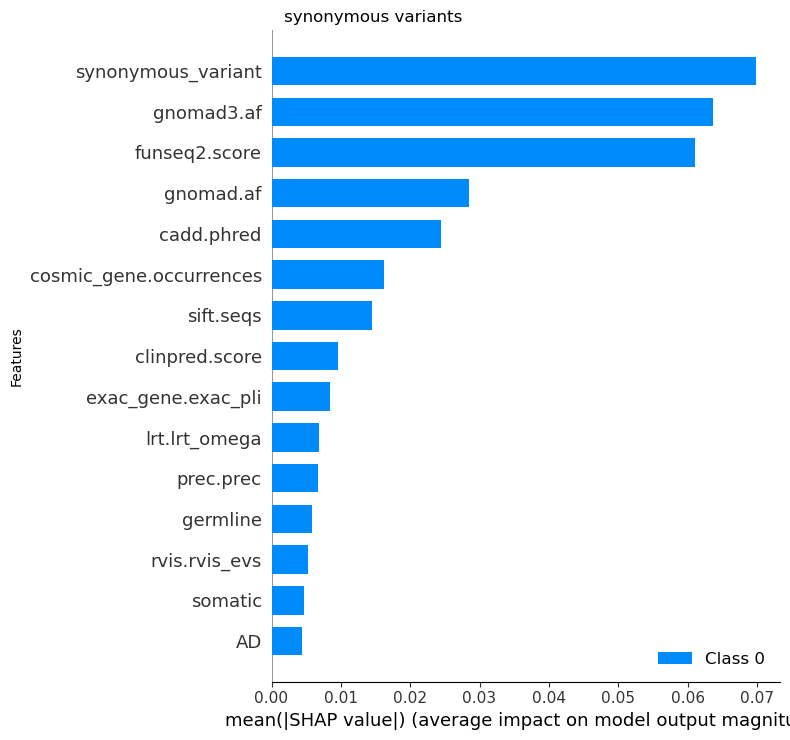

In [95]:
for so in conqs:
    plt.clf()
    #plt.suptitle("Benchmarking damage prediction tools", fontsize=10)
    plt.xlabel("mean SHAP value")
    plt.ylabel("Features")
    plt.title(f"SHAP plot for {so}")

    missense = var1[(var1['so'] ==so)].drop(config_dict["train_cols"]+extra_cols, axis=1).reset_index(drop=True)
    print(f"{so} variant shape: {missense.shape}")
    background_x = missense.loc[np.random.choice(missense.shape[0], 500, replace=False)]
    shap_values = explainer.shap_values(background_x)
    shap.summary_plot(shap_values, background_x, background_x.columns, show=False, max_display=15)
    plt.title(f"{so} variants", x=.2)

    #plt.show()
    plt.savefig(
        f"/Users/tarunmamidi/Documents/Development/DITTO-1/data/shap_plots/{so}_SHAP.pdf",
        format="pdf",
        dpi=1000,
        bbox_inches="tight",
    )


In [45]:
var1[['mavedb.score','DITTO']].head()


mavedb.score  DITTO
0      0.867714    1.0
1      0.867714    1.0
2      0.867714    1.0
3      0.867714    1.0
4      0.867714    1.0

In [49]:
var1[['mavedb.score','DITTO']].dtypes


mavedb.score    float64
DITTO           float32
dtype: object

In [68]:
var1.shape


(37027, 256)

In [64]:
sc_data = var1[['mavedb.score','DITTO']].drop_duplicates().reset_index(drop=True)
sc_data.head()


mavedb.score  DITTO
0      0.867714    1.0
1      1.085198    1.0
2      0.873427    1.0
3     -0.006227    1.0
4      0.156953    1.0

In [69]:
sc_data.shape


(9930, 2)

In [67]:
sc_data['mavedb.score'].value_counts()


mavedb.score
 0.867714    9889
 1.156741       1
 1.080369       1
 1.130410       1
 1.051897       1
 0.993691       1
 0.993719       1
 1.003396       1
 1.057490       1
 0.417562       1
 1.060959       1
 1.085198       1
 1.132874       1
 1.249492       1
 1.037391       1
 1.003263       1
 0.940107       1
 0.981642       1
 1.392515       1
 1.055863       1
-0.004865       1
 0.107000       1
 0.522931       1
 0.009492       1
 0.873427       1
-0.006227       1
 0.156953       1
 0.031064       1
 0.090229       1
 0.719476       1
 0.407828       1
-0.062169       1
 0.167416       1
 0.267447       1
 1.156291       1
 0.162758       1
 1.137468       1
 0.330857       1
 0.167144       1
 1.263799       1
 1.025690       1
 0.866452       1
Name: count, dtype: int64

<Axes: ylabel='Density'>

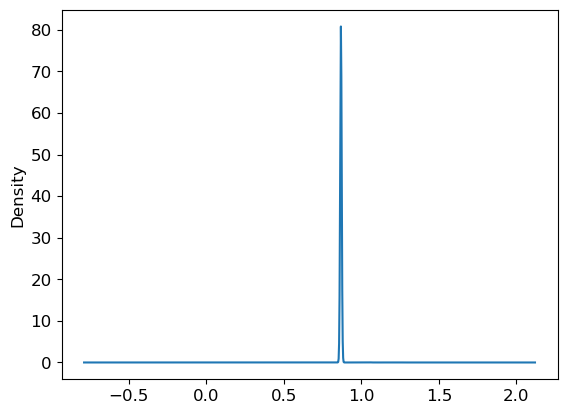

In [66]:
sc_data['mavedb.score'].plot(kind='kde')


<Axes: xlabel='DITTO', ylabel='mavedb.score'>

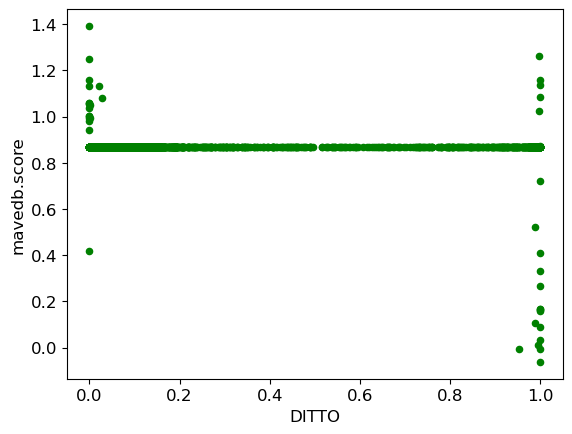

In [65]:
sc_data.plot(kind='scatter', x='DITTO', y='mavedb.score', color='g')
